# Bank Marketing Data Notebook


---

---

## Table of Contents
- [The Project](#the-project)
    - [Business Problem](#business-problem)
    - [Methodology](#methodology)
- [About the Dataset](#about-the-dataset)
    - [Inputs](#inputs)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Categorical Features](#categorical-features)
    - [Continuous Features](#continuous-features) 
- [Data Pipeline & Preprocessing](#data-pipeline--preprocessing)
    - [Baseline](#baseline)
    - [Feature Engineering](#feature-engineering)
- [Modeling](#modeling)
    - [Tuning Models](#tuning-models)
    - [Training Best Model](#training-best-model)
    - [Feature Importance](#feature-importance)
    - [Saving Model](#saving-model)
- [Conclusion](#conclusion)

---

---

## The Project
This notebook documents the Data Science process for the **Tech Challenge 3** belonging to FIAP's Machine Learning Engineering PostGrad program. <br><br>
In this project we will use the [Bank Marketing dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing) available at the UC Irvine Machine Learning Repository to build a model using **supervised learning techniques for classification tasks.** <br><br>
### Business Problem
A bank wants to improve the efficiency of its telemarketing campaigns for term deposits. Our goal is to create a machine learning model that can predict which clients are more likely to subscribe, allowing the bank to focus its efforts on the most promising leads, increasing the success rate and reducing marketing costs.<br><br>
### Methodology
This project follows a structured Machine Learning Workflow:<br><br>
1. **Exploratory Data Analysis:** We will analyze the dataset to understand distributions, find patterns, and form our initial hypotheses.<br><br>
2.**Data Pipeline & Preprocessing:** We will build a simple classification model using *Logistic Regression* to build a baseline to compare our more complex models with. In this stage, we will also clean the data and engineer features based on insights from the exploratory analysis.<br><br>
3. **Modeling & Comparison:** We will evaluate a suite of classifiers using cross-validation. Based on performance, we will select a few models for hyperparameter tuning with Optuna to extract the best performance possible.<br><br>
4. **Conclusion:** In the conclusion, we will provide a final overview of our discoveries, models, and methodology, focusing on how this project can help with the solution of the business problem.


---

---

## About the Dataset

The data is related to direct marketing campaigns of a Portuguese banking institution. These campaigns were primarily conducted via phone calls, and often, more than one contact to the same client was required to determine if the product (*a bank term deposit*) would be subscribed to. <br><br>
The classification goal of this project is to predict if a client will subscribe (`yes` or `no`) to a term deposit, which is our target variable, `y`.

### Inputs

To better understand the content of this dataset, we listed below the variable names, types, and description, as found in the variables table provided on the official UC Irvine Machine Learning Repository:<br><br>

| Variable Name | Type        | Description                                                                                                                                           |
| ------------- | ----------- | ----------------------------------------------------------------------------------------------------------------------------------------------------- |
| age           | Integer     | The person's age.                                                                                                                                     |
| job           | Categorical | Type of job (e.g., `admin`, `services`, etc.).                                                                                                        |
| marital       | Categorical | Marital status (e.g., `divorced`, `married`, etc.).                                                                                                   |
| education     | Categorical | Educational level (e.g., `high.school`, `university.degree`, etc.).                                                                                   |
| default       | Binary      | Has credit in default?                                                                                                                                |
| balance       | Integer     | Average yearly balance.                                                                                                                               |
| housing       | Binary      | Has housing loan?                                                                                                                                     |
| loan          | Binary      | Has personal loan?                                                                                                                                    |
| contact       | Categorical | Contact communication type (e.g., `cellular`, `telephone`).                                                                                           |
| day_of_week   | Date        | Day of the week when the last contact was made.                                                                                                       |
| month         | Date        | The month when the last contact was made.                                                                                                             |
| duration      | Integer     | The duration, in seconds, of the last contact made.                                                                                                   |
| campaign      | Integer     | Number of contacts performed during this campaing for this specific client, including the last contact.                                               |
| pdays         | Integer     | Number of days that have passed by after the client was last contacted from a previous campaign (`-1` means client was **not** previously contacted). |
| previous      | Integer     | Number of contacts performed for this client before this campaign.                                                                                    |
| poutcome      | Categorical | Outcome of the previous marketing campaign (`success`, `failure`, etc.)                                                                               |
| y             | Binary      | **Target variable**. It answers if the client has subscribed to a term deposit.                                                                       |


In [43]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import time
import optuna
import joblib
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              StackingClassifier, VotingClassifier, HistGradientBoostingClassifier)
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             f1_score, roc_auc_score, RocCurveDisplay, classification_report)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Settings and configurations
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

In [44]:
# Defining seed for reproducibility
seed = 42

---

---

## Exploratory Data Analysis
In this section, we'll conduct an EDA to understand the dataset. Our goal is to assess data quality, check missing values, and understand the relationship between features and the target variable. The insights gained here will be critical for guiding our feature engineering and modeling strategies in the next stages.

In [ ]:
# Defining functions for EDA
def display_feature_list(features, feature_type):
    '''
    This function displays the features within each list for each type of data
    '''

    print(f"\n{feature_type} Features: ")
    print(', '.join(features) if features else 'None')


def describe_df(df):
    """
    This function prints some basic info on the dataset and 
    sets global variables for feature lists.
    """

    global categorical_features, continuous_features, binary_features
    categorical_features = [
        col for col in df.columns if df[col].dtype == 'object']
    binary_features = [col for col in df.columns if df[col].nunique(
    ) <= 2 and df[col].dtype != 'object']
    continuous_features = [
        col for col in df.columns if df[col].dtype != 'object' and col not in binary_features]

    print(f"\n{type(df).__name__} shape: {df.shape}")
    print(f"\n{df.shape[0]:,.0f} samples")
    print(f"\n{df.shape[1]:,.0f} attributes")
    display_feature_list(categorical_features, 'Categorical')
    display_feature_list(continuous_features, 'Continuous')
    display_feature_list(binary_features, 'Binary (0 or 1)')
    print(f'\nData Types: \n{df.dtypes}')
    print(
        f'\nMissing Data Percentage: \n{(df.isnull().sum() / len(df) * 100).round(2).astype(str) + "%"}')
    print(f'\nDuplicates: {df.duplicated().sum()}')
    print(
        f'\nCategorical Feature Cardinality: \n{df[categorical_features].nunique().sort_values(ascending=False)}')
    print(
        f'\nFeatures with Zero Variance: {", ".join([col for col in df.columns if df[col].nunique() == 1]) if any(df[col].nunique() == 1 for col in df.columns) else "None"}')

    negative_valued_features = [
        col for col in df[continuous_features] if (df[col] < 0).any()]
    print(
        f'\nFeatures with Negative Values: {", ".join(negative_valued_features) if negative_valued_features else "None"}')

    print('\nStatistical Summary: \n')
    display(df.describe().T)
    print(f'\n{type(df).__name__} Head: \n')
    display(df.head(5))
    print(f'\n{type(df).__name__} Tail: \n')
    display(df.tail(5))

In [46]:
# Loading the dataset
df = pd.read_csv('../data/raw/bank_marketing.csv')
describe_df(df)


DataFrame shape: (45211, 17)

45,211 samples

17 attributes

Categorical Features: 
job, marital, education, default, housing, loan, contact, month, poutcome, y

Continuous Features: 
age, balance, day_of_week, duration, campaign, pdays, previous

Binary (0 or 1) Features: 
None

Data Types: 
age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
loan           object
contact        object
day_of_week     int64
month          object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

Missing Data Percentage: 
age              0.0%
job             0.64%
marital          0.0%
education       4.11%
default          0.0%
balance          0.0%
housing          0.0%
loan             0.0%
contact         28.8%
day_of_week      0.0%
month            0.0%
duration         0.0%
campaign         0.0%
pday

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day_of_week,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0



DataFrame Head: 



,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no



DataFrame Tail: 



,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NaN,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NaN,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NaN,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


- **Missing Data:** The dataset contains significant missing values that we must investigate further.
    - The `poutcome` feature is the most extreme case, with over 80% of its data missing. 
    - The variables `contact`, `education`, and `job` also have a notable number of nulls that will require attention. 
- **Feature Interpretation**
    - We have reasons to believe that the column `day_of_week` is mislabeled, given it ranges from 1 to 31, signaling it refers to the day of the month, instead of day of the week.
    - We can see that many numerical features, such as `balance`, `campaign`, and `duration`, are heavily right-skewed, indicating that transformations will be necessary before feeding them to our baseline model. That's because linear models, like Logistic Regression, are very sensitive to the scale of the data and can become biased towards values that are far away from the rest of the data.
- **Data Leakage**
    - Feature `duration` represents a data leak. Its value is *unknown* before a call is made, so it must be dropped from our dataset before building our models.

### Categorical Features
Our data has a set of both categorical and continuous features. Let's first focus on the categorical features. We will start by analyzing the distribution of the target variable `y` and then see how the subscription rate varies across different categories. 


In [ ]:
# EDA Plots
def plot_stacked_bar_percentage(df, feat, target, positive_class='yes'):
    """
    This function plots a 100% stacked bar chart to show the relationship
    between a categorical feature and a binary target variable, including missing values.
    Bars are sorted by the percentage of the positive class.
    """
    palette = ['#29788E', '#E85B5B']

    feature_data = df[feat].fillna('Missing')

    ct = pd.crosstab(feature_data, df[target], normalize='index')

    ct = ct.sort_values(by=positive_class, ascending=False)

    ax = ct.plot(
        kind='barh',
        stacked=True,
        color=palette,
        figsize=(12, 8),
        legend=False
    )

    fig = ax.get_figure()
    fig.set_facecolor('#f5f7f6')
    ax.set_facecolor('#f5f7f6')
    ax.tick_params(axis='x', colors='#555555')
    ax.tick_params(axis='y', colors='#555555')

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        if width > 0:
            ax.text(
                x + width / 2,
                y + height / 2,
                f'{width:.1%}',
                ha='center',
                va='center',
                color='white',
                fontsize=12,
                fontweight='bold'
            )

    ax.set_title(
        f"Proportion of '{target}' by '{feat}'",
        fontsize=18, fontweight='bold', pad=20, loc='left', color='#333333'
    )
    ax.set_xlabel(
        'Proportion', fontweight='bold', color='#555555'
    )
    ax.set_ylabel(
        feat.title(), fontweight='bold', color='#555555'
    )

    ax.legend(
        title=target.title(),
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
    )
    
    ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    ax.invert_yaxis()

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

In [ ]:
# EDA Plots
def plot_donut(df, feat):
    """
    This function plots a donut chart to show the distribution of a categorical feature.
    """
    counts = df[feat].value_counts()
    labels = counts.index
    values = counts.values

    palette = {
        'no': '#29788E',
        'yes': '#E85B5B'
    }
    colors = [palette.get(label, '#CCCCCC') for label in labels]

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10,8))
    fig.set_facecolor('#f5f7f6')

    wedges, texts, autotexts = ax.pie(
        values,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        pctdistance=0.85,
        textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'white'}
    )

    center_circle = plt.Circle((0,0),0.70,fc='#f5f7f6')
    ax.add_artist(center_circle)

    total = df[feat].count()
    ax.text(
        0,0,
        f'Total:\n{total:,}',
        ha='center',
        va='center',
        fontsize=20,
        fontweight='bold',
        color='#555555'
    )

    ax.set_title(
        f"Proportion of Target Variable: '{feat}'",
        fontsize=18, fontweight='bold', pad=20, loc='center', color='#333333'
    )

    ax.axis('equal')

    ax.legend(
        wedges,
        labels,
        title=feat.title(),
        loc='upper right'
    )
    plt.tight_layout()
    plt.show()

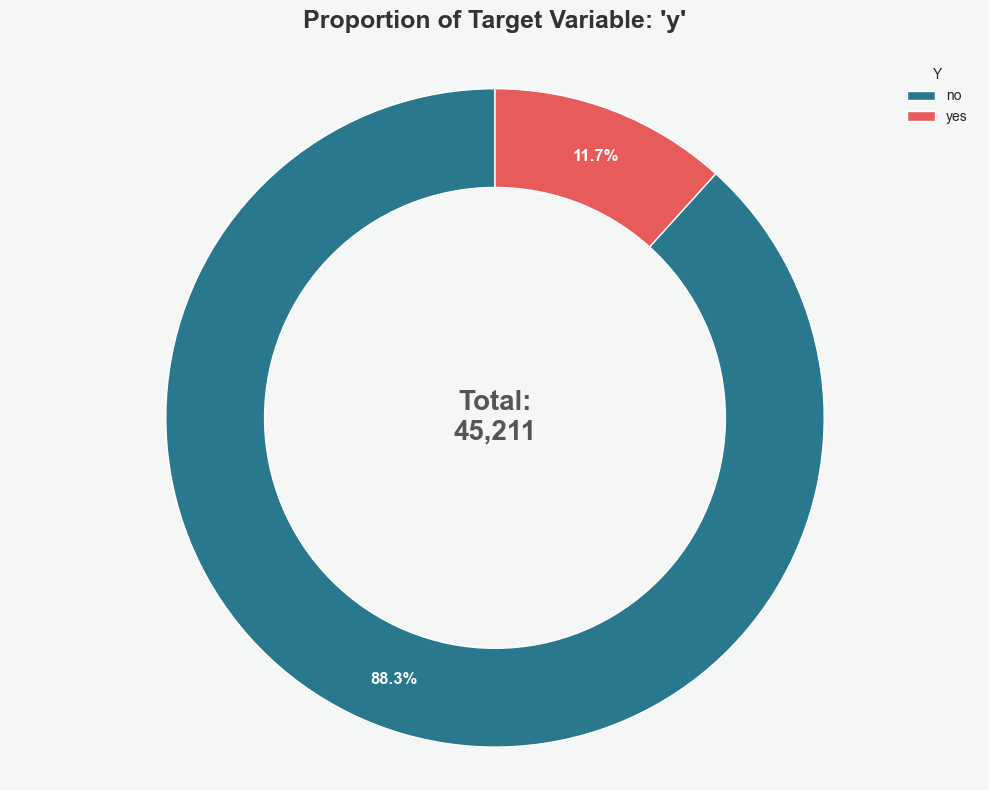

In [49]:
# Obtaining the proportion of labels in the target variable
plot_donut(df, 'y')

- **Class Distribution**
    - The chart above shows that our dataset is **highly imbalanced**, meaning that both classes are **not** represented equally. The negative class `no` is the overwhelming majority, accounting for 88.3% (39,922 instances) of a total of 45,211 samples. The `yes` class, on the other hand, accounts for a small minority of 5,289 instances (11.7% of the total).<br><br>
    - Given this context, a lazy model could achieve 88.3% accuracy by simply predicting *'no'* every single time. `Accuracy` will be a misleading metric. <br><br>
- **Dealing with Imblanced Labels**
    - Considering the class imbalance, we must focus on other metrics besides accuracy. We must also use the right strategy to deal with imbalance, such as defining the `class_weight='balanced'` param in our models or use techniques like SMOTE to oversample the minority class.

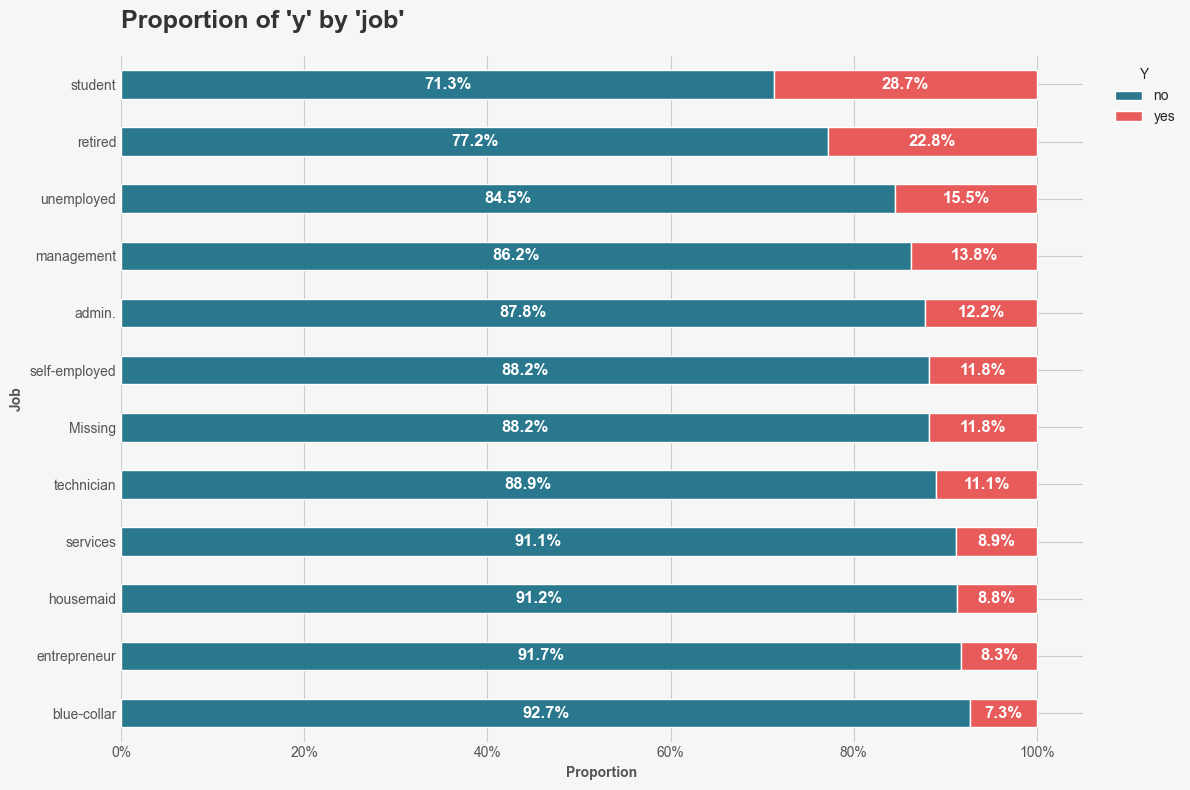

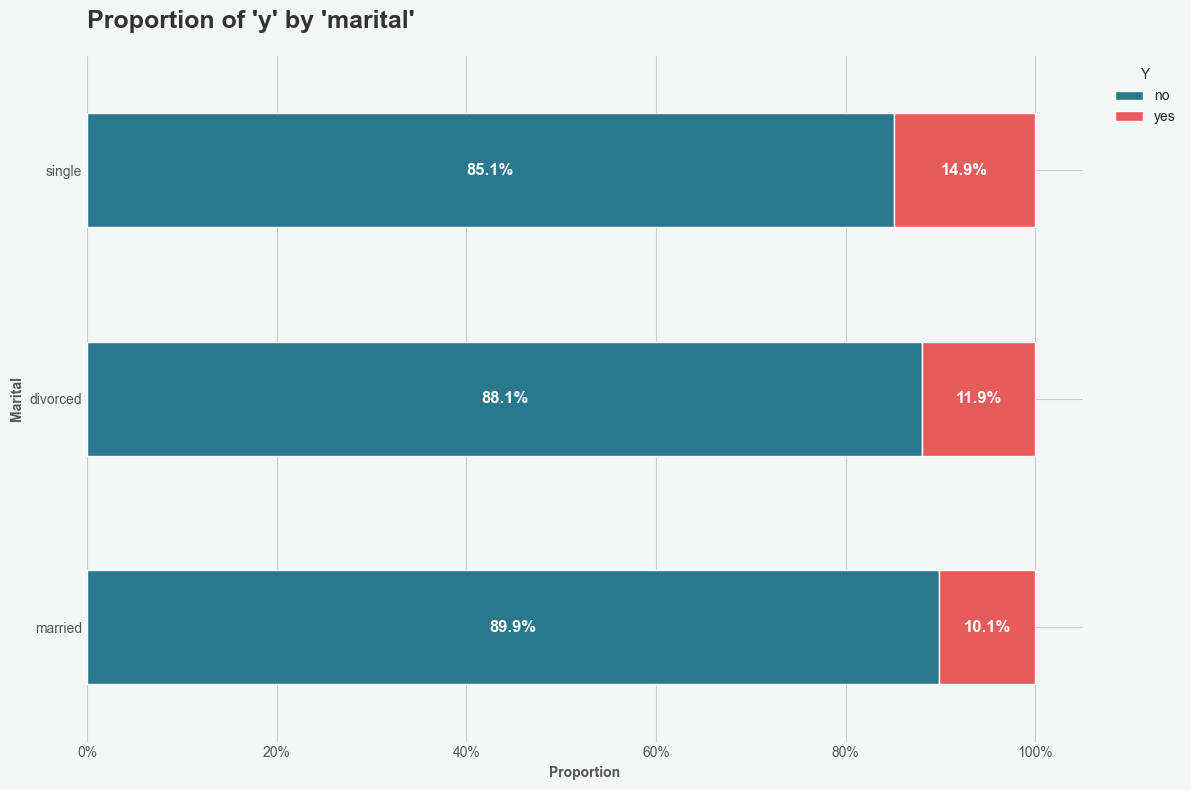

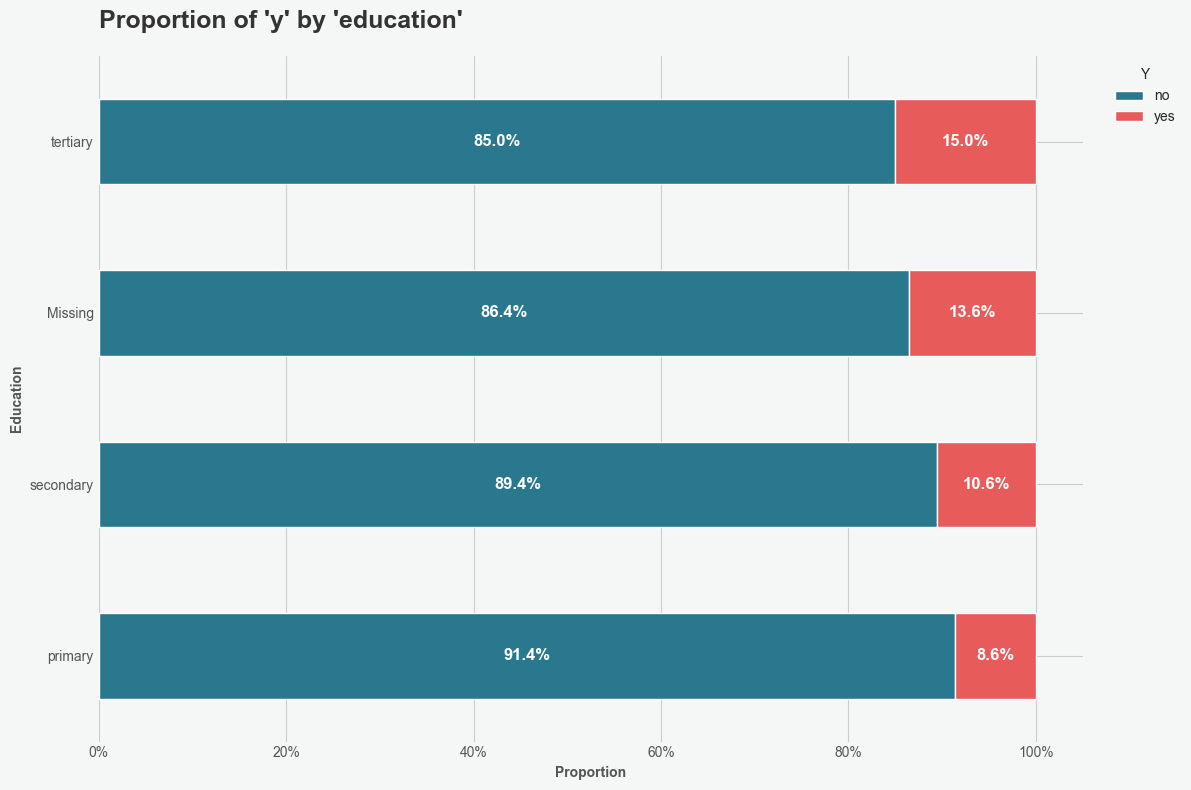

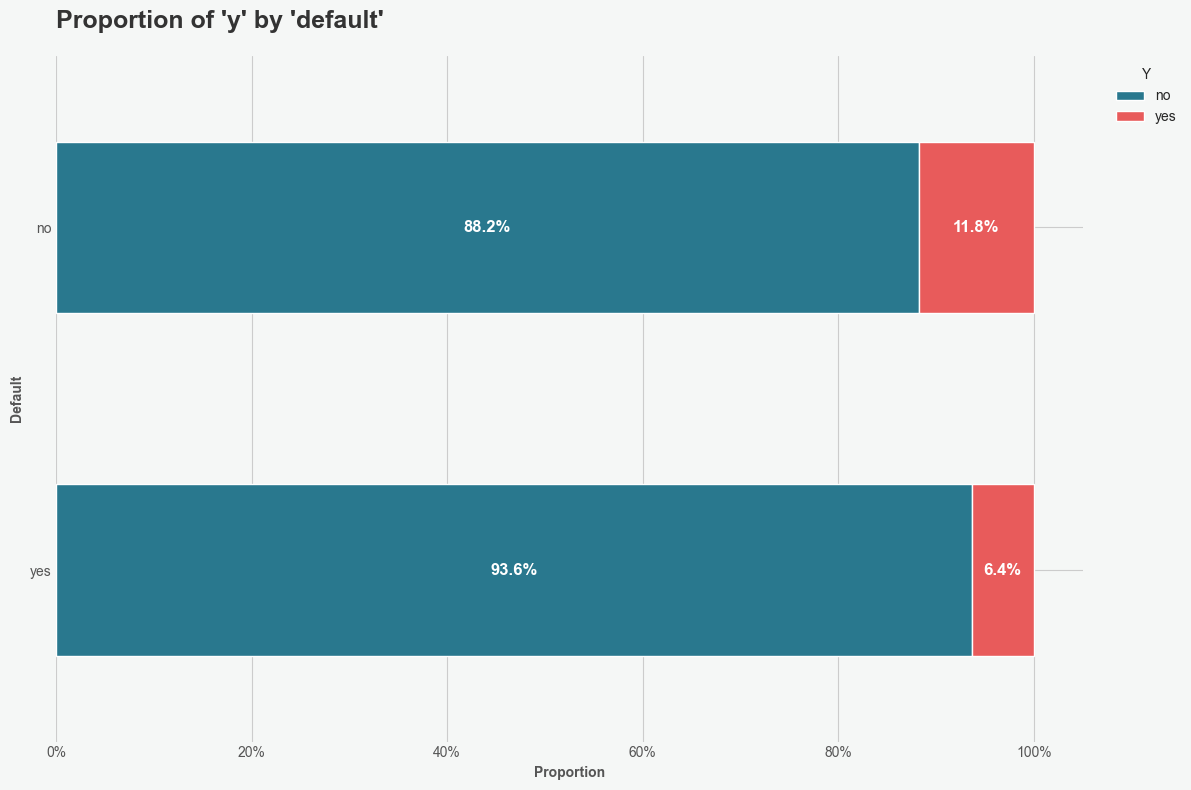

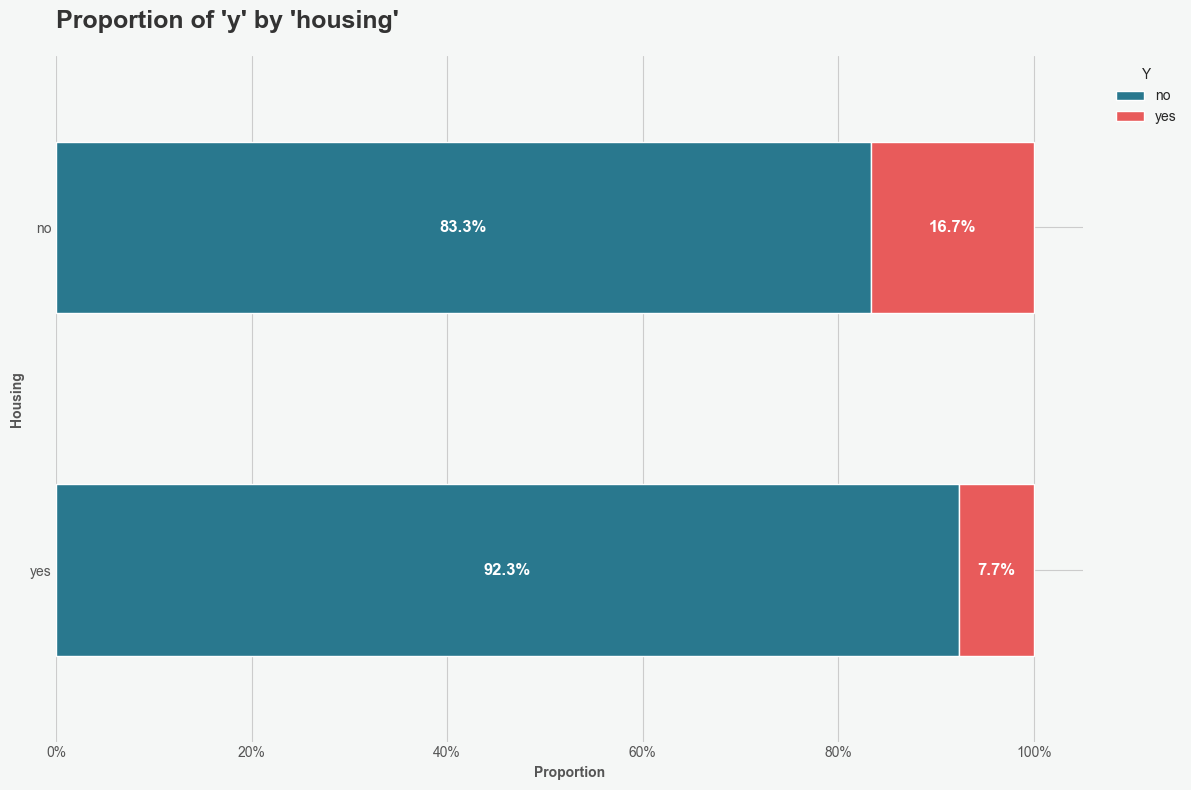

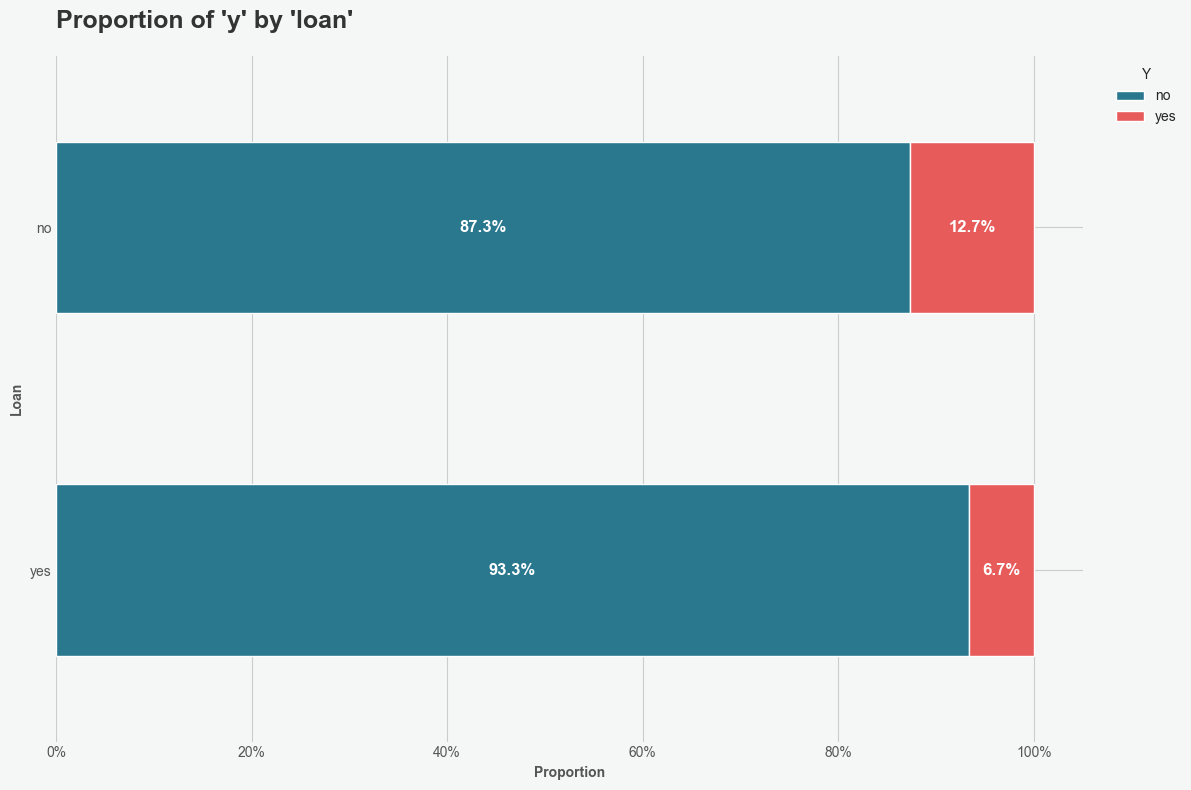

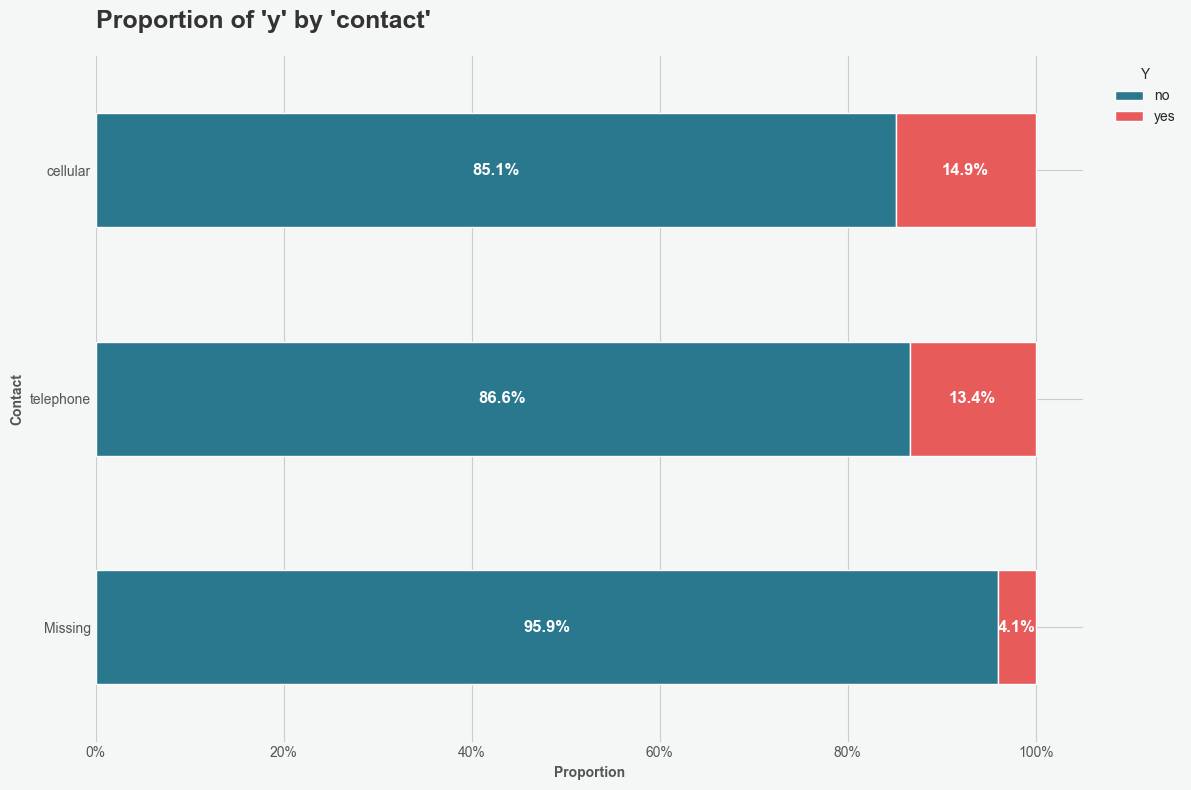

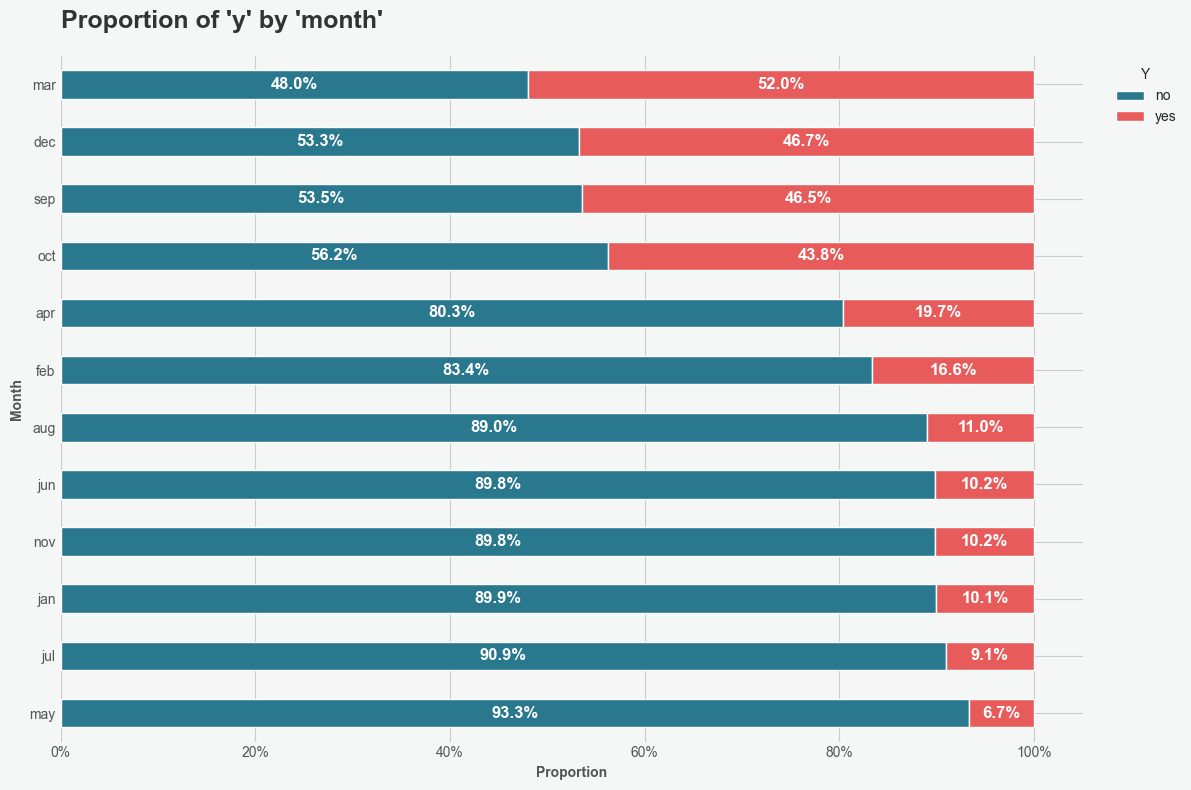

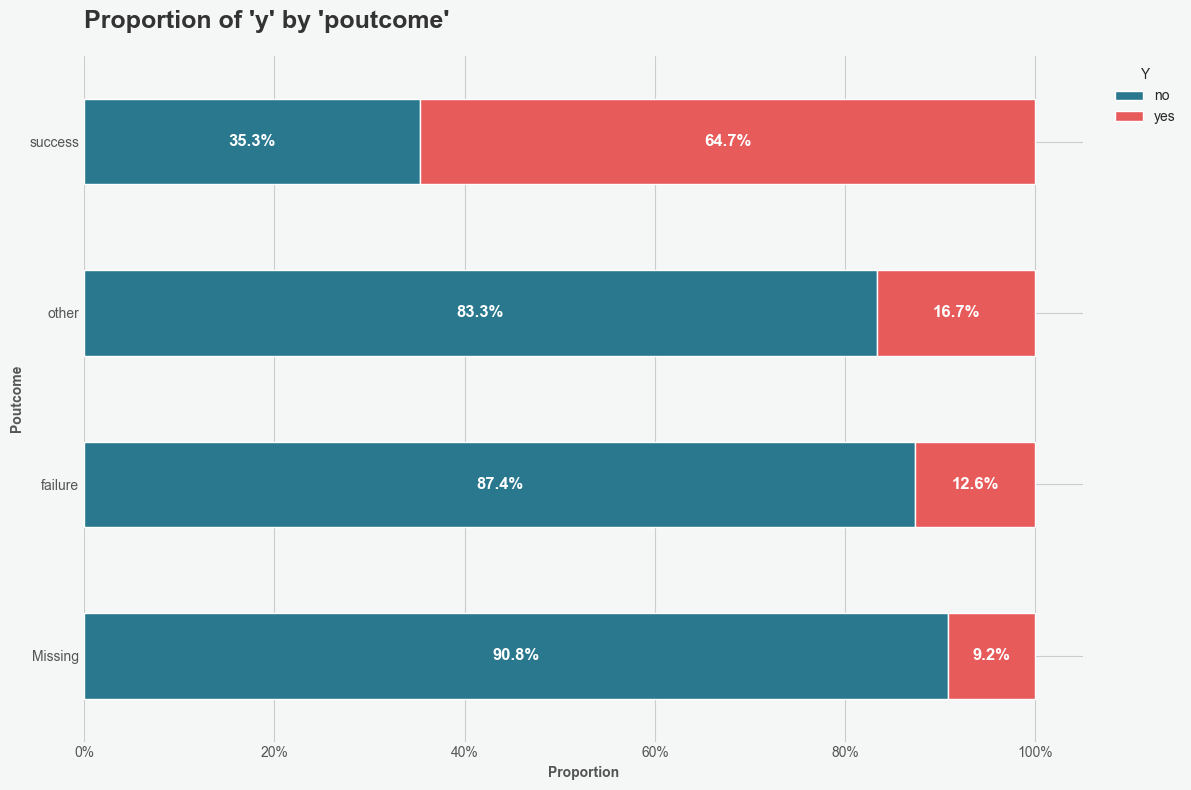

In [50]:
# Observing the relationship between categorical features and the target variable
categorical_features.remove('y')
for feat in df[categorical_features]:
    plot_stacked_bar_percentage(df, feat, 'y')

- **Time-Based & Behavioral Features**
    - The `month` variable appears to be a good predictor. There is a clear seasonal pattern, where campaings in March, September, October and December are wildly successful. May and July, on the other hand, presented worse outcomes. <br><br>
    - The previous campaign outcome (`poutcome`) is also a powerful indicator. Clients with a prior '*success*' are more likely to subscribe again.
- **Demographics & Occupation**
    - The `job` type reveals interesting patterns as well. Those labeled as `student` and `retired` appears to have the highest propensity to subscribe. On the other hand, `blue-collar` workers and `entrepreneur` were the least likely.<br><br>
    - A similar trend can be observed for `marital` status and `education`. `Single` clients and those with `tertiary` (i.e., higher education) had slightly higher success rates.
- **Financial Status**
    - Binary categorical features (`housing`, `loan`, and `default`) also show interesting insights. Subscriptions are more common proportionally among those with no existing housing loan, no personal loan, and no credit default. This could indicate that clients with fewer financial liabilities are a more receptive audience for this product. <br><br>


### Continuous Features
Now we'll turn our attention to the continuous features. We will analyze their distributions and explore how they relate to the subscription outcome. We will also use a correlation matrix to assess any relationships between the numerical features themselves.

In [ ]:
# EDA Plots
def plot_hist_box(df, feat):
    """
    This function plots a histogram and a box plot side-by-side
    for a given continuous feature.
    """
    fig, axes = plt.subplots(
        1,2,
        figsize=(14, 6),
        facecolor='#f5f7f6',
        gridspec_kw={'width_ratios': [1, 4]}
    )

    fig.suptitle(
        f'Distribution of {feat}',
        fontsize=18, fontweight='bold', color='#333333', y=1.05
    )
    sns.boxplot(
        y=df[feat],
        ax=axes[0],
        color='#D32F2F',
        boxprops=dict(alpha=.7),
        medianprops=dict(color='white', linewidth=2)
    )
    axes[0].set_facecolor('#f5f7f6')
    axes[0].set_title('Box Plot', fontsize=14, fontweight='bold', color='#555555')
    axes[0].set_ylabel(feat.title(), fontweight='bold', color='#555555')
    axes[0].set_xlabel('')

    sns.histplot(
        data=df,
        x=feat,
        ax=axes[1],
        color='#1976D2',
        kde=True,
        alpha=0.6,
        edgecolor='w',
        linewidth=1.5
    )
    axes[1].set_facecolor('#f5f7f6')
    axes[1].set_title('Histogram & Density Curve (KDE)', fontsize=14, fontweight='bold', color='#555555')
    axes[1].set_xlabel(feat.title(), fontweight='bold', color='#555555')
    axes[1].set_ylabel('Frequency', fontweight='bold', color='#555555')

    sns.despine(left=True, bottom=True)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()


In [ ]:
# EDA plots
def plot_kde_by_target(df, cont_feat, target):
    """
    This function plots overlapping KDEs for a continuous feature, 
    separated by the binary target variable.
    """
    palette = {
        'no': '#29788E',
        'yes': '#E85B5B'
    }

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    fig.set_facecolor('#f5f7f6')
    ax.set_facecolor('#f5f7f6')

    sns.kdeplot(
        data=df,
        x=cont_feat,
        hue=target,
        fill=True,
        common_norm=False,
        alpha=0.6,
        palette=palette,
        linewidth=2.5,
        ax=ax
    )

    ax.set_title(
        f"Distribution of '{cont_feat}' by '{target}'",
        fontsize=18, fontweight='bold', pad=20, loc='left', color='#333333'
    )

    ax.set_xlabel(
        cont_feat.title(), fontweight='bold', color='#555555'
    )
    ax.set_ylabel(
        'Density', fontweight='bold', color='#555555'
    )
    
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

In [ ]:
# EDA Plots
def plot_correlation_heatmap(df):
    """
    This function plots a correlation heatmap for numerical features.
    """
    
    corr = df.corr(numeric_only=True).round(2)

    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig, ax = plt.subplots(figsize=(10, 8))
    fig.set_facecolor('#f5f7f6')

    sns.heatmap(
        corr,
        mask=mask,
        annot=True,
        fmt='.2f',
        cmap='YlOrBr',
        center=0,
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .8},
        ax=ax
    )

    ax.set_title(
        'Feature Correlation Heatmap',
        fontsize=18, fontweight='bold', pad=20, loc='left', color='#333333'
    )
    plt.xticks(rotation=45, ha='right', fontsize=10, color='#555555')
    plt.yticks(rotation=0, fontsize=10, color='#555555')

    plt.tight_layout()
    plt.show()

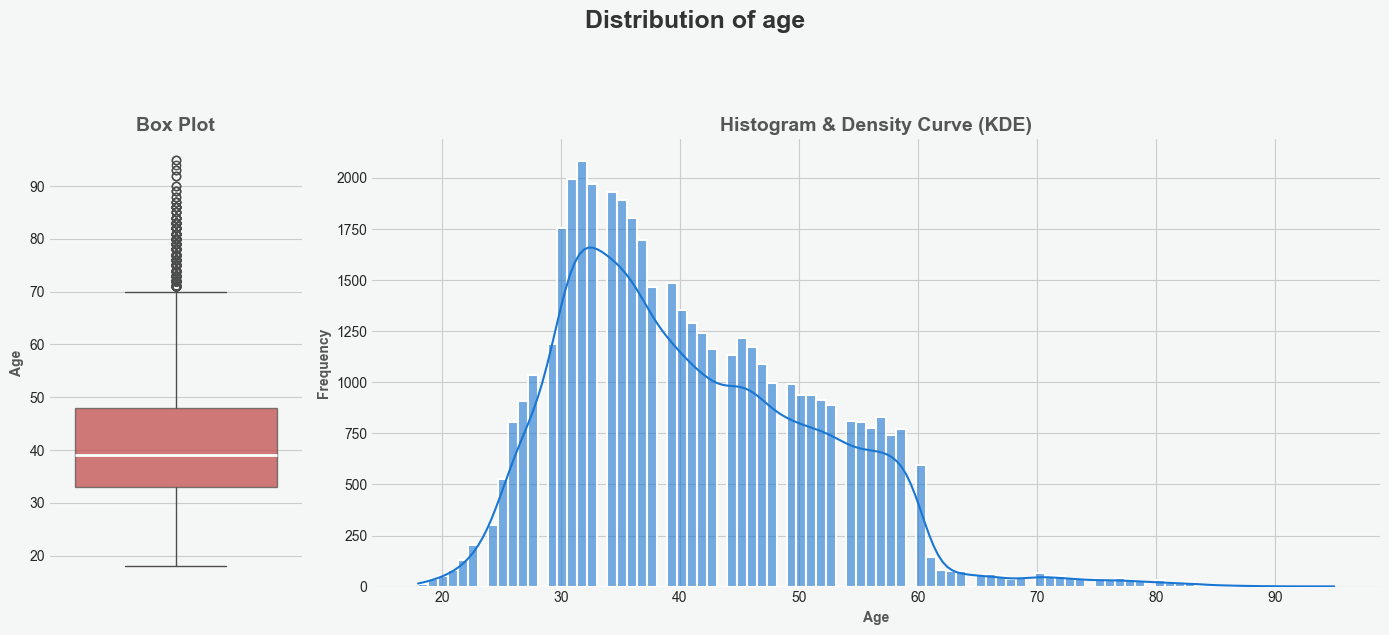

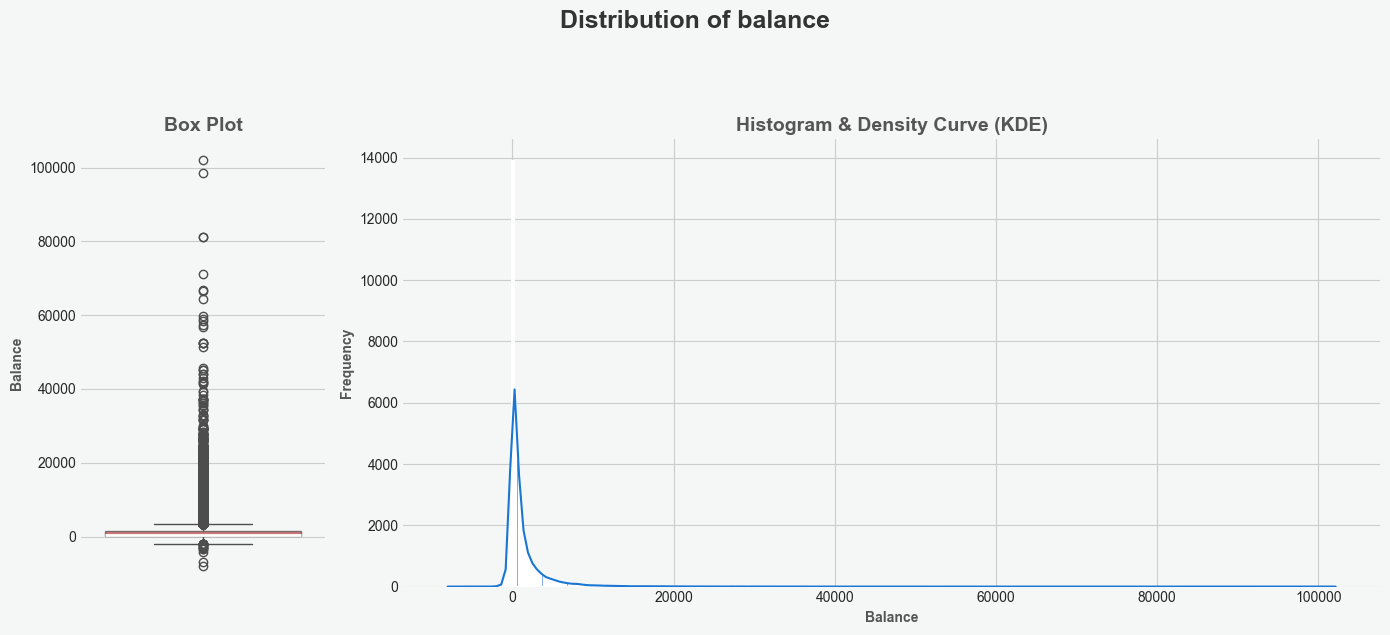

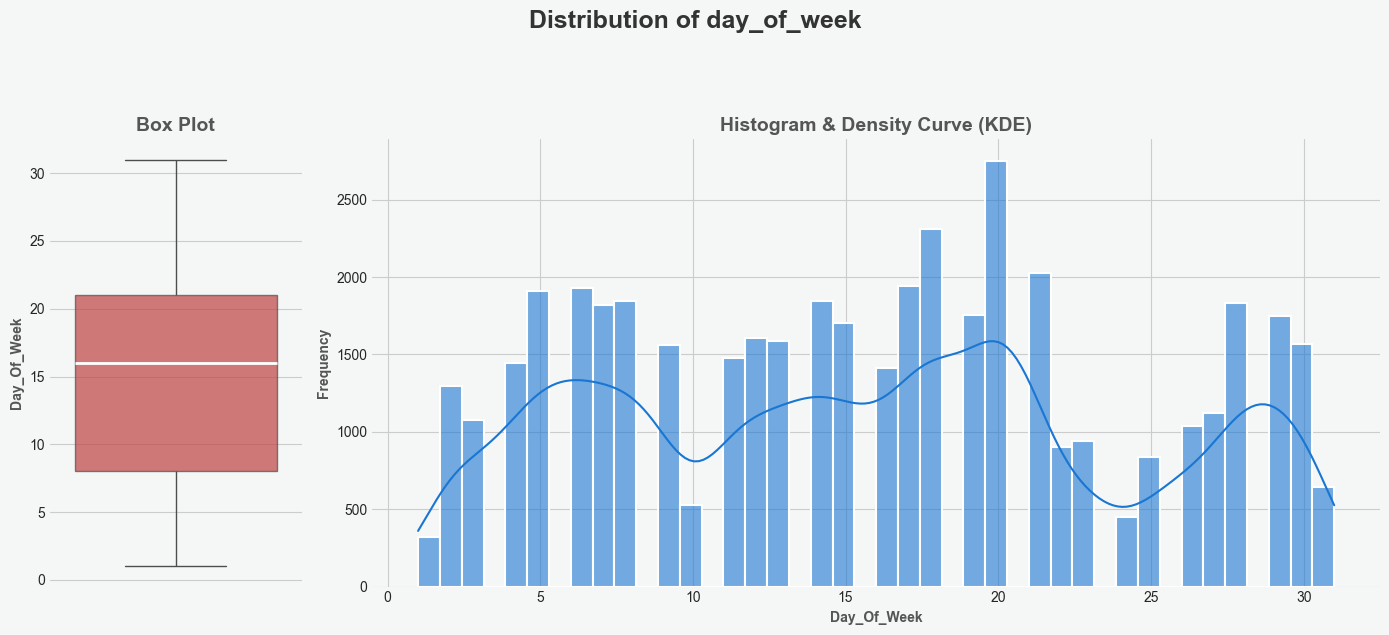

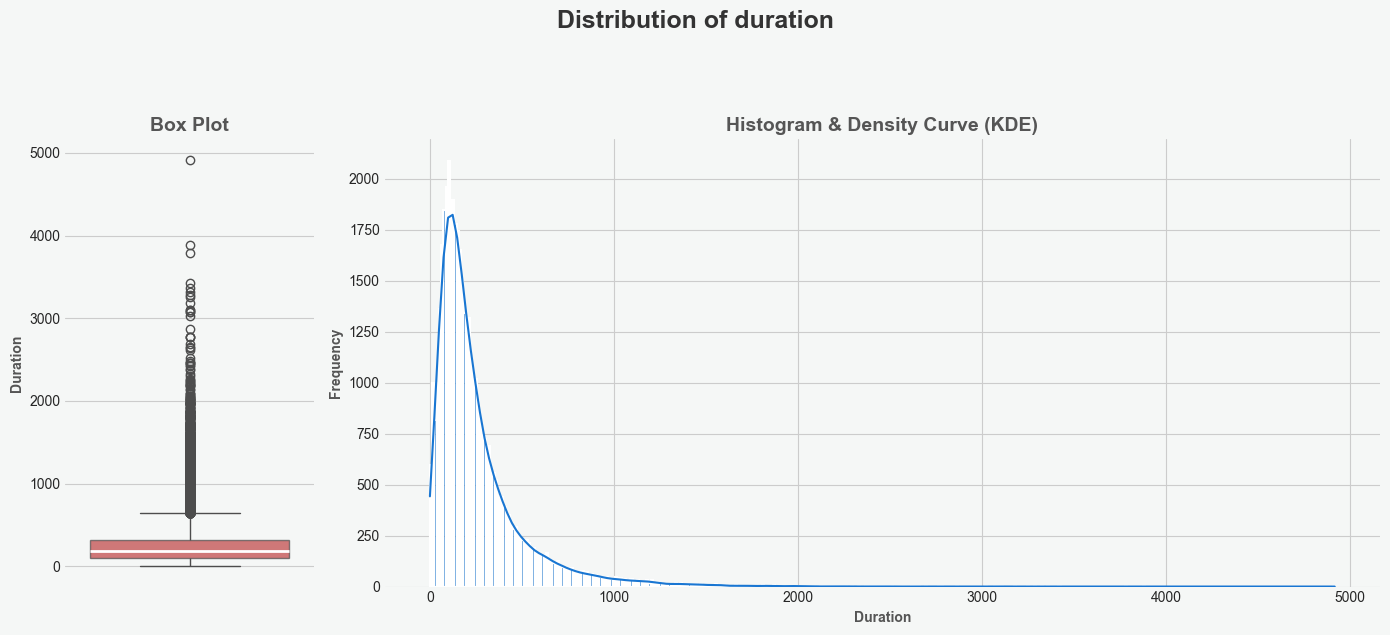

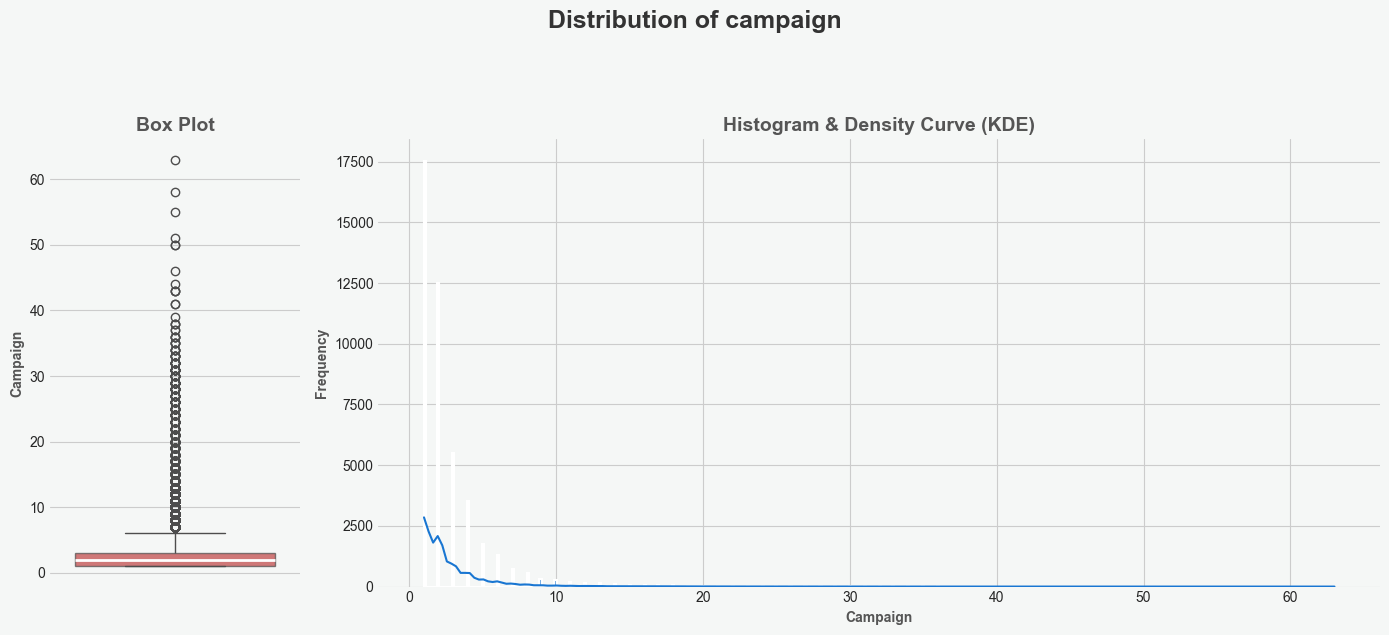

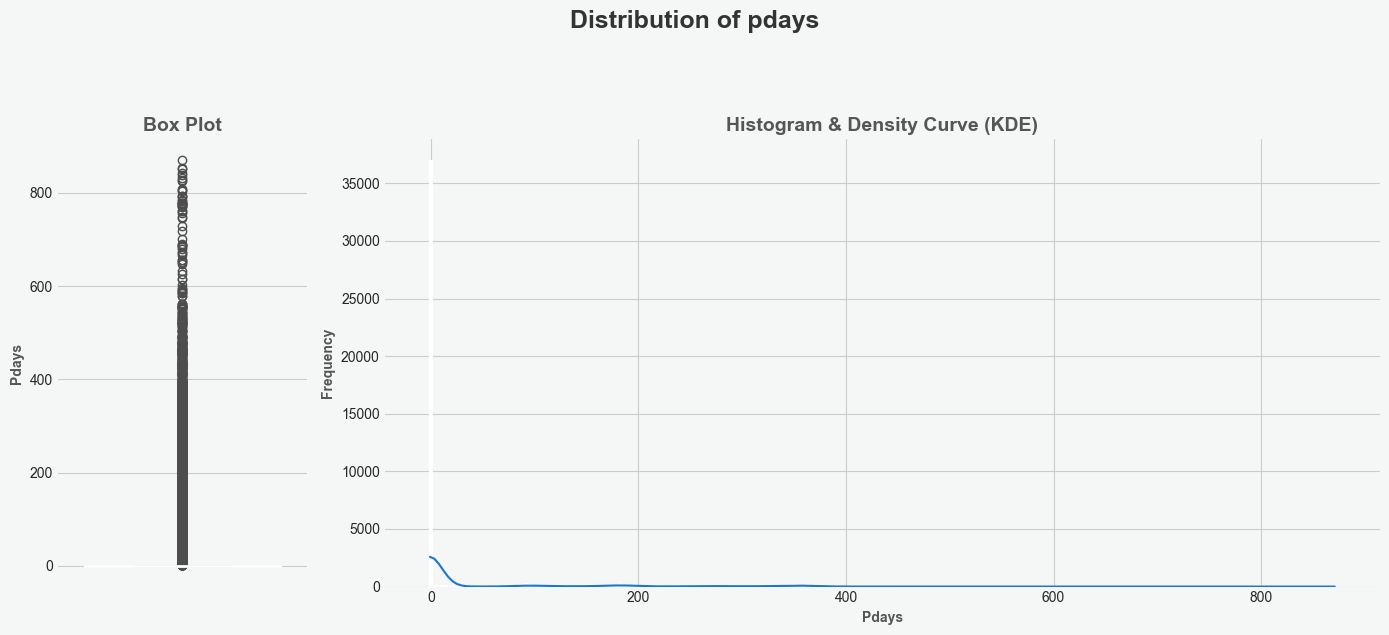

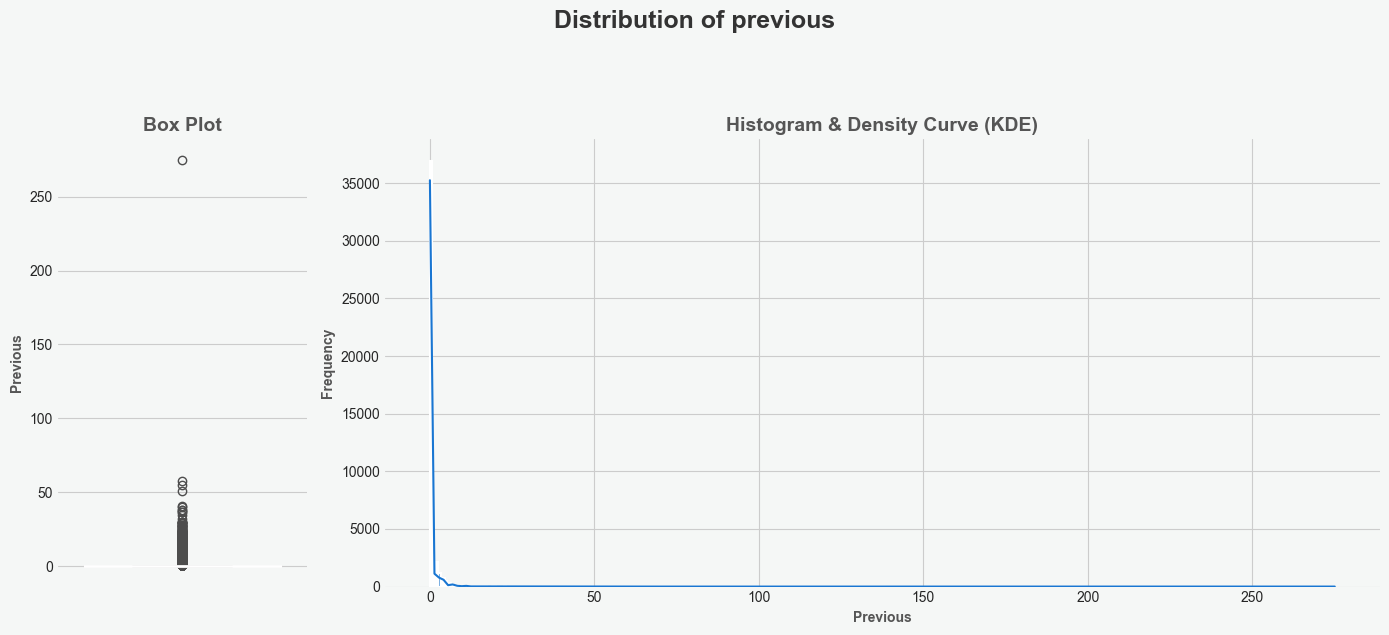

In [ ]:
# Plotting Box Plot and Histogram for continuous features
for feat in continuous_features:
    plot_hist_box(df, feat)

- **Skewness**
    - The variables `balance`, `duration`, and `campaign` are heavily right-skewed. That means there is a much larger concentration of data points at the lower end with a long tail of extreme, but less frequent, values. For **linear models** (e.g., Support Vector Machines, Logistic Regression) and **distance-based** algorithms (e.g., KMeans), this skew can be problematic. <br><br>
- **Quasi-Categorical Features**
    - The `pdays` and `previous` features are not truly continuous but behave as *quasi-categorical variables*. Each is dominated by a single value (-1 for `pdays` and 0 for `previous`), which accounts for over 80% of the data. This indicates they should be re-engineered into binary or categorical features rather than being treated as numerical.

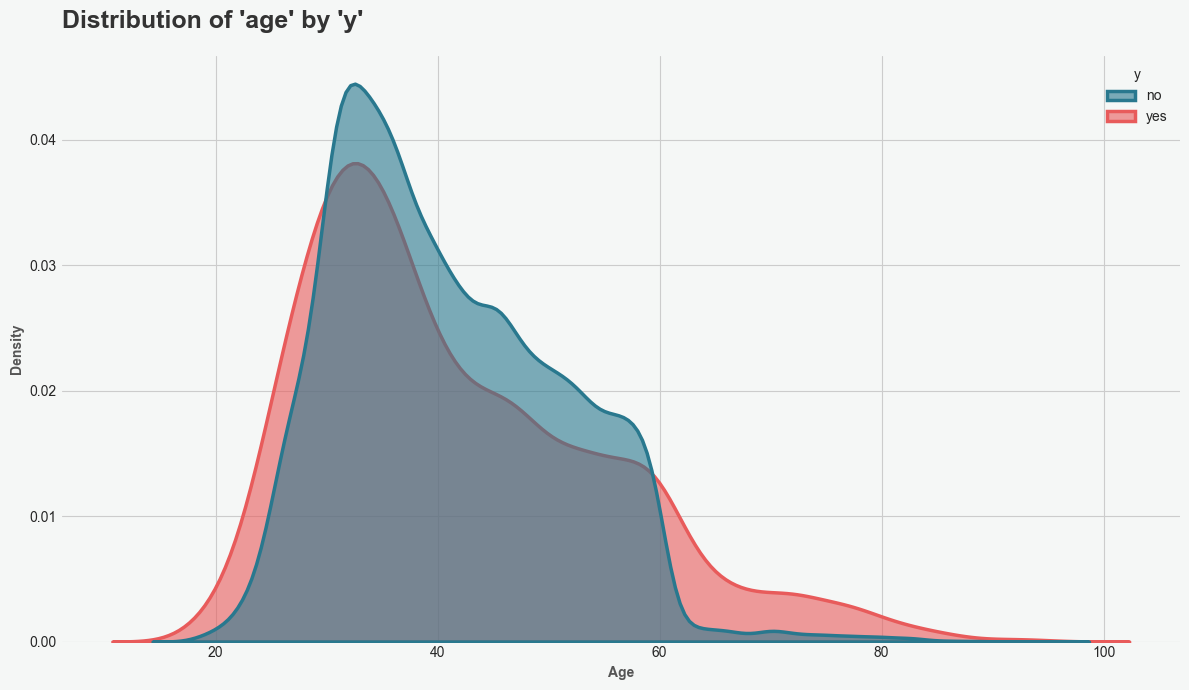

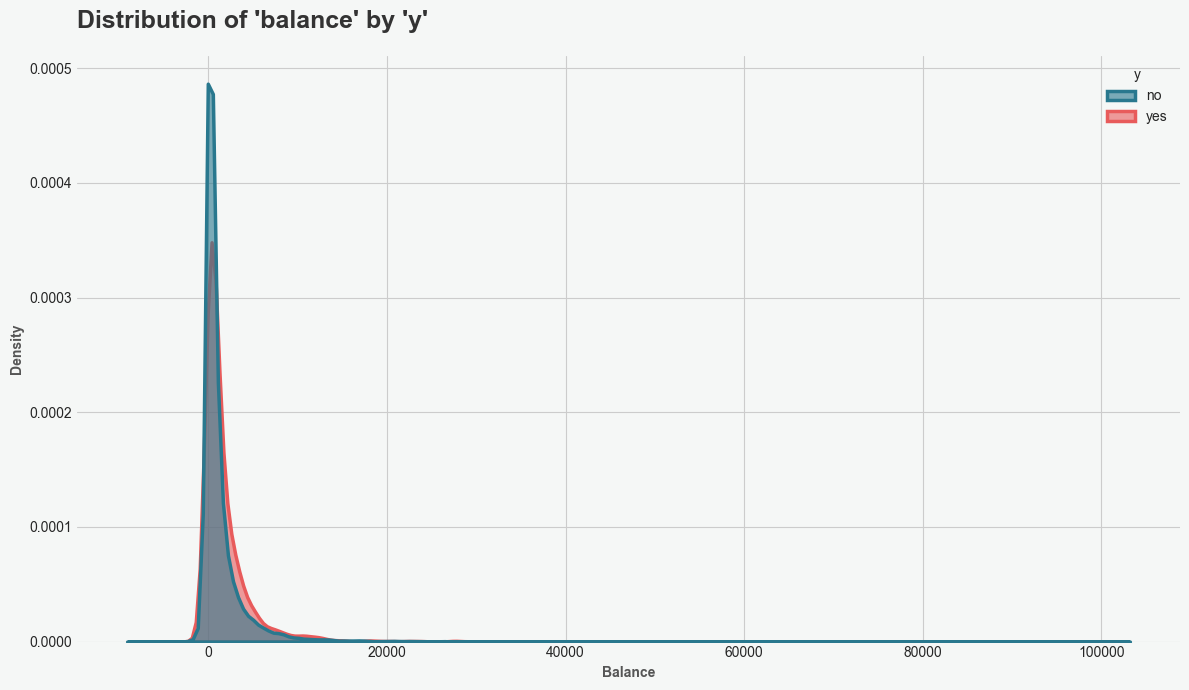

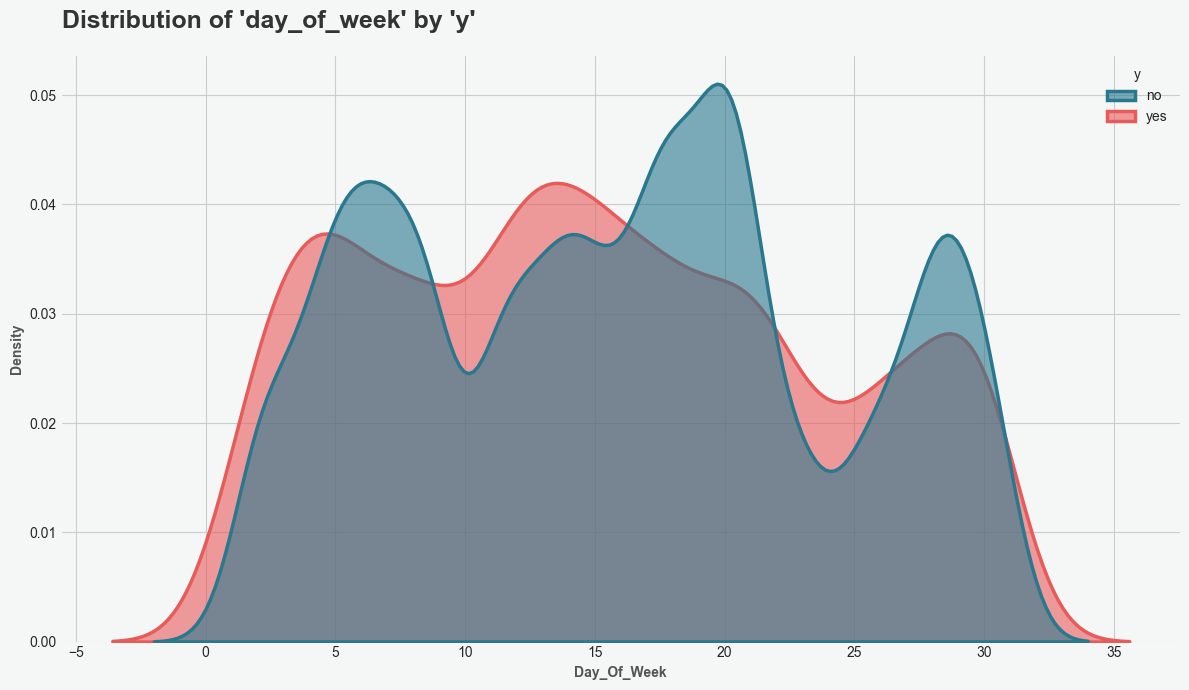

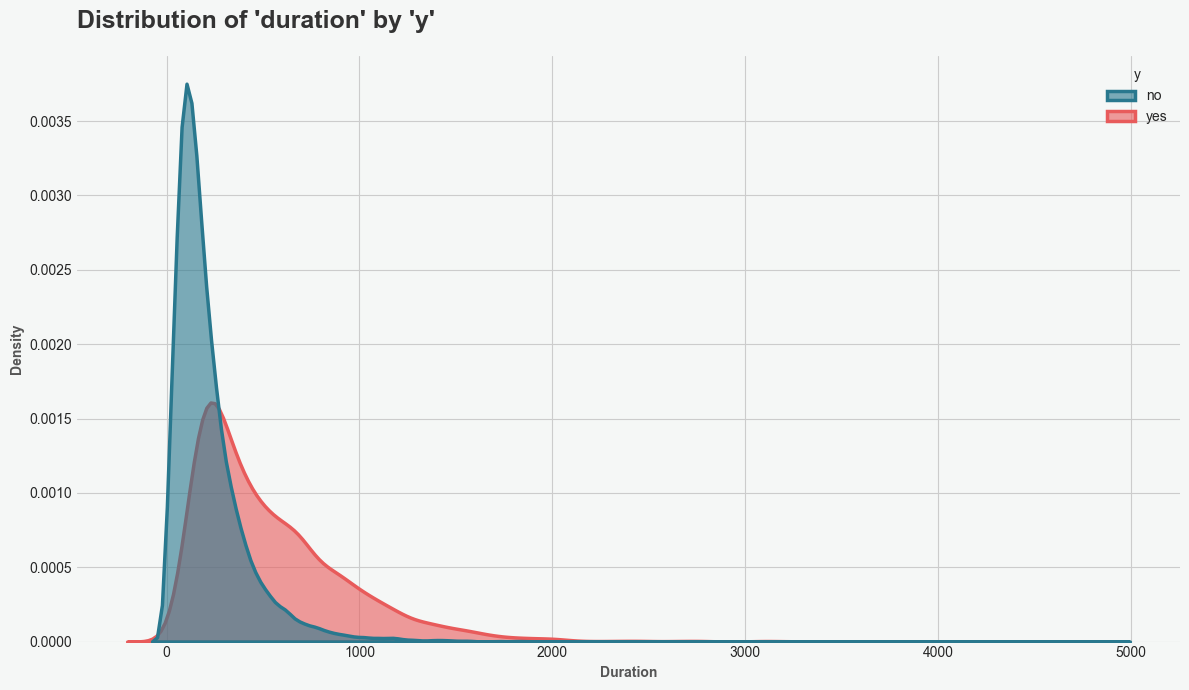

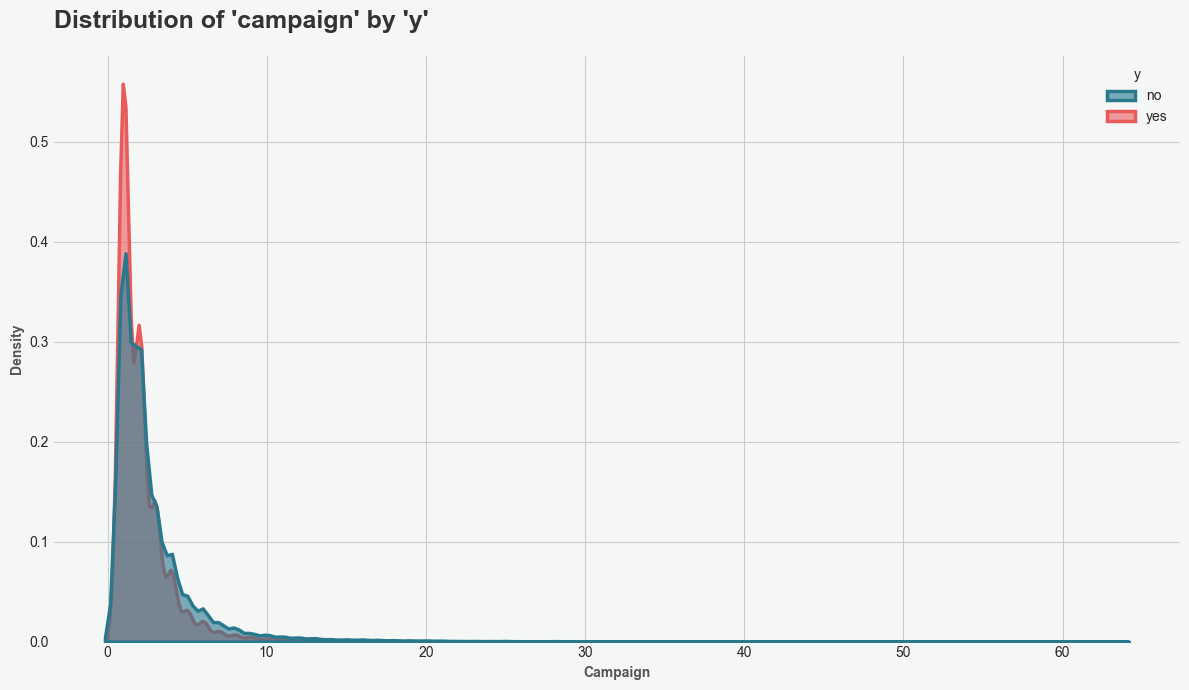

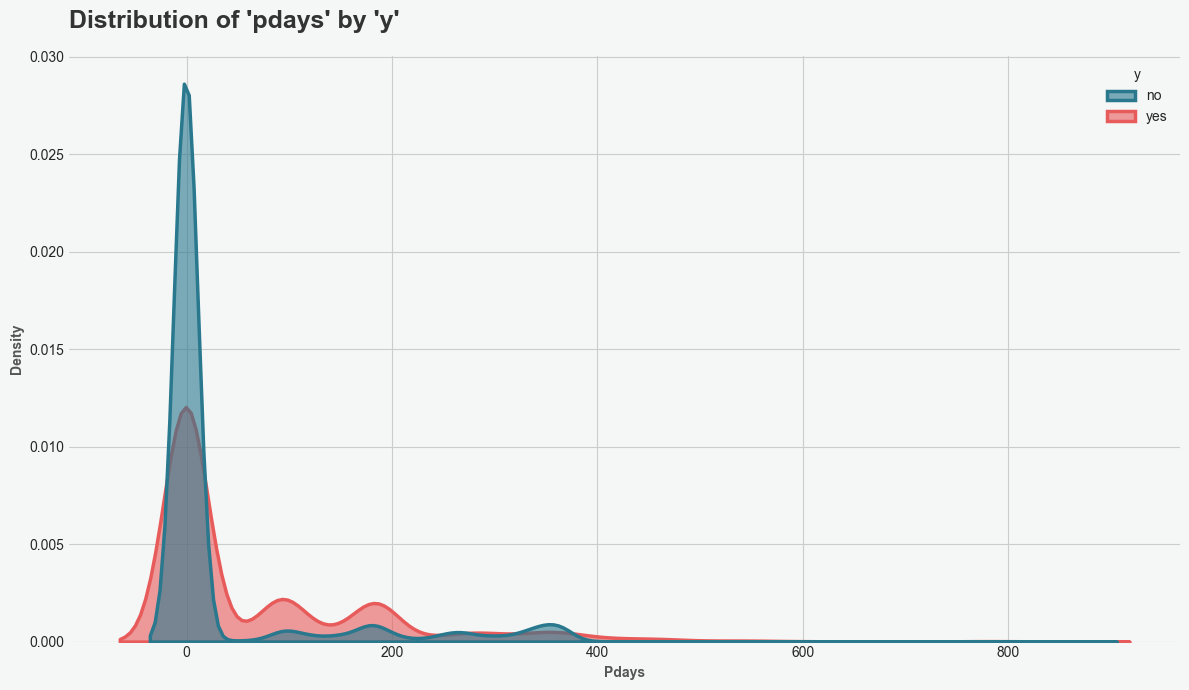

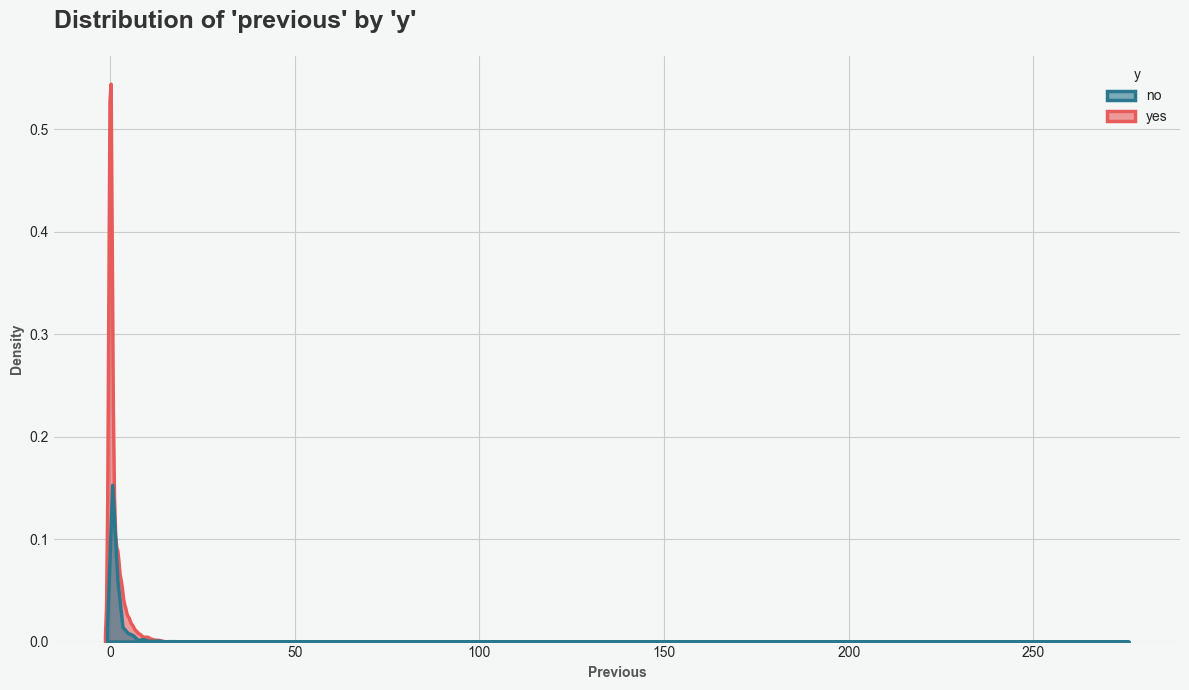

In [ ]:
# Plotting KDE plots for continuous features by target variable
for feat in continuous_features:
    plot_kde_by_target(df, feat, 'y')

- **Data Leakage**
    - The `duration` of the call is highly correlated with the outcome, with longer calls strongly indicating a subscription. However, we known this is a data leak, since the duration is only known *after* the call is made. We will remove this feature from the dataset before modeling.

- **Behavioral Predictors**
    - The number of contacts (`campaign`) appears to be a relevant predictor. Successful outcomes are heavily concentrated in the **first one or two contacts**. The data clearly shows that repeated contacts lead to diminishing returns, with a high number of calls being strongly associated with a negative outcome.<br><br>
    - Similarly, prior engagement (`pdays`) is a positive signal. While most clients have never been contacted before (`pdays = -1`), those who *have* been previously contacted show a higher propensity to subscribe.

- **Demographic Insights**
    - The `age` distribution confirms our findings from the `job` analysis. There is a higher likelihood of subscription among clients at the extremes of the age range: **younger clients (typically students)** and **older clients (typically retired)**.

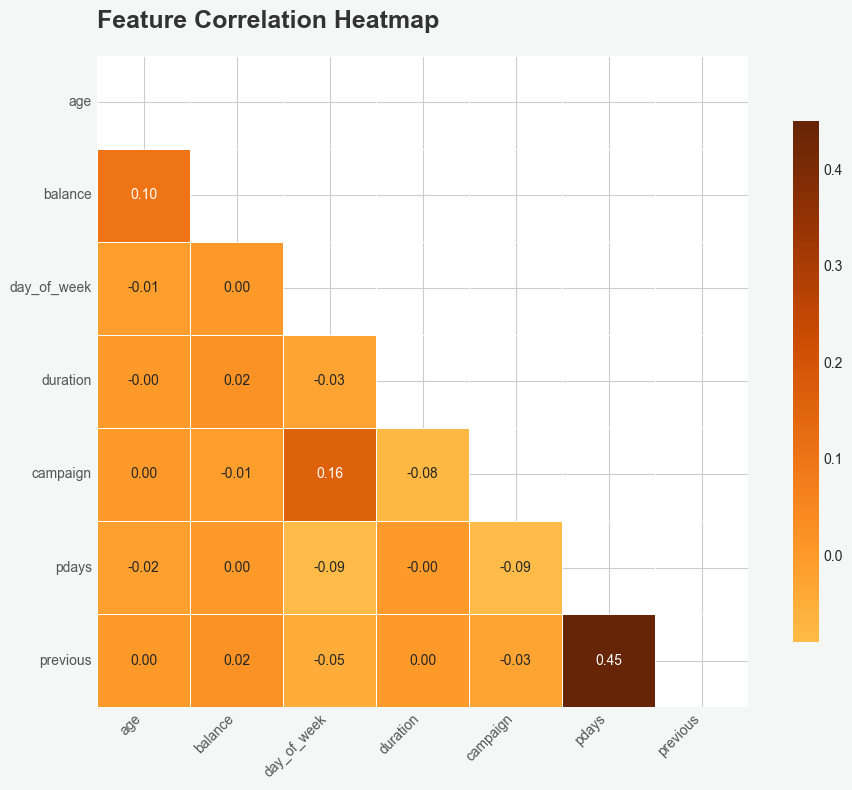

In [ ]:
# Plotting correlation heatmap
plot_correlation_heatmap(df)

- **Moderate Positive Correlation**
    - The most significant correlation is a moderate positive relationship between `pdays` and `previous`. This is expected, because both features are related to past contact history. If a  client has had previous contact (`previous` > 0), then pdays will also have a value other than `-1`. They are measuring a similar underlying concept.<br><br>
- **Absence of Linear Trends**
    - Overall, the correlation heatmap shows that there are no linear trends among continuous features (e.g., *"as age increases, balance increases*). This lack of strong linear relationships suggest that linear models might struggle to find patterns without a significant level of feature engineering. Non-linear models, like Random Forest or Gradient Boosting, might be able to capture more complex relationships between features.

---

---

## Data Pipeline & Preprocessing
In this section, we will start by building a baseline. We will then perform some feature engineering based on our findings and build the data pipeline that will be used to automate and encapsulate all our preprocessing workflow. 

### Baseline

Let's start by building a baseline with a simple Logistic Regression model to evaluate performance. <br><br>
During our EDA, we uncovered that `poutcome` feature has over 80% of missing data. Our first inclination was to drop this feature, due to a high number of missing data. However, given that this feature appears to have important predictive power (64.7% of clients whose previous marketing campaign was a `success` said `yes` to this current campaign), we might want to test performance of a baseline model **with and without** this feature. <br><br>
If including `poutcome` gives us a signifcant performance boost, we will know it is worth it to keep this feature. However, if performance is worse, we will opt for excluding it.

In [57]:
# Creating a copy of the original dataframe for preprocessing and modelling
df_model = df.copy()

# Dropping the 'duration' feature due to data leakage
df_model.drop(columns=['duration'], axis=1, inplace=True)

# Filling missing values in categorical features with 'Unknown'
df_model[categorical_features] = df_model[categorical_features].fillna('unknown')

# Separating features and target variable
X = df_model.drop('y', axis=1)
y = df_model['y'].map({'yes': 1, 'no': 0}) # Encoding target variable as binary

print("--- Features and Target Variable ---")
print("\nFeatures:\n")
print(X.shape)
print('\n')
print(X.head())
print("\nTarget Variable:\n")
print(y.shape)
print('\n')
print(y.head())
print("\n------------------------------------\n")
print("Missing Data Check:\n")
print(df_model.isnull().sum())
print("\n------------------------------------\n")

--- Features and Target Variable ---

Features:

(45211, 15)


   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day_of_week month  campaign  pdays  previous poutcome  
0  unknown            5   may         1     -1         0  unknown  
1  unknown            5   may         1     -1         0  unknown  
2  unknown            5   may         1     -1         0  unknown  
3  unknown            5   may         1     -1         0  unknown  
4  unknown            5   may         1     -1         0  unknown  

Target Variable:

(45211,)


0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int

In [58]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y)
print("--- Train-Test Split ---\n")
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

--- Train-Test Split ---

Training set shape: (36168, 15), (36168,)
Testing set shape: (9043, 15), (9043,)


In [ ]:
# Evaluation function for model performance
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    This function plots a confusion matrix for the given true and predicted labels.
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fig, ax = plt.subplots(figsize=(6, 6))
    fig.set_facecolor('#f5f7f6')

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False,
        annot_kws={"size": 16},
        ax=ax
    )

    ax.set_title(
        f'Confusion Matrix for {model_name}',
        fontsize=18, fontweight='bold', pad=20, loc='left', color='#333333'
    )
    ax.set_xlabel('Predicted Label', fontweight='bold', color='#555555')
    ax.set_ylabel('True Label', fontweight='bold', color='#555555')

    ax.xaxis.set_ticklabels(['No (0)', 'Yes (1)'])
    ax.yaxis.set_ticklabels(['No (0)', 'Yes (1)'])

    plt.tight_layout()
    plt.show()


Categorical Features (without 'poutcome'):
 Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month'],
      dtype='object')

Numerical Features (without 'poutcome'):
 Index(['age', 'balance', 'day_of_week', 'campaign', 'pdays', 'previous'], dtype='object')

------------------------------------


Preprocessor (without 'poutcome'):
 ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month'],
      dtype='object')),
                                ('num', PowerTransformer(),
                                 Index(['age', 'balance', 'day_of_week', 'campaign', 'pdays', 'previous'], dtype='object'))])

------------------------------------


Pipeline (without 'poutcome'):
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                               

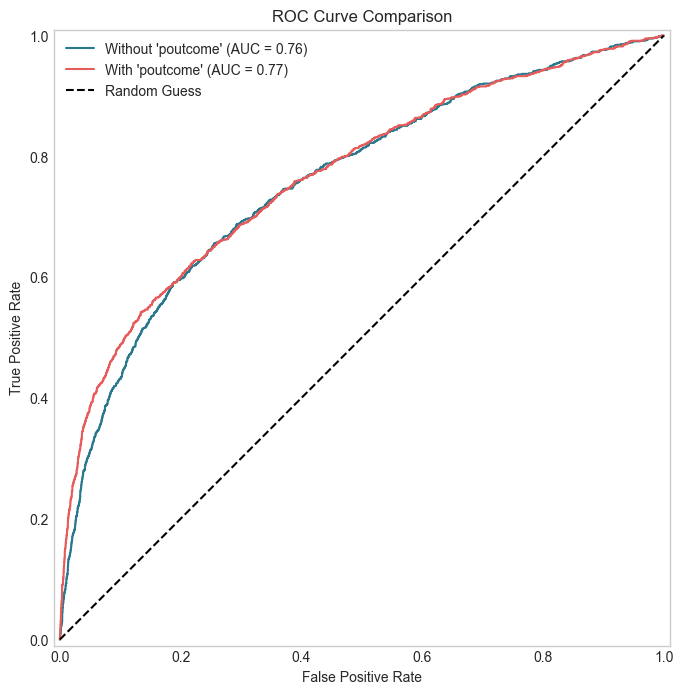

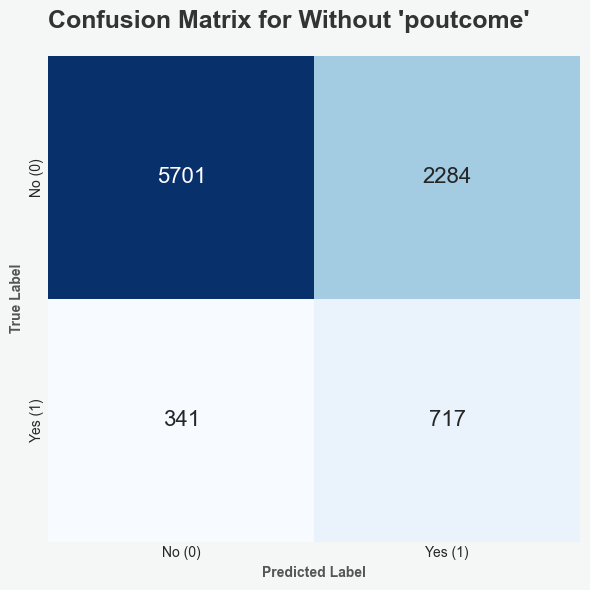

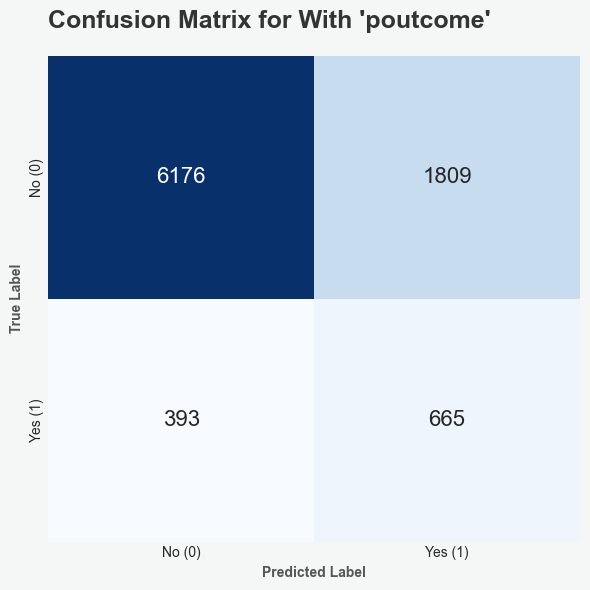


Performance Comparison DataFrame:



,Model,Precision,Recall,F1-Score,ROC AUC
0,Without 'poutcome',0.24,0.68,0.35,0.76
1,With 'poutcome',0.27,0.63,0.38,0.77


In [60]:
# --- Experimenting Baseline Model Without `poutcome` ---
# Dropping `poutcome` feature
X_train_no_poutcome = X_train.drop(columns=['poutcome'], axis=1)
X_test_no_poutcome = X_test.drop(columns=['poutcome'], axis=1)

# Identifying categorical and numerical features for preprocessing
categorical_features_no_poutcome = X_train_no_poutcome.select_dtypes(include=['object']).columns
numerical_features_no_poutcome = X_train_no_poutcome.select_dtypes(include=np.number).columns
print("\nCategorical Features (without 'poutcome'):\n", categorical_features_no_poutcome)
print("\nNumerical Features (without 'poutcome'):\n", numerical_features_no_poutcome)
print("\n------------------------------------\n")

# Creating preprocessor for encoding categorical features and scaling numerical features
preprocessor_no_poutcome = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_no_poutcome),
        ('num', PowerTransformer(method='yeo-johnson'), numerical_features_no_poutcome)
    ])
print("\nPreprocessor (without 'poutcome'):\n", preprocessor_no_poutcome)
print("\n------------------------------------\n")

# Creating a pipeline with SMOTE and Logistic Regression
pipeline_no_poutcome = ImbPipeline(steps=[
    ('preprocessor', preprocessor_no_poutcome),
    ('smote', SMOTE(random_state=seed)),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=seed, max_iter=1000))
])
print("\nPipeline (without 'poutcome'):\n", pipeline_no_poutcome)
print("\n------------------------------------\n")

# Training and evaluating the model without `poutcome`
pipeline_no_poutcome.fit(X_train_no_poutcome, y_train)
y_pred_no_poutcome = pipeline_no_poutcome.predict(X_test_no_poutcome)
y_proba_no_poutcome = pipeline_no_poutcome.predict_proba(X_test_no_poutcome)[:, 1]

# --- Experimenting Baseline Model With `poutcome` ---
# Identifying categorical and numerical features for preprocessing
categorical_features_with_poutcome = X_train.select_dtypes(include=['object']).columns
numerical_features_with_poutcome = X_train.select_dtypes(include=np.number).columns
print("\nCategorical Features (with 'poutcome'):\n", categorical_features_with_poutcome)
print("\nNumerical Features (with 'poutcome'):\n", numerical_features_with_poutcome)
print("\n------------------------------------\n")

# Creating preprocessor for encoding categorical features and scaling numerical features
preprocessor_with_poutcome = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_with_poutcome),
        ('num', PowerTransformer(method='yeo-johnson'), numerical_features_with_poutcome)
    ])
print("\nPreprocessor (with 'poutcome'):\n", preprocessor_with_poutcome)
print("\n------------------------------------\n")

# Creating a pipeline with SMOTE and Logistic Regression
pipeline_with_poutcome = ImbPipeline(steps=[
    ('preprocessor', preprocessor_with_poutcome),
    ('smote', SMOTE(random_state=seed)),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=seed, max_iter=1000))
])
print("\nPipeline (with 'poutcome'):\n", pipeline_with_poutcome)
print("\n------------------------------------\n")

# Training and evaluating the model with `poutcome`
pipeline_with_poutcome.fit(X_train, y_train)
y_pred_with_poutcome = pipeline_with_poutcome.predict(X_test)
y_proba_with_poutcome = pipeline_with_poutcome.predict_proba(X_test)[:, 1]

# --- Performance Comparison ---
print("\n--- Model Performance Comparison ---\n")
print("\nClassification Report (without 'poutcome'):\n")
print(classification_report(y_test, y_pred_no_poutcome, target_names=['no', 'yes']))
print("\nClassification Report (with 'poutcome'):\n")
print(classification_report(y_test, y_pred_with_poutcome, target_names=['no', 'yes']))

# Plotting ROC Curves for both models
fig, ax = plt.subplots(figsize=(8, 8))
RocCurveDisplay.from_predictions(y_test, y_proba_no_poutcome, name="Without 'poutcome'", color='#29788E', ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_with_poutcome, name="With 'poutcome'", color='#E85B5B', ax=ax)
ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')
ax.set_title('ROC Curve Comparison')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
ax.grid()
plt.show()

# Plotting Confusion Matrices for both models
plot_confusion_matrix(y_test, y_pred_no_poutcome, "Without 'poutcome'")
plot_confusion_matrix(y_test, y_pred_with_poutcome, "With 'poutcome'")

# Building a Comparison Dataframe
metrics = {
    'Model': ["Without 'poutcome'", "With 'poutcome'"],
    'Precision': [
        precision_score(y_test, y_pred_no_poutcome),
        precision_score(y_test, y_pred_with_poutcome)
    ],
    'Recall': [
        recall_score(y_test, y_pred_no_poutcome),
        recall_score(y_test, y_pred_with_poutcome)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_no_poutcome),
        f1_score(y_test, y_pred_with_poutcome)
    ],
    'ROC AUC': [
        roc_auc_score(y_test, y_proba_no_poutcome),
        roc_auc_score(y_test, y_proba_with_poutcome)
    ]
}
comparison_df = pd.DataFrame(metrics)
print("\nPerformance Comparison DataFrame:\n")
display(comparison_df.style.format({'Precision': '{:.2f}', 'Recall': '{:.2f}', 'F1-Score': '{:.2f}', 'ROC AUC': '{:.2f}'}))

- **Performance Evaluation**
    - Although the improvement is not massive, the model that includes the `poutcome` feature demonstrated superior performance on our key metrics. It achieved a higher **F1-Score (0.38 vs. 0.35)**, which indicates a better balance between Precision and Recall. While its Recall was slightly lower, its **Precision** was higher, resulting in significantly fewer False Positive errors (1,809 vs. 2,284).

- **Business POV** 
    - From a business perspective, an effective marketing campaign must balance two objectives: maximizing the number of successful sales (**Recall**) while minimizing resources spent on uninterested clients (**Precision**). The **F1-Score** is the ideal metric for this scenario as it measures the overall effectiveness of the model's generated call list by finding a harmony between these two goals. Since the model *with* `poutcome` achieved a higher F1-Score, it provides more business value. Therefore, we will keep this feature for our final model.

### Feature Engineering
We will maintain the `poutcome` feature in the dataset. In this section, we will fill in missing data with the `unknown` label across categories. We will also drop the `duration` feature due to data leakage and re-engineer quasi-categorical features.

In [61]:
# Creating a copy of the model dataframe for feature engineering
df_engineered = df.copy()

# Dropping the `duration` feature due to data leakage
df_engineered.drop(columns=['duration'], axis=1, inplace=True)

# Replacing missing values with `unknown`
df_engineered[categorical_features] = df_engineered[categorical_features].fillna('unknown')

print("\n--- Initial Cleaning Complete ---\n")
print("Feature `duration` dropped and NaNs filled with 'unknown'.\n")
print("Original Dataframe:\n")
display(df.head(5))
print("\nEngineered Dataframe:\n")
display(df_engineered.head(5))
print("\n------------------------------------\n")


--- Initial Cleaning Complete ---

Feature `duration` dropped and NaNs filled with 'unknown'.

Original Dataframe:



,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no



Engineered Dataframe:



,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no



------------------------------------



In [62]:
# Reviewing descriptive statistics for `pdays` and `previous` features 
df[['pdays', 'previous']].describe().T

,count,mean,std,min,25%,50%,75%,max
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


- **EDA Insights**
    - During EDA, we observed that `pdays` and `previous` features have an overwhelming number of instances at the same value (`-1` and `0`). Essentially, these features don't really behave that much as continuous features. <br><br>
    - In an attempt to improve performance, we will engineer these features by transforming them into **binary features** and then dropping the original columns. <br><br>
- **New Features**    
    - Instead of `pdays`, we will create a new feature called `was_previously_contacted` where values other than `-1` will be labeled as `yes`. <br><br>
    - Likewise, we will transform the `previous` feature into a feature called `had_previous_contact`, where values other than `0` will be labeled as `yes`. 

In [63]:
# Transforming `pdays` and `previous` into binary features
df_engineered['was_previously_contacted'] = np.where(df_engineered['pdays'] != -1, 'yes', 'no')
df_engineered['had_previous_contact'] = np.where(df_engineered['previous'] != 0, 'yes', 'no')
df_engineered.drop(columns=['pdays', 'previous'], axis=1, inplace=True)
print("\n--- Engineering `pdays` and `previous` into binary features and dropping original columns ---\n")
print("Original Dataframe:\n")
display(df[['pdays', 'previous']].head(5))
print("\nEngineered Dataframe:\n")
display(df_engineered[['was_previously_contacted', 'had_previous_contact']].head(5))
print("\n------------------------------------\n")


--- Engineering `pdays` and `previous` into binary features and dropping original columns ---

Original Dataframe:



,pdays,previous
0,-1,0
1,-1,0
2,-1,0
3,-1,0
4,-1,0



Engineered Dataframe:



,was_previously_contacted,had_previous_contact
0,no,no
1,no,no
2,no,no
3,no,no
4,no,no



------------------------------------



- **Dealing with Mislabeled Features**
    - Our EDA also revealed that the feature `day_of_week` is misleading, as it clearly refers to the day of the month. We will rename it to a more accurate designation. We will also stop treating it as a continuous feature and normalizing it within the pipeline. Instead, we will handle it as a **categorical feature**. The idea is to convert it to a string type and allow the model to learn the importance of specific days without assuming any ordered relationship between them.

In [64]:
# Renaming `day_of_week` to `day_of_month` and treating it as a categorical feature
df_engineered.rename(columns={'day_of_week': 'day_of_month'}, inplace=True)
df_engineered['day_of_month'] = df_engineered['day_of_month'].astype('object')
print("\n--- Renaming `day_of_week` to `day_of_month` and converting to categorical feature ---\n")
print("Original Dataframe:\n")
print("Data Type:", df['day_of_week'].dtype)
display(df[['day_of_week']].head(5))
print("\nEngineered Dataframe:\n")
print("Data Type:", df_engineered['day_of_month'].dtype)
display(df_engineered[['day_of_month']].head(5))
print("\n------------------------------------\n")


--- Renaming `day_of_week` to `day_of_month` and converting to categorical feature ---

Original Dataframe:

Data Type: int64


,day_of_week
0,5
1,5
2,5
3,5
4,5



Engineered Dataframe:

Data Type: object


,day_of_month
0,5
1,5
2,5
3,5
4,5



------------------------------------



Before moving on to the next phase, we can run a quick sanity check by using our `describe_df` function to see if the post-engineered dataframe is how we initially planned.

In [65]:
# Checking the engineered dataframe
describe_df(df_engineered)


DataFrame shape: (45211, 16)

45,211 samples

16 attributes

Categorical Features: 
job, marital, education, default, housing, loan, contact, day_of_month, month, poutcome, y, was_previously_contacted, had_previous_contact

Continuous Features: 
age, balance, campaign

Binary (0 or 1) Features: 
None

Data Types: 
age                          int64
job                         object
marital                     object
education                   object
default                     object
balance                      int64
housing                     object
loan                        object
contact                     object
day_of_month                object
month                       object
campaign                     int64
poutcome                    object
y                           object
was_previously_contacted    object
had_previous_contact        object
dtype: object

Missing Data Percentage: 
age                         0.0%
job                         0.0%
marital         

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0



DataFrame Head: 



,age,job,marital,education,default,balance,housing,loan,contact,day_of_month,month,campaign,poutcome,y,was_previously_contacted,had_previous_contact
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,unknown,no,no,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,unknown,no,no,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,unknown,no,no,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,unknown,no,no,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,unknown,no,no,no



DataFrame Tail: 



,age,job,marital,education,default,balance,housing,loan,contact,day_of_month,month,campaign,poutcome,y,was_previously_contacted,had_previous_contact
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,unknown,yes,no,no
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,unknown,yes,no,no
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,success,yes,yes,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,unknown,no,no,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,2,other,no,yes,yes


---

---

## Modeling
With our data fully preprocessed and engineered, we now proceed to the modeling phase. In this section, we'll train and evaluate a variety of classification algorithms to find the best performer for our business problem. Each model will be evaluated using a stratified cross-validation strategy to ensure fair and robust comparison.

In [66]:
# Removing `y` from categorical_features list
categorical_features.remove('y')

# Separating features and target variable
X_engineered = df_engineered.drop('y', axis=1)
y_engineered = df_engineered['y'].map({'yes': 1, 'no': 0}) # Encoding target variable as binary

print("--- Features and Target Variable ---")
print("\nFeatures:\n")
print(X_engineered.shape)
print('\n')
print(X_engineered.head())
print("\nTarget Variable:\n")
print(y_engineered.shape)
print('\n')
print(y_engineered.head())
print("\n------------------------------------\n")
print("Missing Data Check:\n")
print(df_engineered.isnull().sum())
print("\n------------------------------------\n")

--- Features and Target Variable ---

Features:

(45211, 15)


   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact day_of_month month  campaign poutcome was_previously_contacted  \
0  unknown            5   may         1  unknown                       no   
1  unknown            5   may         1  unknown                       no   
2  unknown            5   may         1  unknown                       no   
3  unknown            5   may         1  unknown                       no   
4  unknown            5   may         1  unknown                       no   

  had_previous_contact  
0   

In [67]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y_engineered, test_size=0.2, random_state=seed, stratify=y_engineered)

print("--- Train-Test Split ---\n")
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

--- Train-Test Split ---

Training set shape: (36168, 15), (36168,)
Testing set shape: (9043, 15), (9043,)



Categorical Features (Engineered):
 Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'day_of_month', 'month', 'poutcome', 'was_previously_contacted',
       'had_previous_contact'],
      dtype='object')

Numerical Features (Engineered):
 Index(['age', 'balance', 'campaign'], dtype='object')

------------------------------------


Preprocessor (Engineered):
 ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'day_of_month', 'month', 'poutcome', 'was_previously_contacted',
       'had_previous_contact'],
      dtype='object')),
                                ('num', PowerTransformer(),
                                 Index(['age', 'balance', 'campaign'], dtype='object'))])

------------------------------------


--- Model Evaluation with Cross-Validation ---



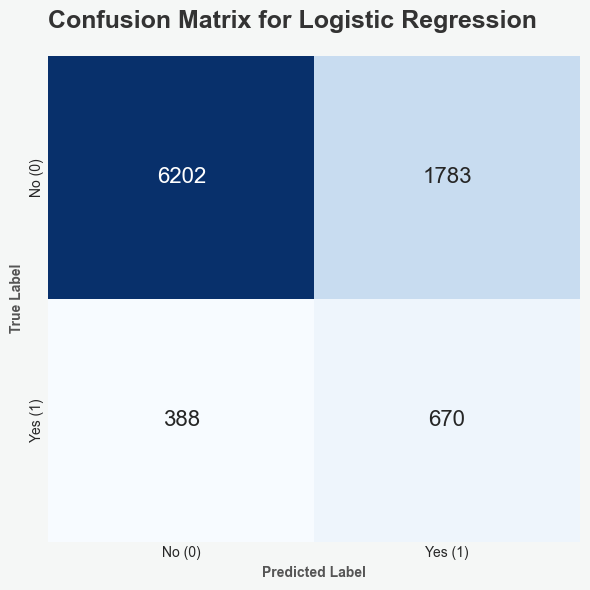

Logistic Regression evaluated in 3.03 seconds.


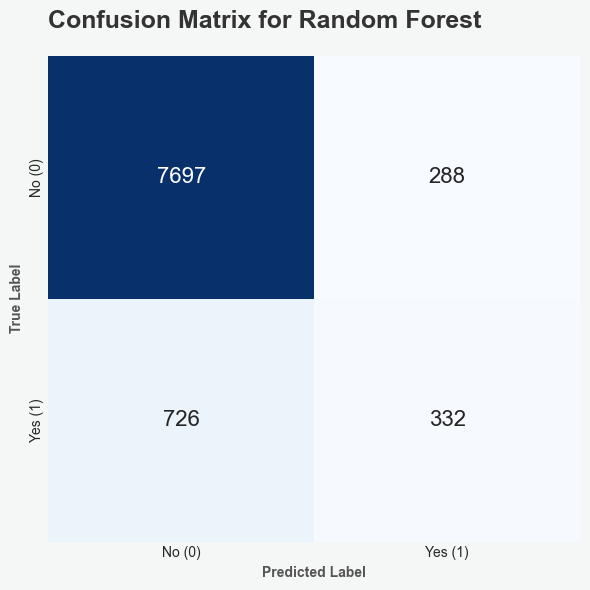

Random Forest evaluated in 106.48 seconds.


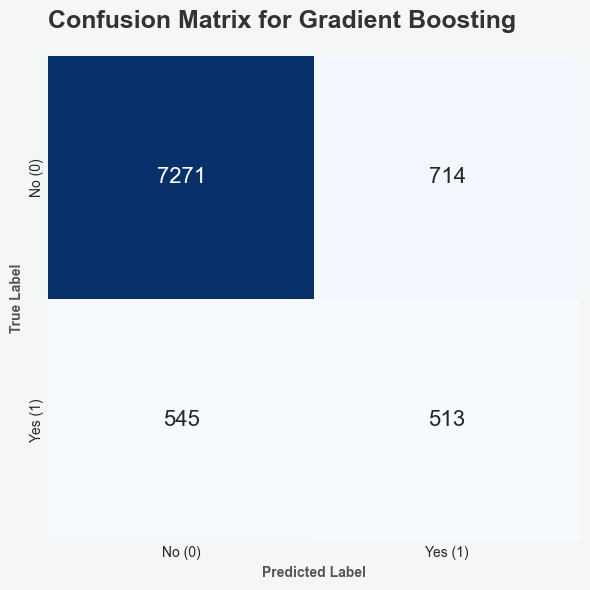

Gradient Boosting evaluated in 38.54 seconds.


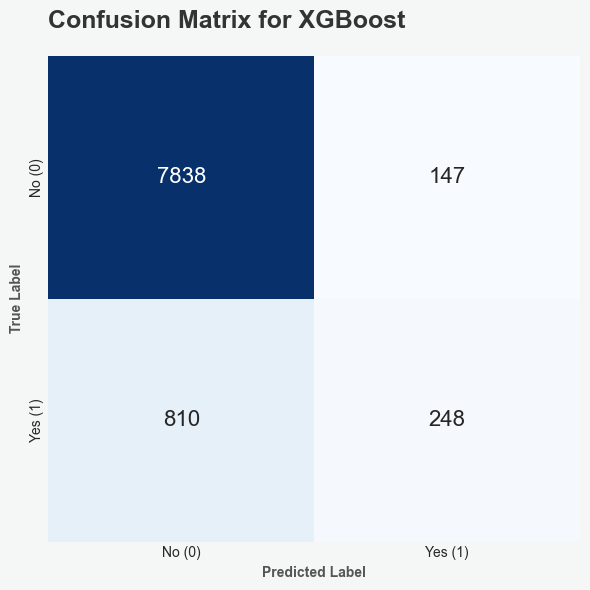

XGBoost evaluated in 4.76 seconds.


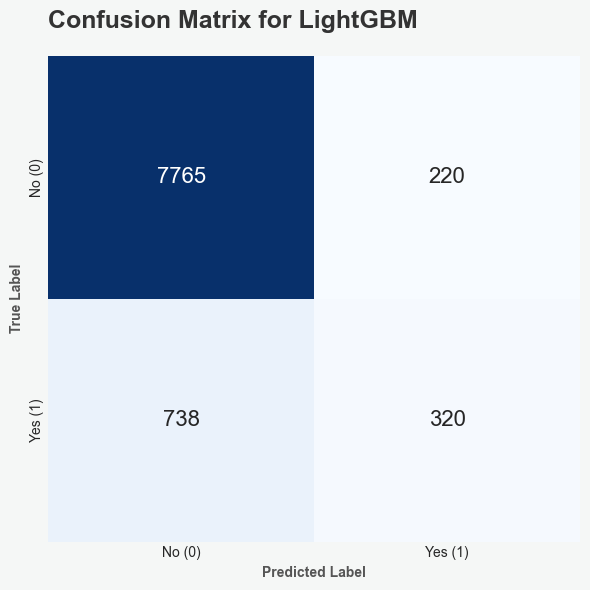

LightGBM evaluated in 5.49 seconds.

Cross-Validation Results:



,Model,Precision,Recall,F1-Score,ROC AUC,Training Time (s)
0,Logistic Regression,0.27,0.63,0.38,0.76,3.03
1,Random Forest,0.52,0.30,0.38,0.78,106.48
2,Gradient Boosting,0.42,0.45,0.43,0.77,38.54
3,XGBoost,0.60,0.22,0.33,0.78,4.76
4,LightGBM,0.56,0.29,0.38,0.79,5.49


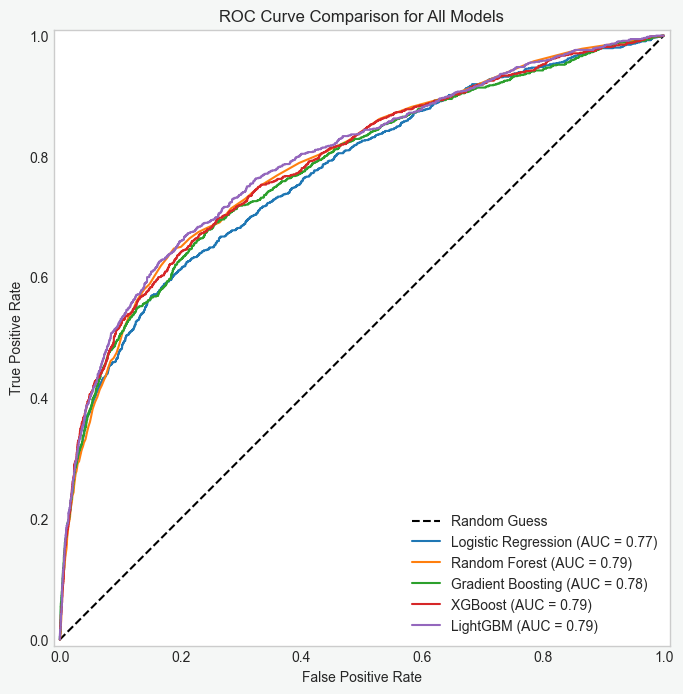

In [68]:
# --- Model Building and Evaluation ---
# Identifying categorical and numerical features for preprocessing
categorical_features_engineered = X_train.select_dtypes(include=['object']).columns
numerical_features_engineered = X_train.select_dtypes(include=np.number).columns
print("\nCategorical Features (Engineered):\n", categorical_features_engineered)
print("\nNumerical Features (Engineered):\n", numerical_features_engineered)
print("\n------------------------------------\n")

# Creating preprocessor for encoding categorical features and scaling numerical features
preprocessor_engineered = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_engineered),
        ('num', PowerTransformer(method='yeo-johnson'), numerical_features_engineered)
    ])
print("\nPreprocessor (Engineered):\n", preprocessor_engineered)
print("\n------------------------------------\n")

# Defining models to compare
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=seed, max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=seed),
    "Gradient Boosting": GradientBoostingClassifier(random_state=seed),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=seed),
    "LightGBM": LGBMClassifier(random_state=seed, verbose=-1)
}

# Defining Cross-Validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Evaluating each model using cross-validation
results = []
roc_plot_data = []

print("\n--- Model Evaluation with Cross-Validation ---\n")
for model_name, model in models.items():
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor_engineered),
        ('smote', SMOTE(random_state=seed)),
        ('classifier', model)
    ])

    start_time = time.time()

    cv_results = cross_validate(
        pipeline, X_train, y_train,
        cv=cv,
        scoring=['precision', 'recall', 'f1', 'roc_auc'],
        return_train_score=False)

    end_time = time.time()
    training_time = end_time - start_time

    # Store results
    results.append({
        'Model': model_name,
        'Precision': np.mean(cv_results['test_precision']),
        'Recall': np.mean(cv_results['test_recall']),
        'F1-Score': np.mean(cv_results['test_f1']),
        'ROC AUC': np.mean(cv_results['test_roc_auc']),
        'Training Time (s)': training_time})

    # Fit the model to get ROC curve data
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = pipeline.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, model_name)
    roc_plot_data.append({
        'model_name': model_name,
        'y_true': y_test,
        'y_proba': pipeline.predict_proba(X_test)[:, 1]
    })
    print(f"{model_name} evaluated in {training_time:.2f} seconds.")

# Creating a results dataframe
results_df = pd.DataFrame(results)
print("\nCross-Validation Results:\n")
display(results_df.style.format({'Precision': '{:.2f}', 'Recall': '{:.2f}', 'F1-Score': '{:.2f}',
                                 'ROC AUC': '{:.2f}', 'Training Time (s)': '{:.2f}'}))

# Plotting ROC Curves for all models
fig, ax = plt.subplots(figsize=(10, 8))
fig.set_facecolor('#f5f7f6')
ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')
for data in roc_plot_data:
    RocCurveDisplay.from_predictions(
        data['y_true'], data['y_proba'], name=data['model_name'], ax=ax)
plt.title('ROC Curve Comparison for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

- The Gradient Boosting has the highest F1 Score, making it the most balanced model of the set in regards to Recall and Precision. However, it is one of the slowest models in regards to training time.<br><br>
- The XGBoost achieved the highest Precision at 0.60. It has the fewest False Positiver errors, only 147. In practice, this model helps us avoid calling clients who would be more likely to say *no*, but it also misses the most potential customers, given the lowest Recall (meaning a higher number of False Negatives). <br><br>
- The LightGBM model has the highest ROC AUC score, which in practice means the model is best at ranking customers from most to least likely to subscribe. It has has a good F1-Score.

### Tuning Models
In order to achieve higher performance, we will fine-tune the LightGBM and XGBoost models with Optuna. The goal is to find the ideal set of hyperparameters to increase performance. Although the Gradient Boosting model have us the highest F1-Score, it was also one of the slowest models. By fine-tuning the LightGBM and XGBoost, we aim at surpassing the Gradient Boosting model at a lower cost.

In [69]:
def objective_lgbm(trial):
    """
    This is the objective function that Optuna will optimize.
    A 'trial' is a single run of the model with a specific set of hyperparameters.
    """
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000, step=20),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor_engineered),
        ('smote', SMOTE(random_state=seed)),
        ('classifier', LGBMClassifier(**params))
    ])

    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    score = cross_val_score(
        pipeline, X_train, y_train, cv=cv_strategy, scoring='f1', n_jobs=-1
    ).mean()
    return score

study_lgbm = optuna.create_study(direction='maximize', study_name='LGBM Classifier Optimization')
print("\n--- Starting Hyperparameter Optimization for LightGBM ---\n")
study_lgbm.optimize(objective_lgbm, n_trials=100, show_progress_bar=True)
print("\n--- Hyperparameter Optimization Complete ---\n")
print("Best trial:")
trial = study_lgbm.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-09-16 19:24:59,807] A new study created in memory with name: LGBM Classifier Optimization



--- Starting Hyperparameter Optimization for LightGBM ---



Best trial: 0. Best value: 0.354034:   1%|          | 1/100 [03:21<5:33:04, 201.86s/it]

[I 2025-09-16 19:28:21,672] Trial 0 finished with value: 0.3540343592253018 and parameters: {'n_estimators': 2000, 'learning_rate': 0.14375029681578794, 'num_leaves': 500, 'max_depth': 12, 'min_child_samples': 39, 'subsample': 0.6417816153031995, 'colsample_bytree': 0.6067933156559204, 'reg_alpha': 1.3818036142649898e-07, 'reg_lambda': 5.189917246351253e-07}. Best is trial 0 with value: 0.3540343592253018.


Best trial: 1. Best value: 0.360631:   2%|▏         | 2/100 [03:29<2:22:59, 87.54s/it] 

[I 2025-09-16 19:28:29,193] Trial 1 finished with value: 0.3606307317534324 and parameters: {'n_estimators': 700, 'learning_rate': 0.1196976415985506, 'num_leaves': 880, 'max_depth': 5, 'min_child_samples': 125, 'subsample': 0.6491331373259933, 'colsample_bytree': 0.7716456046366084, 'reg_alpha': 2.498906002211727e-07, 'reg_lambda': 6.216877885285744}. Best is trial 1 with value: 0.3606307317534324.


Best trial: 1. Best value: 0.360631:   3%|▎         | 3/100 [03:49<1:32:03, 56.94s/it]

[I 2025-09-16 19:28:49,712] Trial 2 finished with value: 0.3492825278770932 and parameters: {'n_estimators': 1500, 'learning_rate': 0.022155257192552694, 'num_leaves': 480, 'max_depth': 7, 'min_child_samples': 95, 'subsample': 0.6157932082487831, 'colsample_bytree': 0.8181290821779695, 'reg_alpha': 4.124725121788372, 'reg_lambda': 3.701218376466825e-05}. Best is trial 1 with value: 0.3606307317534324.


Best trial: 1. Best value: 0.360631:   4%|▍         | 4/100 [04:11<1:08:41, 42.93s/it]

[I 2025-09-16 19:29:11,169] Trial 3 finished with value: 0.35845614367742484 and parameters: {'n_estimators': 700, 'learning_rate': 0.15134906129179576, 'num_leaves': 620, 'max_depth': 12, 'min_child_samples': 165, 'subsample': 0.6003054300554304, 'colsample_bytree': 0.8946444567690156, 'reg_alpha': 4.292096398079292e-08, 'reg_lambda': 0.0014931129339135595}. Best is trial 1 with value: 0.3606307317534324.


Best trial: 1. Best value: 0.360631:   5%|▌         | 5/100 [04:45<1:02:43, 39.61s/it]

[I 2025-09-16 19:29:44,899] Trial 4 finished with value: 0.35360100302480896 and parameters: {'n_estimators': 1400, 'learning_rate': 0.16747128946878984, 'num_leaves': 2060, 'max_depth': 8, 'min_child_samples': 135, 'subsample': 0.8632876977551023, 'colsample_bytree': 0.8741264000477884, 'reg_alpha': 0.0011605723760328911, 'reg_lambda': 0.4372549452649395}. Best is trial 1 with value: 0.3606307317534324.


Best trial: 5. Best value: 0.412109:   6%|▌         | 6/100 [05:22<1:00:58, 38.92s/it]

[I 2025-09-16 19:30:22,472] Trial 5 finished with value: 0.4121092274485245 and parameters: {'n_estimators': 500, 'learning_rate': 0.014562565097287225, 'num_leaves': 2800, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.8616474280028409, 'colsample_bytree': 0.9480201419537508, 'reg_alpha': 0.00402565505746664, 'reg_lambda': 1.983938231210734e-06}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:   7%|▋         | 7/100 [06:31<1:15:23, 48.64s/it]

[I 2025-09-16 19:31:31,126] Trial 6 finished with value: 0.35501779688135804 and parameters: {'n_estimators': 1500, 'learning_rate': 0.16385527042693004, 'num_leaves': 2620, 'max_depth': 10, 'min_child_samples': 64, 'subsample': 0.6630324394363006, 'colsample_bytree': 0.8612046108885621, 'reg_alpha': 0.00024293999371271903, 'reg_lambda': 2.9031612313587583}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:   8%|▊         | 8/100 [06:49<59:39, 38.91s/it]  

[I 2025-09-16 19:31:49,184] Trial 7 finished with value: 0.36191504029016375 and parameters: {'n_estimators': 1700, 'learning_rate': 0.2012361561993437, 'num_leaves': 2600, 'max_depth': 4, 'min_child_samples': 40, 'subsample': 0.6072502493315309, 'colsample_bytree': 0.6324543430746492, 'reg_alpha': 3.392702478376279e-05, 'reg_lambda': 1.92146529081408e-05}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:   9%|▉         | 9/100 [09:57<2:09:31, 85.40s/it]

[I 2025-09-16 19:34:56,834] Trial 8 finished with value: 0.3510864293740711 and parameters: {'n_estimators': 1400, 'learning_rate': 0.055182100648122234, 'num_leaves': 1080, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.6916475683718059, 'colsample_bytree': 0.9490331884157979, 'reg_alpha': 5.623357261641144e-06, 'reg_lambda': 3.6319421932283683e-07}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  10%|█         | 10/100 [10:30<1:44:11, 69.46s/it]

[I 2025-09-16 19:35:30,584] Trial 9 finished with value: 0.38329154812963184 and parameters: {'n_estimators': 600, 'learning_rate': 0.02109622206316228, 'num_leaves': 1360, 'max_depth': 9, 'min_child_samples': 41, 'subsample': 0.6199249775114913, 'colsample_bytree': 0.9957115710175675, 'reg_alpha': 2.7218435595710146e-06, 'reg_lambda': 9.939883299198569e-07}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  11%|█         | 11/100 [10:35<1:13:40, 49.67s/it]

[I 2025-09-16 19:35:35,376] Trial 10 finished with value: 0.3636054596110653 and parameters: {'n_estimators': 200, 'learning_rate': 0.29108866027394975, 'num_leaves': 2980, 'max_depth': 6, 'min_child_samples': 197, 'subsample': 0.9882372923746179, 'colsample_bytree': 0.7468899381423617, 'reg_alpha': 0.0351529374480309, 'reg_lambda': 2.362423068211244e-08}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  12%|█▏        | 12/100 [11:13<1:07:47, 46.23s/it]

[I 2025-09-16 19:36:13,733] Trial 11 finished with value: 0.3606083080223673 and parameters: {'n_estimators': 500, 'learning_rate': 0.06738397022772433, 'num_leaves': 1600, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.7977878305876258, 'colsample_bytree': 0.9774547966250602, 'reg_alpha': 0.018768615876717912, 'reg_lambda': 0.0016369743138614195}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  13%|█▎        | 13/100 [12:09<1:11:06, 49.04s/it]

[I 2025-09-16 19:37:09,239] Trial 12 finished with value: 0.36604036716435917 and parameters: {'n_estimators': 1000, 'learning_rate': 0.015867487309587845, 'num_leaves': 1740, 'max_depth': 10, 'min_child_samples': 69, 'subsample': 0.819969589095258, 'colsample_bytree': 0.9946162198113564, 'reg_alpha': 4.301416805686932e-06, 'reg_lambda': 2.2252956526517787e-06}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  14%|█▍        | 14/100 [12:21<54:23, 37.94s/it]  

[I 2025-09-16 19:37:21,550] Trial 13 finished with value: 0.3636885882690458 and parameters: {'n_estimators': 200, 'learning_rate': 0.0788133529027149, 'num_leaves': 1180, 'max_depth': 10, 'min_child_samples': 35, 'subsample': 0.9143346727222548, 'colsample_bytree': 0.9301357475101932, 'reg_alpha': 0.01153993977847027, 'reg_lambda': 4.820929526426848e-08}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  15%|█▌        | 15/100 [12:49<49:20, 34.83s/it]

[I 2025-09-16 19:37:49,159] Trial 14 finished with value: 0.35755501693282177 and parameters: {'n_estimators': 900, 'learning_rate': 0.09683977096747268, 'num_leaves': 2120, 'max_depth': 8, 'min_child_samples': 76, 'subsample': 0.732479182752464, 'colsample_bytree': 0.6966872256493958, 'reg_alpha': 0.5353372908080501, 'reg_lambda': 8.798536616905965e-05}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  16%|█▌        | 16/100 [13:17<46:07, 32.95s/it]

[I 2025-09-16 19:38:17,736] Trial 15 finished with value: 0.3626290663911961 and parameters: {'n_estimators': 500, 'learning_rate': 0.042860506746778215, 'num_leaves': 140, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.7545116366967988, 'colsample_bytree': 0.9216744034823223, 'reg_alpha': 0.00039050605587832203, 'reg_lambda': 3.867146218442792e-06}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  17%|█▋        | 17/100 [13:21<33:29, 24.21s/it]

[I 2025-09-16 19:38:21,615] Trial 16 finished with value: 0.3511932377636088 and parameters: {'n_estimators': 400, 'learning_rate': 0.2275829856136524, 'num_leaves': 2040, 'max_depth': 3, 'min_child_samples': 50, 'subsample': 0.9176316565176864, 'colsample_bytree': 0.9989381755496838, 'reg_alpha': 7.539556095216507e-06, 'reg_lambda': 0.021139043162138035}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  18%|█▊        | 18/100 [14:02<39:44, 29.08s/it]

[I 2025-09-16 19:39:02,031] Trial 17 finished with value: 0.3836922482932893 and parameters: {'n_estimators': 800, 'learning_rate': 0.012908854198869585, 'num_leaves': 1360, 'max_depth': 11, 'min_child_samples': 104, 'subsample': 0.8578372293761874, 'colsample_bytree': 0.8369135214604657, 'reg_alpha': 9.544742615585499e-07, 'reg_lambda': 1.0294611749906299e-08}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  19%|█▉        | 19/100 [14:57<49:42, 36.82s/it]

[I 2025-09-16 19:39:56,901] Trial 18 finished with value: 0.35959157792728685 and parameters: {'n_estimators': 1200, 'learning_rate': 0.10445885007543193, 'num_leaves': 2460, 'max_depth': 11, 'min_child_samples': 111, 'subsample': 0.8778853005552368, 'colsample_bytree': 0.8132041428314108, 'reg_alpha': 1.5501998334466902e-08, 'reg_lambda': 1.530305408577924e-08}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  20%|██        | 20/100 [15:34<49:22, 37.03s/it]

[I 2025-09-16 19:40:34,414] Trial 19 finished with value: 0.3465350326613034 and parameters: {'n_estimators': 900, 'learning_rate': 0.29961666294065104, 'num_leaves': 2920, 'max_depth': 11, 'min_child_samples': 153, 'subsample': 0.990687773218133, 'colsample_bytree': 0.8506185261836758, 'reg_alpha': 0.0031568676621779204, 'reg_lambda': 1.5543990736328513e-07}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  21%|██        | 21/100 [16:29<55:51, 42.42s/it]

[I 2025-09-16 19:41:29,393] Trial 20 finished with value: 0.3620342954742971 and parameters: {'n_estimators': 1100, 'learning_rate': 0.04924691344621008, 'num_leaves': 1700, 'max_depth': 11, 'min_child_samples': 89, 'subsample': 0.8195202815650388, 'colsample_bytree': 0.7168455659841128, 'reg_alpha': 0.1830777501072362, 'reg_lambda': 6.918943177785756e-06}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  22%|██▏       | 22/100 [17:17<57:09, 43.96s/it]

[I 2025-09-16 19:42:16,962] Trial 21 finished with value: 0.3984658849250766 and parameters: {'n_estimators': 700, 'learning_rate': 0.013121879905356586, 'num_leaves': 1300, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.870667366676028, 'colsample_bytree': 0.9669009993072918, 'reg_alpha': 1.0375316209191696e-06, 'reg_lambda': 8.608132645603158e-07}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  23%|██▎       | 23/100 [17:46<50:37, 39.45s/it]

[I 2025-09-16 19:42:45,877] Trial 22 finished with value: 0.40941720847713414 and parameters: {'n_estimators': 800, 'learning_rate': 0.012123626965444114, 'num_leaves': 1380, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.8744790044006578, 'colsample_bytree': 0.9530285018483833, 'reg_alpha': 4.291943063229049e-05, 'reg_lambda': 6.373232384369973e-08}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  24%|██▍       | 24/100 [17:57<39:18, 31.03s/it]

[I 2025-09-16 19:42:57,279] Trial 23 finished with value: 0.37508353640796094 and parameters: {'n_estimators': 400, 'learning_rate': 0.04208216942274435, 'num_leaves': 840, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.94330304483023, 'colsample_bytree': 0.9498885433443647, 'reg_alpha': 7.399209657081956e-05, 'reg_lambda': 1.4241953499603314e-07}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  25%|██▌       | 25/100 [18:12<32:47, 26.23s/it]

[I 2025-09-16 19:43:12,304] Trial 24 finished with value: 0.3604216751447244 and parameters: {'n_estimators': 700, 'learning_rate': 0.07746009998844973, 'num_leaves': 1420, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.8928316230626295, 'colsample_bytree': 0.9056281484029507, 'reg_alpha': 7.196503411147931e-05, 'reg_lambda': 0.0005413609070414073}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  26%|██▌       | 26/100 [18:24<27:02, 21.93s/it]

[I 2025-09-16 19:43:24,190] Trial 25 finished with value: 0.39989649068535044 and parameters: {'n_estimators': 300, 'learning_rate': 0.03289476225080805, 'num_leaves': 1880, 'max_depth': 8, 'min_child_samples': 55, 'subsample': 0.8399832368653253, 'colsample_bytree': 0.9585207203864953, 'reg_alpha': 1.8111627510161498e-05, 'reg_lambda': 8.177103811494526e-08}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  27%|██▋       | 27/100 [18:33<22:04, 18.15s/it]

[I 2025-09-16 19:43:33,523] Trial 26 finished with value: 0.3945647403934941 and parameters: {'n_estimators': 300, 'learning_rate': 0.03743872200280045, 'num_leaves': 2240, 'max_depth': 7, 'min_child_samples': 56, 'subsample': 0.7820181191958346, 'colsample_bytree': 0.8915595249073704, 'reg_alpha': 0.0026722800998810778, 'reg_lambda': 7.446802492575329e-08}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  28%|██▊       | 28/100 [18:42<18:22, 15.31s/it]

[I 2025-09-16 19:43:42,218] Trial 27 finished with value: 0.3571674036302707 and parameters: {'n_estimators': 400, 'learning_rate': 0.09197257759399037, 'num_leaves': 2320, 'max_depth': 6, 'min_child_samples': 81, 'subsample': 0.8411874361117087, 'colsample_bytree': 0.9364553165729664, 'reg_alpha': 2.2711958899228182e-05, 'reg_lambda': 5.919690106307948e-06}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  29%|██▉       | 29/100 [19:02<19:52, 16.80s/it]

[I 2025-09-16 19:44:02,497] Trial 28 finished with value: 0.3665880397166653 and parameters: {'n_estimators': 500, 'learning_rate': 0.12232557663764791, 'num_leaves': 1740, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.9425456669440123, 'colsample_bytree': 0.96294680760785, 'reg_alpha': 0.00041114302133120166, 'reg_lambda': 1.8860067696139113e-07}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  30%|███       | 30/100 [19:29<23:02, 19.75s/it]

[I 2025-09-16 19:44:29,125] Trial 29 finished with value: 0.3512593560000356 and parameters: {'n_estimators': 1900, 'learning_rate': 0.2591866514123859, 'num_leaves': 1900, 'max_depth': 5, 'min_child_samples': 54, 'subsample': 0.7668184892882802, 'colsample_bytree': 0.9138799705681674, 'reg_alpha': 0.00013457604885019992, 'reg_lambda': 6.413455679231049e-07}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  31%|███       | 31/100 [19:46<21:45, 18.92s/it]

[I 2025-09-16 19:44:46,121] Trial 30 finished with value: 0.36524400808837376 and parameters: {'n_estimators': 300, 'learning_rate': 0.06258549189602126, 'num_leaves': 2700, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.828915341224647, 'colsample_bytree': 0.8873234871694902, 'reg_alpha': 0.001093196353584572, 'reg_lambda': 7.486563040505412e-05}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  32%|███▏      | 32/100 [20:20<26:31, 23.40s/it]

[I 2025-09-16 19:45:19,973] Trial 31 finished with value: 0.3643294460666427 and parameters: {'n_estimators': 600, 'learning_rate': 0.035066195872967026, 'num_leaves': 1160, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.9036177766976802, 'colsample_bytree': 0.9655595414052965, 'reg_alpha': 5.940103877059974e-07, 'reg_lambda': 6.458780387990196e-07}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  33%|███▎      | 33/100 [21:03<32:44, 29.32s/it]

[I 2025-09-16 19:46:03,086] Trial 32 finished with value: 0.3893151476612597 and parameters: {'n_estimators': 800, 'learning_rate': 0.013053579132003777, 'num_leaves': 940, 'max_depth': 10, 'min_child_samples': 43, 'subsample': 0.8594317383872057, 'colsample_bytree': 0.9694805073766566, 'reg_alpha': 1.5245519011476914e-05, 'reg_lambda': 5.495625050383217e-08}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  34%|███▍      | 34/100 [21:24<29:38, 26.94s/it]

[I 2025-09-16 19:46:24,483] Trial 33 finished with value: 0.3738069367344258 and parameters: {'n_estimators': 600, 'learning_rate': 0.026466050978555682, 'num_leaves': 1520, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.8822578932909992, 'colsample_bytree': 0.7864054803147651, 'reg_alpha': 3.928255679616104e-07, 'reg_lambda': 1.4222950904213736e-06}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 5. Best value: 0.412109:  35%|███▌      | 35/100 [22:16<37:07, 34.28s/it]

[I 2025-09-16 19:47:15,872] Trial 34 finished with value: 0.3612669666215623 and parameters: {'n_estimators': 800, 'learning_rate': 0.0587246919994335, 'num_leaves': 640, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.9399575681778802, 'colsample_bytree': 0.9391516056492365, 'reg_alpha': 7.965157723297435e-08, 'reg_lambda': 2.5196243856316435e-07}. Best is trial 5 with value: 0.4121092274485245.


Best trial: 35. Best value: 0.416317:  36%|███▌      | 36/100 [22:48<35:51, 33.61s/it]

[I 2025-09-16 19:47:47,944] Trial 35 finished with value: 0.4163169643227246 and parameters: {'n_estimators': 700, 'learning_rate': 0.010922620353229384, 'num_leaves': 1840, 'max_depth': 8, 'min_child_samples': 31, 'subsample': 0.8436538590401458, 'colsample_bytree': 0.9126461493354505, 'reg_alpha': 1.8253534118332354e-06, 'reg_lambda': 1.2415144252500045e-05}. Best is trial 35 with value: 0.4163169643227246.


Best trial: 35. Best value: 0.416317:  37%|███▋      | 37/100 [23:11<32:00, 30.49s/it]

[I 2025-09-16 19:48:11,149] Trial 36 finished with value: 0.3544732126652196 and parameters: {'n_estimators': 1200, 'learning_rate': 0.03480826118539909, 'num_leaves': 1840, 'max_depth': 6, 'min_child_samples': 54, 'subsample': 0.8015501634593413, 'colsample_bytree': 0.8683901860520471, 'reg_alpha': 1.640965420351391e-07, 'reg_lambda': 0.00022712900194809936}. Best is trial 35 with value: 0.4163169643227246.


Best trial: 35. Best value: 0.416317:  38%|███▊      | 38/100 [23:26<26:42, 25.85s/it]

[I 2025-09-16 19:48:26,170] Trial 37 finished with value: 0.3642861956568962 and parameters: {'n_estimators': 1000, 'learning_rate': 0.12102160762842244, 'num_leaves': 1960, 'max_depth': 5, 'min_child_samples': 32, 'subsample': 0.8448855371370235, 'colsample_bytree': 0.9199221846609718, 'reg_alpha': 1.9244659400468994e-06, 'reg_lambda': 3.21772699993786e-05}. Best is trial 35 with value: 0.4163169643227246.


Best trial: 35. Best value: 0.416317:  39%|███▉      | 39/100 [23:39<22:26, 22.08s/it]

[I 2025-09-16 19:48:39,450] Trial 38 finished with value: 0.3525730647111173 and parameters: {'n_estimators': 300, 'learning_rate': 0.07778429630952706, 'num_leaves': 2800, 'max_depth': 8, 'min_child_samples': 64, 'subsample': 0.7306181084909973, 'colsample_bytree': 0.6168660225060861, 'reg_alpha': 3.290543310133538e-05, 'reg_lambda': 1.0234795204930784e-05}. Best is trial 35 with value: 0.4163169643227246.


Best trial: 35. Best value: 0.416317:  40%|████      | 40/100 [23:49<18:26, 18.43s/it]

[I 2025-09-16 19:48:49,381] Trial 39 finished with value: 0.3543666195613911 and parameters: {'n_estimators': 600, 'learning_rate': 0.1983372447069625, 'num_leaves': 2380, 'max_depth': 7, 'min_child_samples': 44, 'subsample': 0.8091138406378349, 'colsample_bytree': 0.8426244772800021, 'reg_alpha': 3.820443286589636, 'reg_lambda': 1.556684149200794e-05}. Best is trial 35 with value: 0.4163169643227246.


Best trial: 35. Best value: 0.416317:  41%|████      | 41/100 [24:29<24:36, 25.03s/it]

[I 2025-09-16 19:49:29,807] Trial 40 finished with value: 0.35908848493956436 and parameters: {'n_estimators': 900, 'learning_rate': 0.028808324316034382, 'num_leaves': 1580, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.8422030217420952, 'colsample_bytree': 0.8837390347571612, 'reg_alpha': 8.55783569543193e-06, 'reg_lambda': 0.0047703486484523905}. Best is trial 35 with value: 0.4163169643227246.


Best trial: 35. Best value: 0.416317:  42%|████▏     | 42/100 [25:12<29:22, 30.39s/it]

[I 2025-09-16 19:50:12,697] Trial 41 finished with value: 0.3961108605285234 and parameters: {'n_estimators': 700, 'learning_rate': 0.014179849479514214, 'num_leaves': 1220, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.8685543221098221, 'colsample_bytree': 0.9781128455239041, 'reg_alpha': 1.5232626302499356e-06, 'reg_lambda': 1.5916966882473986e-06}. Best is trial 35 with value: 0.4163169643227246.


Best trial: 35. Best value: 0.416317:  43%|████▎     | 43/100 [25:51<31:18, 32.96s/it]

[I 2025-09-16 19:50:51,666] Trial 42 finished with value: 0.36303202476483054 and parameters: {'n_estimators': 700, 'learning_rate': 0.026964161983255453, 'num_leaves': 1000, 'max_depth': 10, 'min_child_samples': 36, 'subsample': 0.894212215983288, 'colsample_bytree': 0.9512798542563786, 'reg_alpha': 1.9721114564915374e-07, 'reg_lambda': 3.172732989807236e-08}. Best is trial 35 with value: 0.4163169643227246.


Best trial: 35. Best value: 0.416317:  44%|████▍     | 44/100 [26:10<26:42, 28.62s/it]

[I 2025-09-16 19:51:10,149] Trial 43 finished with value: 0.3621880135988295 and parameters: {'n_estimators': 500, 'learning_rate': 0.052003292408821546, 'num_leaves': 780, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.7878478945914723, 'colsample_bytree': 0.9826719086225374, 'reg_alpha': 0.001017732892790625, 'reg_lambda': 3.235694460178078e-07}. Best is trial 35 with value: 0.4163169643227246.


Best trial: 44. Best value: 0.416382:  45%|████▌     | 45/100 [26:54<30:25, 33.19s/it]

[I 2025-09-16 19:51:54,009] Trial 44 finished with value: 0.41638235155918635 and parameters: {'n_estimators': 600, 'learning_rate': 0.01151534000197272, 'num_leaves': 1380, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.9200449899978195, 'colsample_bytree': 0.9071335474322357, 'reg_alpha': 3.333142584838301e-08, 'reg_lambda': 2.3421365142395054e-06}. Best is trial 44 with value: 0.41638235155918635.


Best trial: 45. Best value: 0.445643:  46%|████▌     | 46/100 [27:14<26:15, 29.18s/it]

[I 2025-09-16 19:52:13,820] Trial 45 finished with value: 0.4456428160508864 and parameters: {'n_estimators': 200, 'learning_rate': 0.01032565119154107, 'num_leaves': 1440, 'max_depth': 10, 'min_child_samples': 45, 'subsample': 0.9643946012301383, 'colsample_bytree': 0.8979866059177901, 'reg_alpha': 1.2879201869482782e-08, 'reg_lambda': 2.74426603318653e-06}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  47%|████▋     | 47/100 [27:26<21:27, 24.29s/it]

[I 2025-09-16 19:52:26,693] Trial 46 finished with value: 0.3589598039527624 and parameters: {'n_estimators': 200, 'learning_rate': 0.14088850486863339, 'num_leaves': 340, 'max_depth': 10, 'min_child_samples': 43, 'subsample': 0.9550719863841772, 'colsample_bytree': 0.9021005377909379, 'reg_alpha': 3.12652153512344e-08, 'reg_lambda': 3.542052698932386e-06}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  48%|████▊     | 48/100 [27:44<19:18, 22.28s/it]

[I 2025-09-16 19:52:44,294] Trial 47 finished with value: 0.4374964998499592 and parameters: {'n_estimators': 400, 'learning_rate': 0.010273167782226414, 'num_leaves': 1080, 'max_depth': 10, 'min_child_samples': 193, 'subsample': 0.9224434212549512, 'colsample_bytree': 0.8638055822177025, 'reg_alpha': 1.0217095784864622e-08, 'reg_lambda': 5.936867345954422e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  49%|████▉     | 49/100 [28:03<18:07, 21.33s/it]

[I 2025-09-16 19:53:03,409] Trial 48 finished with value: 0.36603840597390186 and parameters: {'n_estimators': 400, 'learning_rate': 0.06673860556784296, 'num_leaves': 680, 'max_depth': 12, 'min_child_samples': 131, 'subsample': 0.9660668211838489, 'colsample_bytree': 0.825498788683074, 'reg_alpha': 5.451820288560502e-08, 'reg_lambda': 7.368247319134005e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  50%|█████     | 50/100 [28:14<15:12, 18.26s/it]

[I 2025-09-16 19:53:14,496] Trial 49 finished with value: 0.38800748732169266 and parameters: {'n_estimators': 200, 'learning_rate': 0.05201844121796027, 'num_leaves': 1040, 'max_depth': 11, 'min_child_samples': 177, 'subsample': 0.9736655581817201, 'colsample_bytree': 0.8674488967100211, 'reg_alpha': 1.0304710475706565e-08, 'reg_lambda': 0.00020191470646301589}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  51%|█████     | 51/100 [28:30<14:14, 17.44s/it]

[I 2025-09-16 19:53:30,026] Trial 50 finished with value: 0.3973012887844326 and parameters: {'n_estimators': 400, 'learning_rate': 0.023325421592354206, 'num_leaves': 400, 'max_depth': 10, 'min_child_samples': 147, 'subsample': 0.9233686703513633, 'colsample_bytree': 0.8548075695933921, 'reg_alpha': 2.6515516983063032e-08, 'reg_lambda': 3.017114951853825e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  52%|█████▏    | 52/100 [28:46<13:46, 17.23s/it]

[I 2025-09-16 19:53:46,760] Trial 51 finished with value: 0.42519715707705236 and parameters: {'n_estimators': 500, 'learning_rate': 0.013131084543896759, 'num_leaves': 1460, 'max_depth': 9, 'min_child_samples': 200, 'subsample': 0.9266778842717938, 'colsample_bytree': 0.9307348691612022, 'reg_alpha': 5.665155604002903e-08, 'reg_lambda': 3.4340037527239067e-06}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  53%|█████▎    | 53/100 [29:03<13:25, 17.14s/it]

[I 2025-09-16 19:54:03,688] Trial 52 finished with value: 0.3689595132180502 and parameters: {'n_estimators': 500, 'learning_rate': 0.04418556215233112, 'num_leaves': 1480, 'max_depth': 9, 'min_child_samples': 200, 'subsample': 0.925828423533696, 'colsample_bytree': 0.9276320515488281, 'reg_alpha': 9.362622607005927e-08, 'reg_lambda': 1.2373600844542316e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  54%|█████▍    | 54/100 [29:27<14:44, 19.23s/it]

[I 2025-09-16 19:54:27,795] Trial 53 finished with value: 0.3741725432547344 and parameters: {'n_estimators': 600, 'learning_rate': 0.024711579671474734, 'num_leaves': 1680, 'max_depth': 10, 'min_child_samples': 187, 'subsample': 0.971520933177052, 'colsample_bytree': 0.9041603346680775, 'reg_alpha': 2.6754173947923973e-08, 'reg_lambda': 2.924945438537944e-06}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  55%|█████▌    | 55/100 [29:42<13:24, 17.87s/it]

[I 2025-09-16 19:54:42,496] Trial 54 finished with value: 0.4146989929612392 and parameters: {'n_estimators': 300, 'learning_rate': 0.023804367018645294, 'num_leaves': 1140, 'max_depth': 11, 'min_child_samples': 172, 'subsample': 0.9997850139790635, 'colsample_bytree': 0.8787101687105329, 'reg_alpha': 1.2765610936912726e-08, 'reg_lambda': 6.302908370661877e-06}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  56%|█████▌    | 56/100 [29:59<12:47, 17.45s/it]

[I 2025-09-16 19:54:58,972] Trial 55 finished with value: 0.4122319749042423 and parameters: {'n_estimators': 300, 'learning_rate': 0.022958199544141293, 'num_leaves': 1240, 'max_depth': 12, 'min_child_samples': 190, 'subsample': 0.9977850339411198, 'colsample_bytree': 0.8789029111790037, 'reg_alpha': 1.2378968560022888e-08, 'reg_lambda': 0.0005350953895494973}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  57%|█████▋    | 57/100 [30:09<11:03, 15.42s/it]

[I 2025-09-16 19:55:09,644] Trial 56 finished with value: 0.3649084220118168 and parameters: {'n_estimators': 200, 'learning_rate': 0.18523986067508208, 'num_leaves': 1120, 'max_depth': 11, 'min_child_samples': 161, 'subsample': 0.9812743676897894, 'colsample_bytree': 0.7954220319172175, 'reg_alpha': 3.11201280818812e-07, 'reg_lambda': 0.3009313207010845}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  58%|█████▊    | 58/100 [30:24<10:42, 15.30s/it]

[I 2025-09-16 19:55:24,659] Trial 57 finished with value: 0.371081514922782 and parameters: {'n_estimators': 400, 'learning_rate': 0.042885087627944934, 'num_leaves': 1620, 'max_depth': 9, 'min_child_samples': 175, 'subsample': 0.9340304140362023, 'colsample_bytree': 0.8248392486718221, 'reg_alpha': 5.70779978355132e-08, 'reg_lambda': 3.733113424025625e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  59%|█████▉    | 59/100 [30:38<10:06, 14.80s/it]

[I 2025-09-16 19:55:38,299] Trial 58 finished with value: 0.4309201461265288 and parameters: {'n_estimators': 300, 'learning_rate': 0.015906671594043686, 'num_leaves': 1340, 'max_depth': 10, 'min_child_samples': 180, 'subsample': 0.9582389535666741, 'colsample_bytree': 0.9143912413102988, 'reg_alpha': 2.1971589739891966e-08, 'reg_lambda': 5.500033691829783e-06}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  60%|██████    | 60/100 [30:58<10:55, 16.39s/it]

[I 2025-09-16 19:55:58,413] Trial 59 finished with value: 0.36854530677626857 and parameters: {'n_estimators': 500, 'learning_rate': 0.03662735667204686, 'num_leaves': 1300, 'max_depth': 10, 'min_child_samples': 187, 'subsample': 0.9576482208822169, 'colsample_bytree': 0.9198686440300247, 'reg_alpha': 1.2729570725429951e-07, 'reg_lambda': 0.00013596597658247335}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  61%|██████    | 61/100 [31:17<11:06, 17.10s/it]

[I 2025-09-16 19:56:17,155] Trial 60 finished with value: 0.42475182219351415 and parameters: {'n_estimators': 400, 'learning_rate': 0.01391332923359847, 'num_leaves': 1480, 'max_depth': 9, 'min_child_samples': 114, 'subsample': 0.9115437995260084, 'colsample_bytree': 0.8973353687781068, 'reg_alpha': 3.4847373797053726e-08, 'reg_lambda': 2.27525405073396e-06}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  62%|██████▏   | 62/100 [31:37<11:19, 17.88s/it]

[I 2025-09-16 19:56:36,862] Trial 61 finished with value: 0.4363276213241737 and parameters: {'n_estimators': 400, 'learning_rate': 0.010497938754690845, 'num_leaves': 1460, 'max_depth': 9, 'min_child_samples': 116, 'subsample': 0.9093328822931985, 'colsample_bytree': 0.9071726805011517, 'reg_alpha': 2.609089959062996e-08, 'reg_lambda': 2.2083030978235013e-06}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  63%|██████▎   | 63/100 [31:54<11:01, 17.89s/it]

[I 2025-09-16 19:56:54,758] Trial 62 finished with value: 0.41034288977674127 and parameters: {'n_estimators': 400, 'learning_rate': 0.020000309647714192, 'num_leaves': 1500, 'max_depth': 9, 'min_child_samples': 118, 'subsample': 0.9082303264170464, 'colsample_bytree': 0.895332346709145, 'reg_alpha': 2.589484911113836e-08, 'reg_lambda': 2.1592251505324034e-06}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  64%|██████▍   | 64/100 [32:07<09:48, 16.35s/it]

[I 2025-09-16 19:57:07,538] Trial 63 finished with value: 0.4383309543218621 and parameters: {'n_estimators': 200, 'learning_rate': 0.012364520840926704, 'num_leaves': 1400, 'max_depth': 10, 'min_child_samples': 99, 'subsample': 0.9505669589253049, 'colsample_bytree': 0.9342373356334188, 'reg_alpha': 4.951919129156279e-08, 'reg_lambda': 8.71298033287047e-07}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  65%|██████▌   | 65/100 [32:18<08:31, 14.61s/it]

[I 2025-09-16 19:57:18,088] Trial 64 finished with value: 0.3948445613688205 and parameters: {'n_estimators': 200, 'learning_rate': 0.048021968462927105, 'num_leaves': 1300, 'max_depth': 10, 'min_child_samples': 93, 'subsample': 0.9540229482678396, 'colsample_bytree': 0.938208147141056, 'reg_alpha': 7.027778877304512e-08, 'reg_lambda': 9.317188647335681e-07}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  66%|██████▌   | 66/100 [32:31<08:03, 14.21s/it]

[I 2025-09-16 19:57:31,354] Trial 65 finished with value: 0.39314541870725733 and parameters: {'n_estimators': 300, 'learning_rate': 0.0304989657423781, 'num_leaves': 1480, 'max_depth': 10, 'min_child_samples': 105, 'subsample': 0.8913683377895142, 'colsample_bytree': 0.8574386607844644, 'reg_alpha': 5.605848247054003e-07, 'reg_lambda': 5.149886756983365e-06}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  67%|██████▋   | 67/100 [32:42<07:18, 13.29s/it]

[I 2025-09-16 19:57:42,514] Trial 66 finished with value: 0.4316649809112942 and parameters: {'n_estimators': 200, 'learning_rate': 0.018966080135371273, 'num_leaves': 1600, 'max_depth': 11, 'min_child_samples': 142, 'subsample': 0.9337069855863858, 'colsample_bytree': 0.6684205646373738, 'reg_alpha': 2.0602475134862892e-08, 'reg_lambda': 3.864919529641128e-07}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  68%|██████▊   | 68/100 [32:51<06:25, 12.05s/it]

[I 2025-09-16 19:57:51,658] Trial 67 finished with value: 0.36119828751856486 and parameters: {'n_estimators': 200, 'learning_rate': 0.23207894003185467, 'num_leaves': 1640, 'max_depth': 11, 'min_child_samples': 141, 'subsample': 0.931386498163471, 'colsample_bytree': 0.6747824423873824, 'reg_alpha': 2.0460846222826612e-07, 'reg_lambda': 6.594088038546273e-07}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  69%|██████▉   | 69/100 [33:02<06:02, 11.69s/it]

[I 2025-09-16 19:58:02,496] Trial 68 finished with value: 0.3662929653980631 and parameters: {'n_estimators': 300, 'learning_rate': 0.06996800029402037, 'num_leaves': 900, 'max_depth': 11, 'min_child_samples': 160, 'subsample': 0.9841121882794341, 'colsample_bytree': 0.7180319882390684, 'reg_alpha': 1.890902135657893e-08, 'reg_lambda': 2.9205796469399395e-07}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  70%|███████   | 70/100 [33:10<05:11, 10.40s/it]

[I 2025-09-16 19:58:09,883] Trial 69 finished with value: 0.3788765670533967 and parameters: {'n_estimators': 200, 'learning_rate': 0.05709454965335935, 'num_leaves': 1760, 'max_depth': 10, 'min_child_samples': 193, 'subsample': 0.9504026513126937, 'colsample_bytree': 0.6547486916338716, 'reg_alpha': 1.0448096133025093e-08, 'reg_lambda': 1.2120962938205184e-07}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  71%|███████   | 71/100 [33:22<05:15, 10.87s/it]

[I 2025-09-16 19:58:21,867] Trial 70 finished with value: 0.37847221149150534 and parameters: {'n_estimators': 300, 'learning_rate': 0.03682059926704963, 'num_leaves': 1260, 'max_depth': 10, 'min_child_samples': 128, 'subsample': 0.9709640905506762, 'colsample_bytree': 0.773361041580188, 'reg_alpha': 1.1757886392664587e-07, 'reg_lambda': 2.0566913878561594e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  72%|███████▏  | 72/100 [33:44<06:41, 14.32s/it]

[I 2025-09-16 19:58:44,238] Trial 71 finished with value: 0.3913355974882452 and parameters: {'n_estimators': 400, 'learning_rate': 0.019900221137541883, 'num_leaves': 1420, 'max_depth': 12, 'min_child_samples': 114, 'subsample': 0.9068859131183066, 'colsample_bytree': 0.7501541337489087, 'reg_alpha': 5.027412936622993e-08, 'reg_lambda': 1.153558829806766e-06}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  73%|███████▎  | 73/100 [34:02<06:53, 15.32s/it]

[I 2025-09-16 19:59:01,893] Trial 72 finished with value: 0.42763551896048274 and parameters: {'n_estimators': 500, 'learning_rate': 0.010999627969497251, 'num_leaves': 1520, 'max_depth': 9, 'min_child_samples': 120, 'subsample': 0.9441364464294665, 'colsample_bytree': 0.8942089602764192, 'reg_alpha': 4.6111740975620926e-08, 'reg_lambda': 4.110636117092207e-06}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  74%|███████▍  | 74/100 [35:13<13:57, 32.22s/it]

[I 2025-09-16 20:00:13,544] Trial 73 finished with value: 0.3665263140116825 and parameters: {'n_estimators': 1700, 'learning_rate': 0.01897267718692927, 'num_leaves': 1040, 'max_depth': 11, 'min_child_samples': 122, 'subsample': 0.9398899932529243, 'colsample_bytree': 0.9327810191512703, 'reg_alpha': 1.9129059033688242e-08, 'reg_lambda': 7.657675526523476e-06}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  75%|███████▌  | 75/100 [35:30<11:33, 27.73s/it]

[I 2025-09-16 20:00:30,791] Trial 74 finished with value: 0.37504084546435246 and parameters: {'n_estimators': 500, 'learning_rate': 0.03139725606775483, 'num_leaves': 1800, 'max_depth': 10, 'min_child_samples': 181, 'subsample': 0.9605247951568613, 'colsample_bytree': 0.9238917672710945, 'reg_alpha': 8.47314855832285e-08, 'reg_lambda': 3.804004641203323e-07}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  76%|███████▌  | 76/100 [35:40<08:55, 22.29s/it]

[I 2025-09-16 20:00:40,401] Trial 75 finished with value: 0.4410570010561857 and parameters: {'n_estimators': 200, 'learning_rate': 0.010628226333112384, 'num_leaves': 1540, 'max_depth': 9, 'min_child_samples': 137, 'subsample': 0.9473780756142076, 'colsample_bytree': 0.9427283363815416, 'reg_alpha': 3.1079527823852816e-07, 'reg_lambda': 4.8658757660147716e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  77%|███████▋  | 77/100 [35:50<07:04, 18.44s/it]

[I 2025-09-16 20:00:49,866] Trial 76 finished with value: 0.40303277133272486 and parameters: {'n_estimators': 200, 'learning_rate': 0.041491346310592515, 'num_leaves': 1540, 'max_depth': 11, 'min_child_samples': 144, 'subsample': 0.947022595568163, 'colsample_bytree': 0.9118900716456941, 'reg_alpha': 4.0026314252847e-07, 'reg_lambda': 0.0015679932602530725}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  78%|███████▊  | 78/100 [35:58<05:42, 15.58s/it]

[I 2025-09-16 20:00:58,767] Trial 77 finished with value: 0.4246975885447009 and parameters: {'n_estimators': 200, 'learning_rate': 0.029221035271597022, 'num_leaves': 1580, 'max_depth': 10, 'min_child_samples': 134, 'subsample': 0.9802384786179965, 'colsample_bytree': 0.9453339103916208, 'reg_alpha': 2.0998530945650254e-08, 'reg_lambda': 5.6830502195644576e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  79%|███████▉  | 79/100 [36:02<04:09, 11.86s/it]

[I 2025-09-16 20:01:01,943] Trial 78 finished with value: 0.412541877718545 and parameters: {'n_estimators': 300, 'learning_rate': 0.018739935902616266, 'num_leaves': 1340, 'max_depth': 3, 'min_child_samples': 104, 'subsample': 0.8984561521479932, 'colsample_bytree': 0.8378078225377654, 'reg_alpha': 1.4639812966875327e-07, 'reg_lambda': 0.0006073100673251433}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  80%|████████  | 80/100 [36:18<04:23, 13.17s/it]

[I 2025-09-16 20:01:18,174] Trial 79 finished with value: 0.4377214741092875 and parameters: {'n_estimators': 300, 'learning_rate': 0.010176446306147125, 'num_leaves': 1680, 'max_depth': 9, 'min_child_samples': 83, 'subsample': 0.6510908429046822, 'colsample_bytree': 0.8889172522432235, 'reg_alpha': 2.372470392721866e-07, 'reg_lambda': 2.2732574299525218e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  81%|████████  | 81/100 [36:31<04:08, 13.07s/it]

[I 2025-09-16 20:01:31,008] Trial 80 finished with value: 0.37240442385135897 and parameters: {'n_estimators': 300, 'learning_rate': 0.047992051818622206, 'num_leaves': 2060, 'max_depth': 9, 'min_child_samples': 82, 'subsample': 0.6458664574398665, 'colsample_bytree': 0.8697015969241046, 'reg_alpha': 9.12213151409308e-07, 'reg_lambda': 2.627377784770901e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  82%|████████▏ | 82/100 [36:41<03:40, 12.23s/it]

[I 2025-09-16 20:01:41,275] Trial 81 finished with value: 0.43448488372908445 and parameters: {'n_estimators': 200, 'learning_rate': 0.018952495358620886, 'num_leaves': 1960, 'max_depth': 9, 'min_child_samples': 93, 'subsample': 0.6630406916047108, 'colsample_bytree': 0.8870534778309681, 'reg_alpha': 2.1462600016699822e-07, 'reg_lambda': 0.00011285501279140224}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  83%|████████▎ | 83/100 [36:55<03:37, 12.79s/it]

[I 2025-09-16 20:01:55,366] Trial 82 finished with value: 0.44436463174469887 and parameters: {'n_estimators': 200, 'learning_rate': 0.010190358493243469, 'num_leaves': 1960, 'max_depth': 10, 'min_child_samples': 97, 'subsample': 0.6775158907286002, 'colsample_bytree': 0.8870796700369746, 'reg_alpha': 3.004152332271235e-07, 'reg_lambda': 4.427046792877967e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  84%|████████▍ | 84/100 [37:05<03:11, 11.95s/it]

[I 2025-09-16 20:02:05,368] Trial 83 finished with value: 0.42098383132665906 and parameters: {'n_estimators': 200, 'learning_rate': 0.03209232932909111, 'num_leaves': 2200, 'max_depth': 9, 'min_child_samples': 96, 'subsample': 0.6750457618285315, 'colsample_bytree': 0.8484404005114992, 'reg_alpha': 3.5089518594127284e-06, 'reg_lambda': 0.00013022767000461544}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  85%|████████▌ | 85/100 [37:14<02:45, 11.04s/it]

[I 2025-09-16 20:02:14,283] Trial 84 finished with value: 0.42885923842314677 and parameters: {'n_estimators': 200, 'learning_rate': 0.023657924174409203, 'num_leaves': 2160, 'max_depth': 8, 'min_child_samples': 73, 'subsample': 0.627352246913619, 'colsample_bytree': 0.8870614120143491, 'reg_alpha': 2.828206976745004e-07, 'reg_lambda': 5.573502527535592e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  86%|████████▌ | 86/100 [37:26<02:37, 11.26s/it]

[I 2025-09-16 20:02:26,060] Trial 85 finished with value: 0.4409432921781066 and parameters: {'n_estimators': 200, 'learning_rate': 0.010010798471558386, 'num_leaves': 1960, 'max_depth': 9, 'min_child_samples': 87, 'subsample': 0.6609399233215402, 'colsample_bytree': 0.8156809736133094, 'reg_alpha': 7.387237692535511e-07, 'reg_lambda': 0.00012642553463976998}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  87%|████████▋ | 87/100 [37:42<02:47, 12.90s/it]

[I 2025-09-16 20:02:42,779] Trial 86 finished with value: 0.3628178313486313 and parameters: {'n_estimators': 400, 'learning_rate': 0.04091553526655671, 'num_leaves': 2000, 'max_depth': 9, 'min_child_samples': 85, 'subsample': 0.6603496449617923, 'colsample_bytree': 0.8078623209890812, 'reg_alpha': 6.648399585584143e-07, 'reg_lambda': 0.00030549946749071485}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  88%|████████▊ | 88/100 [37:52<02:23, 11.92s/it]

[I 2025-09-16 20:02:52,417] Trial 87 finished with value: 0.35599680054376465 and parameters: {'n_estimators': 300, 'learning_rate': 0.1323276342588593, 'num_leaves': 2060, 'max_depth': 8, 'min_child_samples': 100, 'subsample': 0.7080500515199643, 'colsample_bytree': 0.8604451521345848, 'reg_alpha': 1.256997490871801e-06, 'reg_lambda': 0.0007739703099768394}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  89%|████████▉ | 89/100 [38:04<02:09, 11.77s/it]

[I 2025-09-16 20:03:03,834] Trial 88 finished with value: 0.4404080228745525 and parameters: {'n_estimators': 200, 'learning_rate': 0.01049455483656122, 'num_leaves': 1940, 'max_depth': 9, 'min_child_samples': 88, 'subsample': 0.6838738086987166, 'colsample_bytree': 0.8700949305439546, 'reg_alpha': 2.1584585432335293e-07, 'reg_lambda': 9.209230170744752e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  90%|█████████ | 90/100 [38:19<02:08, 12.82s/it]

[I 2025-09-16 20:03:19,107] Trial 89 finished with value: 0.3649449218087083 and parameters: {'n_estimators': 300, 'learning_rate': 0.16011605564362702, 'num_leaves': 1900, 'max_depth': 10, 'min_child_samples': 64, 'subsample': 0.6933587271441649, 'colsample_bytree': 0.8456481106580656, 'reg_alpha': 4.550082981122551e-07, 'reg_lambda': 0.0035807932646705143}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  91%|█████████ | 91/100 [38:28<01:45, 11.69s/it]

[I 2025-09-16 20:03:28,161] Trial 90 finished with value: 0.35993451981870317 and parameters: {'n_estimators': 200, 'learning_rate': 0.09049615742574411, 'num_leaves': 1740, 'max_depth': 9, 'min_child_samples': 88, 'subsample': 0.6350891941750214, 'colsample_bytree': 0.8276427680710078, 'reg_alpha': 2.8177257322921792e-06, 'reg_lambda': 1.7122947335829997e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  92%|█████████▏| 92/100 [38:39<01:32, 11.61s/it]

[I 2025-09-16 20:03:39,568] Trial 91 finished with value: 0.43907358477603065 and parameters: {'n_estimators': 200, 'learning_rate': 0.011825988530796805, 'num_leaves': 1960, 'max_depth': 9, 'min_child_samples': 75, 'subsample': 0.6780167200426578, 'colsample_bytree': 0.8729937849531596, 'reg_alpha': 2.326959308407462e-07, 'reg_lambda': 0.00016093091644270907}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  93%|█████████▎| 93/100 [38:52<01:23, 11.97s/it]

[I 2025-09-16 20:03:52,393] Trial 92 finished with value: 0.432639440698961 and parameters: {'n_estimators': 300, 'learning_rate': 0.011771494289230862, 'num_leaves': 2120, 'max_depth': 8, 'min_child_samples': 75, 'subsample': 0.6075253407186267, 'colsample_bytree': 0.8737192583439946, 'reg_alpha': 1.1625165986917307e-07, 'reg_lambda': 4.661059484291591e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  94%|█████████▍| 94/100 [39:01<01:06, 11.09s/it]

[I 2025-09-16 20:04:01,435] Trial 93 finished with value: 0.4257555685039144 and parameters: {'n_estimators': 200, 'learning_rate': 0.026981090847110242, 'num_leaves': 1680, 'max_depth': 9, 'min_child_samples': 108, 'subsample': 0.6961497457869827, 'colsample_bytree': 0.8633833149416603, 'reg_alpha': 7.268460322106225e-07, 'reg_lambda': 0.0003013618720879176}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  95%|█████████▌| 95/100 [39:52<01:54, 22.91s/it]

[I 2025-09-16 20:04:51,925] Trial 94 finished with value: 0.3643039556070681 and parameters: {'n_estimators': 1300, 'learning_rate': 0.033074062527879027, 'num_leaves': 2260, 'max_depth': 10, 'min_child_samples': 97, 'subsample': 0.6778057374927114, 'colsample_bytree': 0.8733859618537407, 'reg_alpha': 2.871839494890932e-07, 'reg_lambda': 0.0001884377526242393}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  96%|█████████▌| 96/100 [40:10<01:26, 21.56s/it]

[I 2025-09-16 20:05:10,339] Trial 95 finished with value: 0.3923366499473321 and parameters: {'n_estimators': 400, 'learning_rate': 0.02503344802833772, 'num_leaves': 1860, 'max_depth': 9, 'min_child_samples': 68, 'subsample': 0.7158218032168366, 'colsample_bytree': 0.903066960648308, 'reg_alpha': 6.081724440532384e-06, 'reg_lambda': 0.00010403849680213099}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  97%|█████████▋| 97/100 [40:29<01:02, 20.77s/it]

[I 2025-09-16 20:05:29,269] Trial 96 finished with value: 0.43911299295512574 and parameters: {'n_estimators': 300, 'learning_rate': 0.011321315365824638, 'num_leaves': 1960, 'max_depth': 10, 'min_child_samples': 80, 'subsample': 0.6829705297709161, 'colsample_bytree': 0.8787679511667964, 'reg_alpha': 1.740469302624294e-07, 'reg_lambda': 9.182103056842881e-06}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  98%|█████████▊| 98/100 [40:41<00:36, 18.26s/it]

[I 2025-09-16 20:05:41,650] Trial 97 finished with value: 0.4401376914561264 and parameters: {'n_estimators': 200, 'learning_rate': 0.018673400262906106, 'num_leaves': 2480, 'max_depth': 10, 'min_child_samples': 89, 'subsample': 0.6836583890074452, 'colsample_bytree': 0.8816296497948167, 'reg_alpha': 1.5849661478125888e-07, 'reg_lambda': 1.1186740132822356e-05}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643:  99%|█████████▉| 99/100 [40:54<00:16, 16.45s/it]

[I 2025-09-16 20:05:53,872] Trial 98 finished with value: 0.43992559508522 and parameters: {'n_estimators': 200, 'learning_rate': 0.017535412355342762, 'num_leaves': 1940, 'max_depth': 10, 'min_child_samples': 85, 'subsample': 0.6801771002447561, 'colsample_bytree': 0.8808844981473426, 'reg_alpha': 1.894169941800382e-06, 'reg_lambda': 9.902978101472302e-06}. Best is trial 45 with value: 0.4456428160508864.


Best trial: 45. Best value: 0.445643: 100%|██████████| 100/100 [41:05<00:00, 24.65s/it]

[I 2025-09-16 20:06:05,289] Trial 99 finished with value: 0.41227728192857194 and parameters: {'n_estimators': 200, 'learning_rate': 0.03754938793046787, 'num_leaves': 2540, 'max_depth': 10, 'min_child_samples': 78, 'subsample': 0.6797454748010485, 'colsample_bytree': 0.8802887362297731, 'reg_alpha': 1.7432038331548869e-06, 'reg_lambda': 9.050568251963762e-06}. Best is trial 45 with value: 0.4456428160508864.

--- Hyperparameter Optimization Complete ---

Best trial:
  Value: 0.4456428160508864
  Params: 
    n_estimators: 200
    learning_rate: 0.01032565119154107
    num_leaves: 1440
    max_depth: 10
    min_child_samples: 45
    subsample: 0.9643946012301383
    colsample_bytree: 0.8979866059177901
    reg_alpha: 1.2879201869482782e-08
    reg_lambda: 2.74426603318653e-06


In [70]:
def objective_xgb(trial):
    """
    This is the objective function that Optuna will optimize.
    A 'trial' is a single run of the model with a specific set of hyperparameters.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'eval_metric': 'logloss',
        'random_state': 42
    }

    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor_engineered),
        ('smote', SMOTE(random_state=seed)),
        ('classifier', XGBClassifier(**params))
    ])

    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    score = cross_val_score(
        pipeline, X_train, y_train, cv=cv_strategy, scoring='f1', n_jobs=-1
    ).mean()
    return score

study_xgb = optuna.create_study(direction='maximize', study_name='XGBoost Classifier Optimization')
print("\n--- Starting Hyperparameter Optimization for XGBoost Classifier ---\n")
study_xgb.optimize(objective_xgb, n_trials=100, show_progress_bar=True)
print("\n--- Hyperparameter Optimization Complete ---\n")
print("Best trial:")
trial = study_xgb.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-09-16 20:06:05,311] A new study created in memory with name: XGBoost Classifier Optimization



--- Starting Hyperparameter Optimization for XGBoost Classifier ---



Best trial: 0. Best value: 0.359218:   1%|          | 1/100 [00:08<14:40,  8.90s/it]

[I 2025-09-16 20:06:14,210] Trial 0 finished with value: 0.3592181459595275 and parameters: {'n_estimators': 700, 'learning_rate': 0.25512077788342663, 'max_depth': 5, 'subsample': 0.7263929896077592, 'colsample_bytree': 0.7952750084599102, 'gamma': 0.5083279407935706, 'reg_alpha': 1.180284123979695, 'reg_lambda': 1.6739756879825525e-07}. Best is trial 0 with value: 0.3592181459595275.


Best trial: 0. Best value: 0.359218:   2%|▏         | 2/100 [00:34<30:46, 18.84s/it]

[I 2025-09-16 20:06:40,016] Trial 1 finished with value: 0.35318536578669585 and parameters: {'n_estimators': 800, 'learning_rate': 0.29223353122042545, 'max_depth': 10, 'subsample': 0.9400898280778509, 'colsample_bytree': 0.7111445737299767, 'gamma': 5.310799029726833e-07, 'reg_alpha': 0.00041468736933715625, 'reg_lambda': 2.3842435164410842}. Best is trial 0 with value: 0.3592181459595275.


Best trial: 0. Best value: 0.359218:   3%|▎         | 3/100 [00:46<25:33, 15.81s/it]

[I 2025-09-16 20:06:52,213] Trial 2 finished with value: 0.3511229860448294 and parameters: {'n_estimators': 700, 'learning_rate': 0.26672705946979813, 'max_depth': 7, 'subsample': 0.9744315539249055, 'colsample_bytree': 0.6736147126208472, 'gamma': 1.617423722636496e-05, 'reg_alpha': 0.03017081078605475, 'reg_lambda': 0.0011880465213766596}. Best is trial 0 with value: 0.3592181459595275.


Best trial: 0. Best value: 0.359218:   4%|▍         | 4/100 [00:55<21:02, 13.15s/it]

[I 2025-09-16 20:07:01,292] Trial 3 finished with value: 0.34669745911409855 and parameters: {'n_estimators': 1200, 'learning_rate': 0.11308169531417886, 'max_depth': 9, 'subsample': 0.9616817933531003, 'colsample_bytree': 0.9381106877616625, 'gamma': 0.6911900105453664, 'reg_alpha': 8.342761332064744e-08, 'reg_lambda': 0.03522129728727152}. Best is trial 0 with value: 0.3592181459595275.


Best trial: 0. Best value: 0.359218:   5%|▌         | 5/100 [02:15<58:33, 36.98s/it]

[I 2025-09-16 20:08:20,532] Trial 4 finished with value: 0.3503441683693248 and parameters: {'n_estimators': 1900, 'learning_rate': 0.03859847632647793, 'max_depth': 11, 'subsample': 0.9544556995927647, 'colsample_bytree': 0.6902253498109918, 'gamma': 4.554621082337828e-06, 'reg_alpha': 3.1472444803808994e-06, 'reg_lambda': 4.029587955252749e-05}. Best is trial 0 with value: 0.3592181459595275.


Best trial: 0. Best value: 0.359218:   6%|▌         | 6/100 [03:05<1:05:11, 41.61s/it]

[I 2025-09-16 20:09:11,120] Trial 5 finished with value: 0.339692759529918 and parameters: {'n_estimators': 1400, 'learning_rate': 0.18354147395779388, 'max_depth': 11, 'subsample': 0.7334742446023554, 'colsample_bytree': 0.939952961026596, 'gamma': 5.832057533708263e-07, 'reg_alpha': 0.0011811352642399026, 'reg_lambda': 3.188569301883786e-07}. Best is trial 0 with value: 0.3592181459595275.


Best trial: 0. Best value: 0.359218:   7%|▋         | 7/100 [03:11<46:20, 29.89s/it]  

[I 2025-09-16 20:09:16,891] Trial 6 finished with value: 0.3537321027455853 and parameters: {'n_estimators': 300, 'learning_rate': 0.1674513436092008, 'max_depth': 7, 'subsample': 0.9040963280122305, 'colsample_bytree': 0.7142372773346671, 'gamma': 1.9694292463412994e-08, 'reg_alpha': 0.00038282783569524263, 'reg_lambda': 2.2608834468424487e-08}. Best is trial 0 with value: 0.3592181459595275.


Best trial: 0. Best value: 0.359218:   8%|▊         | 8/100 [03:44<47:33, 31.01s/it]

[I 2025-09-16 20:09:50,298] Trial 7 finished with value: 0.3445216497957385 and parameters: {'n_estimators': 900, 'learning_rate': 0.294777915810815, 'max_depth': 11, 'subsample': 0.6857572369846525, 'colsample_bytree': 0.9070467013370517, 'gamma': 6.123674177657689e-08, 'reg_alpha': 2.1682423442471012e-06, 'reg_lambda': 2.898956350447298e-08}. Best is trial 0 with value: 0.3592181459595275.


Best trial: 0. Best value: 0.359218:   9%|▉         | 9/100 [04:14<46:28, 30.64s/it]

[I 2025-09-16 20:10:20,116] Trial 8 finished with value: 0.34276550491152624 and parameters: {'n_estimators': 1500, 'learning_rate': 0.18538587245158572, 'max_depth': 7, 'subsample': 0.8595352590392265, 'colsample_bytree': 0.9430530418264707, 'gamma': 1.7682792182704292e-07, 'reg_alpha': 3.249856547385235e-05, 'reg_lambda': 3.134093036640667e-05}. Best is trial 0 with value: 0.3592181459595275.


Best trial: 0. Best value: 0.359218:  10%|█         | 10/100 [04:44<45:24, 30.27s/it]

[I 2025-09-16 20:10:49,561] Trial 9 finished with value: 0.3487891132641965 and parameters: {'n_estimators': 1400, 'learning_rate': 0.16876683725442307, 'max_depth': 7, 'subsample': 0.6744340601684836, 'colsample_bytree': 0.9815937082033824, 'gamma': 0.00015082541648275876, 'reg_alpha': 1.9959749002165158e-07, 'reg_lambda': 8.180543586600625e-08}. Best is trial 0 with value: 0.3592181459595275.


Best trial: 0. Best value: 0.359218:  11%|█         | 11/100 [04:46<32:00, 21.58s/it]

[I 2025-09-16 20:10:51,434] Trial 10 finished with value: 0.33016534506709755 and parameters: {'n_estimators': 200, 'learning_rate': 0.2333410308647308, 'max_depth': 3, 'subsample': 0.6102929577965459, 'colsample_bytree': 0.819682168058811, 'gamma': 0.6051217408553423, 'reg_alpha': 3.562498694541104, 'reg_lambda': 1.1351643092489866e-06}. Best is trial 0 with value: 0.3592181459595275.


Best trial: 0. Best value: 0.359218:  12%|█▏        | 12/100 [04:48<23:15, 15.86s/it]

[I 2025-09-16 20:10:54,211] Trial 11 finished with value: 0.32835359542869746 and parameters: {'n_estimators': 300, 'learning_rate': 0.11623646074355005, 'max_depth': 4, 'subsample': 0.837143067542968, 'colsample_bytree': 0.782513914367181, 'gamma': 0.004930371805096329, 'reg_alpha': 6.3487399540295995, 'reg_lambda': 2.670113575750276e-06}. Best is trial 0 with value: 0.3592181459595275.


Best trial: 12. Best value: 0.363746:  13%|█▎        | 13/100 [04:53<18:14, 12.58s/it]

[I 2025-09-16 20:10:59,257] Trial 12 finished with value: 0.3637456255349059 and parameters: {'n_estimators': 500, 'learning_rate': 0.2286933661141488, 'max_depth': 5, 'subsample': 0.7761507176489127, 'colsample_bytree': 0.6054043022021642, 'gamma': 0.006829823118648862, 'reg_alpha': 0.08180739226186069, 'reg_lambda': 1.7650983074918607e-08}. Best is trial 12 with value: 0.3637456255349059.


Best trial: 12. Best value: 0.363746:  14%|█▍        | 14/100 [04:59<15:11, 10.59s/it]

[I 2025-09-16 20:11:05,251] Trial 13 finished with value: 0.35586603244459586 and parameters: {'n_estimators': 600, 'learning_rate': 0.2236764517498532, 'max_depth': 5, 'subsample': 0.7715028288127009, 'colsample_bytree': 0.6398301229989518, 'gamma': 0.015225419985105394, 'reg_alpha': 0.12987550655467733, 'reg_lambda': 4.647690574807136e-06}. Best is trial 12 with value: 0.3637456255349059.


Best trial: 12. Best value: 0.363746:  15%|█▌        | 15/100 [05:04<12:34,  8.88s/it]

[I 2025-09-16 20:11:10,164] Trial 14 finished with value: 0.36323765948594616 and parameters: {'n_estimators': 500, 'learning_rate': 0.22582413391587394, 'max_depth': 5, 'subsample': 0.7952398635060216, 'colsample_bytree': 0.6011593702866604, 'gamma': 0.011366581131788903, 'reg_alpha': 0.07706415367313905, 'reg_lambda': 0.0018441289661373043}. Best is trial 12 with value: 0.3637456255349059.


Best trial: 15. Best value: 0.365308:  16%|█▌        | 16/100 [05:09<10:47,  7.71s/it]

[I 2025-09-16 20:11:15,147] Trial 15 finished with value: 0.36530796847352265 and parameters: {'n_estimators': 500, 'learning_rate': 0.2106173205641995, 'max_depth': 5, 'subsample': 0.8033349278290809, 'colsample_bytree': 0.6207534906207018, 'gamma': 0.0020913415649320647, 'reg_alpha': 0.01871498134800673, 'reg_lambda': 0.007345148233751425}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 15. Best value: 0.365308:  17%|█▋        | 17/100 [05:11<08:01,  5.80s/it]

[I 2025-09-16 20:11:16,512] Trial 16 finished with value: 0.2889003317833048 and parameters: {'n_estimators': 100, 'learning_rate': 0.11619759378597071, 'max_depth': 3, 'subsample': 0.8475032335937436, 'colsample_bytree': 0.6007978613021537, 'gamma': 0.00021968712826204656, 'reg_alpha': 0.003537608880533854, 'reg_lambda': 0.02894448776412105}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 15. Best value: 0.365308:  18%|█▊        | 18/100 [05:25<11:18,  8.27s/it]

[I 2025-09-16 20:11:30,540] Trial 17 finished with value: 0.3575376124920469 and parameters: {'n_estimators': 1000, 'learning_rate': 0.21033946489300875, 'max_depth': 6, 'subsample': 0.7695258471249943, 'colsample_bytree': 0.7541918557832284, 'gamma': 0.001164782961539219, 'reg_alpha': 0.008069996736406357, 'reg_lambda': 2.1259870607244116}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 15. Best value: 0.365308:  19%|█▉        | 19/100 [05:37<12:41,  9.40s/it]

[I 2025-09-16 20:11:42,579] Trial 18 finished with value: 0.35066173422167846 and parameters: {'n_estimators': 400, 'learning_rate': 0.13978777461985445, 'max_depth': 9, 'subsample': 0.9021127851675041, 'colsample_bytree': 0.8570531271969992, 'gamma': 0.05873207724529701, 'reg_alpha': 0.37814738575807694, 'reg_lambda': 0.026197676688220293}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 15. Best value: 0.365308:  20%|██        | 20/100 [05:44<11:47,  8.84s/it]

[I 2025-09-16 20:11:50,104] Trial 19 finished with value: 0.34511009598588527 and parameters: {'n_estimators': 1100, 'learning_rate': 0.06713716700332252, 'max_depth': 4, 'subsample': 0.8066562189581901, 'colsample_bytree': 0.6328229563248674, 'gamma': 0.0006996638276483914, 'reg_alpha': 0.014700822475532954, 'reg_lambda': 9.732923942531938e-05}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 15. Best value: 0.365308:  21%|██        | 21/100 [05:51<10:45,  8.18s/it]

[I 2025-09-16 20:11:56,732] Trial 20 finished with value: 0.3527010607456104 and parameters: {'n_estimators': 500, 'learning_rate': 0.2544360888642697, 'max_depth': 6, 'subsample': 0.7212512207135682, 'colsample_bytree': 0.6544863562804109, 'gamma': 2.4788700830052747e-05, 'reg_alpha': 6.666451368220396e-05, 'reg_lambda': 0.3114057742742407}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 15. Best value: 0.365308:  22%|██▏       | 22/100 [05:56<09:19,  7.17s/it]

[I 2025-09-16 20:12:01,571] Trial 21 finished with value: 0.36285416232941575 and parameters: {'n_estimators': 500, 'learning_rate': 0.21060507393665434, 'max_depth': 5, 'subsample': 0.7960248439779447, 'colsample_bytree': 0.6077941531486176, 'gamma': 0.04633714579076591, 'reg_alpha': 0.0813573580137204, 'reg_lambda': 0.0016339123981254635}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 15. Best value: 0.365308:  23%|██▎       | 23/100 [05:57<07:04,  5.51s/it]

[I 2025-09-16 20:12:03,190] Trial 22 finished with value: 0.29034909433159145 and parameters: {'n_estimators': 100, 'learning_rate': 0.1951319570667307, 'max_depth': 4, 'subsample': 0.8128734609558673, 'colsample_bytree': 0.605474013382251, 'gamma': 0.004970159450406148, 'reg_alpha': 0.408615221888936, 'reg_lambda': 0.002511687788173052}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 15. Best value: 0.365308:  24%|██▍       | 24/100 [06:04<07:34,  5.98s/it]

[I 2025-09-16 20:12:10,273] Trial 23 finished with value: 0.35777801874131937 and parameters: {'n_estimators': 500, 'learning_rate': 0.23747033104875487, 'max_depth': 6, 'subsample': 0.7641338809445619, 'colsample_bytree': 0.7384809042996427, 'gamma': 0.0027762958602636553, 'reg_alpha': 0.050933911453314724, 'reg_lambda': 0.0002727018061121589}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 15. Best value: 0.365308:  25%|██▌       | 25/100 [06:19<10:51,  8.69s/it]

[I 2025-09-16 20:12:25,283] Trial 24 finished with value: 0.3515067768686141 and parameters: {'n_estimators': 800, 'learning_rate': 0.2697373468430798, 'max_depth': 8, 'subsample': 0.8745273864730871, 'colsample_bytree': 0.6602756425505235, 'gamma': 0.08351026885201161, 'reg_alpha': 0.008022310140736504, 'reg_lambda': 0.004662950577425487}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 15. Best value: 0.365308:  26%|██▌       | 26/100 [06:23<08:45,  7.10s/it]

[I 2025-09-16 20:12:28,670] Trial 25 finished with value: 0.34598627084715616 and parameters: {'n_estimators': 300, 'learning_rate': 0.15338590281851872, 'max_depth': 5, 'subsample': 0.6818573044995893, 'colsample_bytree': 0.6324786734657695, 'gamma': 0.018500380050898307, 'reg_alpha': 0.002123482795971532, 'reg_lambda': 0.2172161311940603}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 15. Best value: 0.365308:  27%|██▋       | 27/100 [06:28<07:45,  6.38s/it]

[I 2025-09-16 20:12:33,369] Trial 26 finished with value: 0.35650872094968544 and parameters: {'n_estimators': 600, 'learning_rate': 0.20756420563831612, 'max_depth': 4, 'subsample': 0.820902509328658, 'colsample_bytree': 0.6926829560868754, 'gamma': 0.0006188738979605459, 'reg_alpha': 0.46717708399620933, 'reg_lambda': 0.0003161336668369984}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 15. Best value: 0.365308:  28%|██▊       | 28/100 [06:40<09:46,  8.15s/it]

[I 2025-09-16 20:12:45,638] Trial 27 finished with value: 0.3580729242492468 and parameters: {'n_estimators': 900, 'learning_rate': 0.23753354141311714, 'max_depth': 6, 'subsample': 0.7792954376225523, 'colsample_bytree': 0.6273141392320807, 'gamma': 0.14227914540694034, 'reg_alpha': 2.07045167573927, 'reg_lambda': 0.010800388713696115}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 15. Best value: 0.365308:  29%|██▉       | 29/100 [06:50<10:13,  8.64s/it]

[I 2025-09-16 20:12:55,439] Trial 28 finished with value: 0.36212087329602244 and parameters: {'n_estimators': 1900, 'learning_rate': 0.2756311208472221, 'max_depth': 3, 'subsample': 0.7381780120735587, 'colsample_bytree': 0.6733255518217443, 'gamma': 0.016978779833450117, 'reg_alpha': 1.3213215187694494e-08, 'reg_lambda': 8.139847095953994e-06}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 15. Best value: 0.365308:  30%|███       | 30/100 [06:57<09:39,  8.27s/it]

[I 2025-09-16 20:13:02,855] Trial 29 finished with value: 0.35638140950504027 and parameters: {'n_estimators': 700, 'learning_rate': 0.24202611242889804, 'max_depth': 5, 'subsample': 0.8827266524512564, 'colsample_bytree': 0.733592901622015, 'gamma': 5.8341676798425005e-05, 'reg_alpha': 0.9660467726075829, 'reg_lambda': 0.18389595306317827}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 15. Best value: 0.365308:  31%|███       | 31/100 [07:07<09:57,  8.66s/it]

[I 2025-09-16 20:13:12,400] Trial 30 finished with value: 0.35337391195618617 and parameters: {'n_estimators': 400, 'learning_rate': 0.1391191744654804, 'max_depth': 8, 'subsample': 0.7080706296521062, 'colsample_bytree': 0.8242659223989188, 'gamma': 0.18275365975653152, 'reg_alpha': 0.13947031601730037, 'reg_lambda': 0.0005751173686550104}. Best is trial 15 with value: 0.36530796847352265.


Best trial: 31. Best value: 0.366989:  32%|███▏      | 32/100 [07:12<08:35,  7.58s/it]

[I 2025-09-16 20:13:17,457] Trial 31 finished with value: 0.366989108702719 and parameters: {'n_estimators': 500, 'learning_rate': 0.2160646626097383, 'max_depth': 5, 'subsample': 0.7837338636029024, 'colsample_bytree': 0.6001513908234241, 'gamma': 0.028269185384032322, 'reg_alpha': 0.07114431395272847, 'reg_lambda': 0.004246654024210101}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  33%|███▎      | 33/100 [07:17<07:37,  6.83s/it]

[I 2025-09-16 20:13:22,549] Trial 32 finished with value: 0.35907858015125216 and parameters: {'n_estimators': 700, 'learning_rate': 0.21545486926352608, 'max_depth': 4, 'subsample': 0.7441341611495927, 'colsample_bytree': 0.602254286106712, 'gamma': 0.002390517516215395, 'reg_alpha': 0.019534775083518245, 'reg_lambda': 0.01565322611278086}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  34%|███▍      | 34/100 [07:25<07:50,  7.13s/it]

[I 2025-09-16 20:13:30,383] Trial 33 finished with value: 0.35277177073358734 and parameters: {'n_estimators': 600, 'learning_rate': 0.25621405501577466, 'max_depth': 6, 'subsample': 0.8336994469626716, 'colsample_bytree': 0.6507913654505331, 'gamma': 0.0109472559229701, 'reg_alpha': 0.04373595744250339, 'reg_lambda': 0.0037504323570502996}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  35%|███▌      | 35/100 [07:29<06:43,  6.21s/it]

[I 2025-09-16 20:13:34,428] Trial 34 finished with value: 0.36217464892561163 and parameters: {'n_estimators': 400, 'learning_rate': 0.1953391821703755, 'max_depth': 5, 'subsample': 0.7924701829765276, 'colsample_bytree': 0.6183195540045969, 'gamma': 0.00029235950334479457, 'reg_alpha': 0.0009408989554949586, 'reg_lambda': 0.10143208566859473}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  36%|███▌      | 36/100 [07:35<06:47,  6.37s/it]

[I 2025-09-16 20:13:41,196] Trial 35 finished with value: 0.3574559631535005 and parameters: {'n_estimators': 800, 'learning_rate': 0.27928869789448824, 'max_depth': 5, 'subsample': 0.9942479732583299, 'colsample_bytree': 0.6846485315713309, 'gamma': 0.001227594848169668, 'reg_alpha': 9.600276522797879, 'reg_lambda': 8.078266012116877}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  37%|███▋      | 37/100 [07:37<05:20,  5.08s/it]

[I 2025-09-16 20:13:43,256] Trial 36 finished with value: 0.3373537903313532 and parameters: {'n_estimators': 200, 'learning_rate': 0.2525907252000587, 'max_depth': 4, 'subsample': 0.7467881425876324, 'colsample_bytree': 0.6600641933531612, 'gamma': 0.2720219220780974, 'reg_alpha': 9.406718748028658e-05, 'reg_lambda': 0.00014140631582294162}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  38%|███▊      | 38/100 [08:01<10:57, 10.61s/it]

[I 2025-09-16 20:14:06,771] Trial 37 finished with value: 0.34852108217602007 and parameters: {'n_estimators': 1200, 'learning_rate': 0.18389580080310386, 'max_depth': 12, 'subsample': 0.9253968793203995, 'colsample_bytree': 0.6980633680280528, 'gamma': 0.04336303974252652, 'reg_alpha': 0.25471923931581225, 'reg_lambda': 2.5955540102526e-05}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  39%|███▉      | 39/100 [08:09<09:57,  9.80s/it]

[I 2025-09-16 20:14:14,679] Trial 38 finished with value: 0.35988249464105415 and parameters: {'n_estimators': 600, 'learning_rate': 0.2270365001181743, 'max_depth': 6, 'subsample': 0.7076679613649937, 'colsample_bytree': 0.6270888703596946, 'gamma': 0.0065610911272509335, 'reg_alpha': 0.04111621766194238, 'reg_lambda': 0.0010588842570055336}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  40%|████      | 40/100 [08:25<11:36, 11.61s/it]

[I 2025-09-16 20:14:30,522] Trial 39 finished with value: 0.35091657089930967 and parameters: {'n_estimators': 900, 'learning_rate': 0.16706929723238909, 'max_depth': 7, 'subsample': 0.8218368461324032, 'colsample_bytree': 0.7202610279285916, 'gamma': 2.3518665118587784e-06, 'reg_alpha': 0.005049896113790488, 'reg_lambda': 1.0336841402850463}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  41%|████      | 41/100 [08:30<09:28,  9.64s/it]

[I 2025-09-16 20:14:35,569] Trial 40 finished with value: 0.3559283867296662 and parameters: {'n_estimators': 200, 'learning_rate': 0.2841177931091914, 'max_depth': 8, 'subsample': 0.6460729841085722, 'colsample_bytree': 0.6723060340088965, 'gamma': 0.03374406488655542, 'reg_alpha': 1.292737598636094, 'reg_lambda': 0.004851176669155749}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  42%|████▏     | 42/100 [08:34<07:48,  8.07s/it]

[I 2025-09-16 20:14:39,979] Trial 41 finished with value: 0.361612355580797 and parameters: {'n_estimators': 500, 'learning_rate': 0.2059630922992036, 'max_depth': 5, 'subsample': 0.7943693623743445, 'colsample_bytree': 0.6122641297335751, 'gamma': 0.9474229863678078, 'reg_alpha': 0.08789024206086037, 'reg_lambda': 0.002395914065745672}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  43%|████▎     | 43/100 [08:39<06:48,  7.17s/it]

[I 2025-09-16 20:14:45,028] Trial 42 finished with value: 0.3588388524531938 and parameters: {'n_estimators': 500, 'learning_rate': 0.2178887317136105, 'max_depth': 5, 'subsample': 0.7581178117310371, 'colsample_bytree': 0.6440079471637061, 'gamma': 0.02830870303604282, 'reg_alpha': 0.01647331431784768, 'reg_lambda': 0.0010276493313098572}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  44%|████▍     | 44/100 [08:42<05:25,  5.82s/it]

[I 2025-09-16 20:14:47,692] Trial 43 finished with value: 0.338286958752178 and parameters: {'n_estimators': 400, 'learning_rate': 0.19065045431882602, 'max_depth': 3, 'subsample': 0.7903835209113762, 'colsample_bytree': 0.6006260250081316, 'gamma': 0.10773057286013864, 'reg_alpha': 0.10784006073896578, 'reg_lambda': 0.0774490823231079}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  45%|████▌     | 45/100 [08:50<05:57,  6.50s/it]

[I 2025-09-16 20:14:55,793] Trial 44 finished with value: 0.35975397384663294 and parameters: {'n_estimators': 700, 'learning_rate': 0.24654168173416607, 'max_depth': 6, 'subsample': 0.856353842980151, 'colsample_bytree': 0.621191021868915, 'gamma': 0.3263248207953624, 'reg_alpha': 0.0008970455143112484, 'reg_lambda': 0.009119605885109424}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  46%|████▌     | 46/100 [08:53<04:49,  5.36s/it]

[I 2025-09-16 20:14:58,507] Trial 45 finished with value: 0.36014170692750286 and parameters: {'n_estimators': 300, 'learning_rate': 0.2640150267131577, 'max_depth': 4, 'subsample': 0.7879200875015355, 'colsample_bytree': 0.6411202909794464, 'gamma': 0.00233611037766157, 'reg_alpha': 1.217664171880239, 'reg_lambda': 0.00012232762311318638}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  47%|████▋     | 47/100 [09:19<10:23, 11.76s/it]

[I 2025-09-16 20:15:25,176] Trial 46 finished with value: 0.3420511448284253 and parameters: {'n_estimators': 1700, 'learning_rate': 0.298607935514108, 'max_depth': 7, 'subsample': 0.8385244466198921, 'colsample_bytree': 0.6181723334538801, 'gamma': 0.006996583163677835, 'reg_alpha': 0.17793816791876532, 'reg_lambda': 0.0007273858302229218}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  48%|████▊     | 48/100 [09:25<08:41, 10.03s/it]

[I 2025-09-16 20:15:31,186] Trial 47 finished with value: 0.36235421903065884 and parameters: {'n_estimators': 600, 'learning_rate': 0.17791211292366185, 'max_depth': 5, 'subsample': 0.8070933722307045, 'colsample_bytree': 0.6685258853535864, 'gamma': 0.0573841341403862, 'reg_alpha': 5.920034150933067e-06, 'reg_lambda': 3.434480861154682e-07}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  49%|████▉     | 49/100 [09:32<07:41,  9.05s/it]

[I 2025-09-16 20:15:37,949] Trial 48 finished with value: 0.35918339507653757 and parameters: {'n_estimators': 800, 'learning_rate': 0.20350492446866253, 'max_depth': 4, 'subsample': 0.7566090425817535, 'colsample_bytree': 0.9053805277643513, 'gamma': 7.573556167729912e-05, 'reg_alpha': 0.04219336574389392, 'reg_lambda': 0.048744419274451764}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  50%|█████     | 50/100 [09:38<06:37,  7.95s/it]

[I 2025-09-16 20:15:43,325] Trial 49 finished with value: 0.3631989187965397 and parameters: {'n_estimators': 300, 'learning_rate': 0.22901668817546392, 'max_depth': 7, 'subsample': 0.7254146981971034, 'colsample_bytree': 0.6444633239773542, 'gamma': 0.011958994349217647, 'reg_alpha': 0.0025914010544263837, 'reg_lambda': 1.6671197907586183e-05}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  51%|█████     | 51/100 [09:44<06:13,  7.62s/it]

[I 2025-09-16 20:15:50,177] Trial 50 finished with value: 0.35446416169062445 and parameters: {'n_estimators': 200, 'learning_rate': 0.2276712376682324, 'max_depth': 9, 'subsample': 0.6635276342124781, 'colsample_bytree': 0.7644766798801115, 'gamma': 0.0003961406368669254, 'reg_alpha': 0.00023540858284407733, 'reg_lambda': 4.0266763951776095e-08}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  52%|█████▏    | 52/100 [09:50<05:38,  7.05s/it]

[I 2025-09-16 20:15:55,882] Trial 51 finished with value: 0.35208765763660343 and parameters: {'n_estimators': 400, 'learning_rate': 0.21685140232855782, 'max_depth': 6, 'subsample': 0.7078899417522052, 'colsample_bytree': 0.6471264936439945, 'gamma': 0.010217228501038933, 'reg_alpha': 0.0025822978061782165, 'reg_lambda': 1.2865956288461787e-08}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  53%|█████▎    | 53/100 [09:54<04:53,  6.24s/it]

[I 2025-09-16 20:16:00,233] Trial 52 finished with value: 0.31059338312410756 and parameters: {'n_estimators': 300, 'learning_rate': 0.011733449351839759, 'max_depth': 5, 'subsample': 0.7741193917502698, 'colsample_bytree': 0.6003842527871908, 'gamma': 0.0031417727172548147, 'reg_alpha': 0.010779380101776832, 'reg_lambda': 8.153440655254995e-07}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  54%|█████▍    | 54/100 [10:12<07:20,  9.58s/it]

[I 2025-09-16 20:16:17,608] Trial 53 finished with value: 0.35369063774937437 and parameters: {'n_estimators': 500, 'learning_rate': 0.23213750414368203, 'max_depth': 10, 'subsample': 0.7209284821863469, 'colsample_bytree': 0.618761708015716, 'gamma': 0.0013786988373530786, 'reg_alpha': 0.024833985664195552, 'reg_lambda': 1.1158869414660805e-05}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  55%|█████▌    | 55/100 [10:17<06:06,  8.15s/it]

[I 2025-09-16 20:16:22,428] Trial 54 finished with value: 0.3490126682460337 and parameters: {'n_estimators': 300, 'learning_rate': 0.169183261793377, 'max_depth': 6, 'subsample': 0.7304116935787185, 'colsample_bytree': 0.6388798178360894, 'gamma': 0.023998283655021192, 'reg_alpha': 0.006257031598487748, 'reg_lambda': 0.0018785124982424624}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  56%|█████▌    | 56/100 [10:23<05:41,  7.76s/it]

[I 2025-09-16 20:16:29,287] Trial 55 finished with value: 0.3664051393967932 and parameters: {'n_estimators': 600, 'learning_rate': 0.19906106189977066, 'max_depth': 5, 'subsample': 0.8225013425948475, 'colsample_bytree': 0.615267714914541, 'gamma': 0.011245577900381058, 'reg_alpha': 0.07638941715099228, 'reg_lambda': 4.818445889705685e-05}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  57%|█████▋    | 57/100 [10:26<04:29,  6.27s/it]

[I 2025-09-16 20:16:32,079] Trial 56 finished with value: 0.33451035885132774 and parameters: {'n_estimators': 100, 'learning_rate': 0.19854060740754872, 'max_depth': 7, 'subsample': 0.8222113393514129, 'colsample_bytree': 0.9982686088330792, 'gamma': 0.005244714872701066, 'reg_alpha': 0.5280672553328231, 'reg_lambda': 6.698918397789647e-05}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  58%|█████▊    | 58/100 [10:38<05:27,  7.81s/it]

[I 2025-09-16 20:16:43,464] Trial 57 finished with value: 0.34569058590054025 and parameters: {'n_estimators': 600, 'learning_rate': 0.22064361551673004, 'max_depth': 7, 'subsample': 0.874959335885107, 'colsample_bytree': 0.6329509723928142, 'gamma': 0.013299859385137511, 'reg_alpha': 0.0018632379374532613, 'reg_lambda': 1.4283855823626377e-05}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  59%|█████▉    | 59/100 [10:44<04:58,  7.28s/it]

[I 2025-09-16 20:16:49,512] Trial 58 finished with value: 0.33921128600323824 and parameters: {'n_estimators': 1000, 'learning_rate': 0.08955176812435997, 'max_depth': 3, 'subsample': 0.8524802285352113, 'colsample_bytree': 0.6821933954475085, 'gamma': 0.0009161176776908209, 'reg_alpha': 0.0003080978567614832, 'reg_lambda': 1.9396019316125666e-07}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  60%|██████    | 60/100 [10:47<04:08,  6.22s/it]

[I 2025-09-16 20:16:53,262] Trial 59 finished with value: 0.34248063354924213 and parameters: {'n_estimators': 400, 'learning_rate': 0.15365122140769097, 'max_depth': 4, 'subsample': 0.75462018347199, 'colsample_bytree': 0.6574138032520955, 'gamma': 1.2117190121066675e-08, 'reg_alpha': 0.22013554556409484, 'reg_lambda': 2.0612703930486423e-06}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  61%|██████    | 61/100 [10:55<04:20,  6.69s/it]

[I 2025-09-16 20:17:01,037] Trial 60 finished with value: 0.36684357329663053 and parameters: {'n_estimators': 700, 'learning_rate': 0.2447886300149981, 'max_depth': 5, 'subsample': 0.7735629158486674, 'colsample_bytree': 0.7066650705639143, 'gamma': 0.003981454145849866, 'reg_alpha': 0.07089627405415189, 'reg_lambda': 0.0003586870985685294}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  62%|██████▏   | 62/100 [11:03<04:21,  6.88s/it]

[I 2025-09-16 20:17:08,384] Trial 61 finished with value: 0.3578582528960872 and parameters: {'n_estimators': 700, 'learning_rate': 0.2465398295035828, 'max_depth': 5, 'subsample': 0.7768765105006803, 'colsample_bytree': 0.614730199334071, 'gamma': 0.002447214226609167, 'reg_alpha': 0.07392421922186335, 'reg_lambda': 0.0003094612606742557}. Best is trial 31 with value: 0.366989108702719.


Best trial: 31. Best value: 0.366989:  63%|██████▎   | 63/100 [11:15<05:19,  8.63s/it]

[I 2025-09-16 20:17:21,102] Trial 62 finished with value: 0.35052729648548997 and parameters: {'n_estimators': 800, 'learning_rate': 0.26611840396743003, 'max_depth': 6, 'subsample': 0.8054187098735157, 'colsample_bytree': 0.712489994016947, 'gamma': 0.008676668365653221, 'reg_alpha': 0.021102380890362343, 'reg_lambda': 4.160009048851773e-05}. Best is trial 31 with value: 0.366989108702719.


Best trial: 63. Best value: 0.368089:  64%|██████▍   | 64/100 [11:22<04:46,  7.97s/it]

[I 2025-09-16 20:17:27,516] Trial 63 finished with value: 0.3680888792756013 and parameters: {'n_estimators': 500, 'learning_rate': 0.23070537010502126, 'max_depth': 5, 'subsample': 0.7799609753789188, 'colsample_bytree': 0.6376980598132558, 'gamma': 0.004149789577432561, 'reg_alpha': 3.39455861552526, 'reg_lambda': 0.0005094339148476729}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  65%|██████▌   | 65/100 [11:29<04:28,  7.67s/it]

[I 2025-09-16 20:17:34,476] Trial 64 finished with value: 0.35814930749300383 and parameters: {'n_estimators': 500, 'learning_rate': 0.23975666839286802, 'max_depth': 5, 'subsample': 0.78239264072242, 'colsample_bytree': 0.7011642515037779, 'gamma': 0.00433621785823286, 'reg_alpha': 2.797937879018131, 'reg_lambda': 0.0005353255701889961}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  66%|██████▌   | 66/100 [11:34<03:59,  7.05s/it]

[I 2025-09-16 20:17:40,082] Trial 65 finished with value: 0.355492312822059 and parameters: {'n_estimators': 600, 'learning_rate': 0.25929445613161334, 'max_depth': 4, 'subsample': 0.8358416864739605, 'colsample_bytree': 0.630198597571936, 'gamma': 0.0014149078357765957, 'reg_alpha': 0.7937660623897159, 'reg_lambda': 0.017100408963892397}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  67%|██████▋   | 67/100 [11:45<04:30,  8.20s/it]

[I 2025-09-16 20:17:50,981] Trial 66 finished with value: 0.3532040773779296 and parameters: {'n_estimators': 700, 'learning_rate': 0.21233040546423348, 'max_depth': 5, 'subsample': 0.8142605303735916, 'colsample_bytree': 0.8091833119475792, 'gamma': 0.00013817517651639865, 'reg_alpha': 5.725694337125999, 'reg_lambda': 0.0043870596795707335}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  68%|██████▊   | 68/100 [11:55<04:38,  8.70s/it]

[I 2025-09-16 20:18:00,843] Trial 67 finished with value: 0.35630728434331793 and parameters: {'n_estimators': 1200, 'learning_rate': 0.1782769578260559, 'max_depth': 4, 'subsample': 0.7657323469719782, 'colsample_bytree': 0.6120267963875219, 'gamma': 0.0005897632261269589, 'reg_alpha': 0.28789749182263724, 'reg_lambda': 0.0002253027841478138}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  69%|██████▉   | 69/100 [12:02<04:10,  8.08s/it]

[I 2025-09-16 20:18:07,481] Trial 68 finished with value: 0.3627289134696033 and parameters: {'n_estimators': 400, 'learning_rate': 0.22307828735358803, 'max_depth': 6, 'subsample': 0.8046995654620561, 'colsample_bytree': 0.6648169358279513, 'gamma': 0.0815781833066823, 'reg_alpha': 0.05751879605904858, 'reg_lambda': 0.00965036394859267}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  70%|███████   | 70/100 [12:14<04:44,  9.49s/it]

[I 2025-09-16 20:18:20,253] Trial 69 finished with value: 0.3644965693097236 and parameters: {'n_estimators': 900, 'learning_rate': 0.2489094904120437, 'max_depth': 5, 'subsample': 0.8219651229148375, 'colsample_bytree': 0.8470777170919129, 'gamma': 0.0036908957873392767, 'reg_alpha': 2.086017351951344, 'reg_lambda': 0.0006193970116529965}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  71%|███████   | 71/100 [12:27<05:02, 10.45s/it]

[I 2025-09-16 20:18:32,938] Trial 70 finished with value: 0.3591649397869482 and parameters: {'n_estimators': 900, 'learning_rate': 0.28797598462368146, 'max_depth': 5, 'subsample': 0.8312176506623664, 'colsample_bytree': 0.8503093212789445, 'gamma': 0.020123287305832342, 'reg_alpha': 2.331583176392547, 'reg_lambda': 5.883276278063056e-05}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  72%|███████▏  | 72/100 [12:35<04:28,  9.57s/it]

[I 2025-09-16 20:18:40,471] Trial 71 finished with value: 0.3621011482252552 and parameters: {'n_estimators': 600, 'learning_rate': 0.24766008398982586, 'max_depth': 5, 'subsample': 0.798060258106042, 'colsample_bytree': 0.8539549276392959, 'gamma': 0.003329324474883502, 'reg_alpha': 0.6097338004183057, 'reg_lambda': 0.0012833407573287494}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  73%|███████▎  | 73/100 [12:43<04:11,  9.30s/it]

[I 2025-09-16 20:18:49,123] Trial 72 finished with value: 0.35353811476227565 and parameters: {'n_estimators': 800, 'learning_rate': 0.2368145479065858, 'max_depth': 4, 'subsample': 0.7799997826691902, 'colsample_bytree': 0.8698272553534294, 'gamma': 0.006020427897622613, 'reg_alpha': 7.150727774853844, 'reg_lambda': 0.0005083460084116933}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  74%|███████▍  | 74/100 [12:50<03:43,  8.58s/it]

[I 2025-09-16 20:18:56,027] Trial 73 finished with value: 0.3587393398401716 and parameters: {'n_estimators': 500, 'learning_rate': 0.2033054119247649, 'max_depth': 5, 'subsample': 0.8197744661293158, 'colsample_bytree': 0.7905087912768582, 'gamma': 0.0016429810335647137, 'reg_alpha': 4.393556342839919, 'reg_lambda': 0.00243443842229171}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  75%|███████▌  | 75/100 [13:02<04:01,  9.66s/it]

[I 2025-09-16 20:19:08,220] Trial 74 finished with value: 0.34964992865262506 and parameters: {'n_estimators': 700, 'learning_rate': 0.2750148987666383, 'max_depth': 6, 'subsample': 0.7469456859511898, 'colsample_bytree': 0.8817955170859233, 'gamma': 0.00045831380981864445, 'reg_alpha': 0.1178127297752743, 'reg_lambda': 0.00021305406692973615}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  76%|███████▌  | 76/100 [13:12<03:48,  9.52s/it]

[I 2025-09-16 20:19:17,418] Trial 75 finished with value: 0.36246185819752824 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2555491683812054, 'max_depth': 4, 'subsample': 0.7684100787042923, 'colsample_bytree': 0.8324345333672307, 'gamma': 0.03405334230662507, 'reg_alpha': 0.3407323992086086, 'reg_lambda': 0.007661188740768113}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  77%|███████▋  | 77/100 [13:32<04:51, 12.69s/it]

[I 2025-09-16 20:19:37,511] Trial 76 finished with value: 0.35721497699842886 and parameters: {'n_estimators': 2000, 'learning_rate': 0.2332670829551417, 'max_depth': 5, 'subsample': 0.7972091178995959, 'colsample_bytree': 0.6230960280668495, 'gamma': 0.020073606216974144, 'reg_alpha': 0.03115517010485159, 'reg_lambda': 0.0006947654336824776}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  78%|███████▊  | 78/100 [13:40<04:10, 11.38s/it]

[I 2025-09-16 20:19:45,834] Trial 77 finished with value: 0.36078642475660555 and parameters: {'n_estimators': 700, 'learning_rate': 0.2112801133040689, 'max_depth': 5, 'subsample': 0.8432279429533331, 'colsample_bytree': 0.7704073681196181, 'gamma': 0.0002257969026869665, 'reg_alpha': 1.6838218968358267, 'reg_lambda': 0.02462169991047861}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  79%|███████▉  | 79/100 [13:48<03:39, 10.43s/it]

[I 2025-09-16 20:19:54,052] Trial 78 finished with value: 0.36329097882084305 and parameters: {'n_estimators': 600, 'learning_rate': 0.18800419166436833, 'max_depth': 6, 'subsample': 0.8116473089299805, 'colsample_bytree': 0.6077104103221462, 'gamma': 0.00409234660702472, 'reg_alpha': 0.013524757804934076, 'reg_lambda': 0.003699602163437101}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  80%|████████  | 80/100 [13:57<03:15,  9.79s/it]

[I 2025-09-16 20:20:02,347] Trial 79 finished with value: 0.36301056105121887 and parameters: {'n_estimators': 600, 'learning_rate': 0.1895207449296994, 'max_depth': 6, 'subsample': 0.8711483724445617, 'colsample_bytree': 0.6116767669300344, 'gamma': 0.0018895508019888796, 'reg_alpha': 0.004813488722819168, 'reg_lambda': 0.005931787597012611}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  81%|████████  | 81/100 [14:09<03:23, 10.69s/it]

[I 2025-09-16 20:20:15,128] Trial 80 finished with value: 0.35234537077102807 and parameters: {'n_estimators': 900, 'learning_rate': 0.19733617931739716, 'max_depth': 6, 'subsample': 0.8618976634990771, 'colsample_bytree': 0.6534254627630637, 'gamma': 3.226168689324286e-05, 'reg_alpha': 0.19618764148194243, 'reg_lambda': 0.003072217869883802}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  82%|████████▏ | 82/100 [14:15<02:44,  9.13s/it]

[I 2025-09-16 20:20:20,607] Trial 81 finished with value: 0.35948275905427535 and parameters: {'n_estimators': 500, 'learning_rate': 0.2242223628266529, 'max_depth': 5, 'subsample': 0.7841489815605293, 'colsample_bytree': 0.6311834229695459, 'gamma': 0.003823171768073674, 'reg_alpha': 0.008821741170452552, 'reg_lambda': 0.0017900773174031287}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  83%|████████▎ | 83/100 [14:19<02:11,  7.71s/it]

[I 2025-09-16 20:20:25,002] Trial 82 finished with value: 0.35352462569945947 and parameters: {'n_estimators': 400, 'learning_rate': 0.1415410852388273, 'max_depth': 5, 'subsample': 0.8290681948743499, 'colsample_bytree': 0.6063351244091252, 'gamma': 0.0008271054604932293, 'reg_alpha': 0.06335092855184482, 'reg_lambda': 0.0009647702653299419}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  84%|████████▍ | 84/100 [14:23<01:46,  6.66s/it]

[I 2025-09-16 20:20:29,208] Trial 83 finished with value: 0.3636164943161346 and parameters: {'n_estimators': 500, 'learning_rate': 0.24099670041262597, 'max_depth': 4, 'subsample': 0.8134088137595721, 'colsample_bytree': 0.6003112908254035, 'gamma': 0.007682125468459807, 'reg_alpha': 0.014879708224819167, 'reg_lambda': 0.00015739331637424568}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  85%|████████▌ | 85/100 [14:28<01:28,  5.93s/it]

[I 2025-09-16 20:20:33,429] Trial 84 finished with value: 0.36681873468672277 and parameters: {'n_estimators': 500, 'learning_rate': 0.24236374439639555, 'max_depth': 4, 'subsample': 0.8114225522950537, 'colsample_bytree': 0.624897745229276, 'gamma': 0.007642226436717594, 'reg_alpha': 0.0125121677271614, 'reg_lambda': 0.00012927827055983233}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  86%|████████▌ | 86/100 [14:35<01:27,  6.28s/it]

[I 2025-09-16 20:20:40,547] Trial 85 finished with value: 0.3570390415889149 and parameters: {'n_estimators': 1300, 'learning_rate': 0.2452551061471577, 'max_depth': 3, 'subsample': 0.8933591948331553, 'colsample_bytree': 0.6249938898024809, 'gamma': 8.2926388537337e-06, 'reg_alpha': 0.03026776361465968, 'reg_lambda': 0.00014934578553093097}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  87%|████████▋ | 87/100 [14:39<01:13,  5.67s/it]

[I 2025-09-16 20:20:44,786] Trial 86 finished with value: 0.3551106013947552 and parameters: {'n_estimators': 500, 'learning_rate': 0.2631600823817096, 'max_depth': 4, 'subsample': 0.8176242099881249, 'colsample_bytree': 0.6385516486682805, 'gamma': 0.009554971983589186, 'reg_alpha': 0.1204777006347214, 'reg_lambda': 9.488775777894357e-05}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  88%|████████▊ | 88/100 [14:43<01:01,  5.08s/it]

[I 2025-09-16 20:20:48,505] Trial 87 finished with value: 0.3656014383013272 and parameters: {'n_estimators': 400, 'learning_rate': 0.2706296343286879, 'max_depth': 4, 'subsample': 0.8457778599933399, 'colsample_bytree': 0.7295570022458029, 'gamma': 0.06494340702218288, 'reg_alpha': 2.1560541010474717e-07, 'reg_lambda': 4.298786310072832e-06}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  89%|████████▉ | 89/100 [14:46<00:48,  4.45s/it]

[I 2025-09-16 20:20:51,462] Trial 88 finished with value: 0.34214604499827556 and parameters: {'n_estimators': 400, 'learning_rate': 0.25181119583591116, 'max_depth': 3, 'subsample': 0.8451162524590883, 'colsample_bytree': 0.733532191528526, 'gamma': 0.06875037247788132, 'reg_alpha': 0.0006077154513409054, 'reg_lambda': 5.1299215712645904e-06}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  90%|█████████ | 90/100 [14:52<00:51,  5.13s/it]

[I 2025-09-16 20:20:58,188] Trial 89 finished with value: 0.3568802013727673 and parameters: {'n_estimators': 800, 'learning_rate': 0.27081414079119653, 'max_depth': 4, 'subsample': 0.7874699064157121, 'colsample_bytree': 0.7535612216462397, 'gamma': 0.2676765667970566, 'reg_alpha': 2.2687147956585704e-07, 'reg_lambda': 2.8503944011271142e-05}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  91%|█████████ | 91/100 [15:01<00:56,  6.24s/it]

[I 2025-09-16 20:21:07,018] Trial 90 finished with value: 0.3599482388720527 and parameters: {'n_estimators': 1100, 'learning_rate': 0.28288460298824847, 'max_depth': 4, 'subsample': 0.8291337706493132, 'colsample_bytree': 0.722011924686526, 'gamma': 0.13377943842227377, 'reg_alpha': 2.021267505933394e-08, 'reg_lambda': 1.1471390974290845e-07}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  92%|█████████▏| 92/100 [15:06<00:45,  5.70s/it]

[I 2025-09-16 20:21:11,456] Trial 91 finished with value: 0.3621754612362083 and parameters: {'n_estimators': 500, 'learning_rate': 0.231825789466341, 'max_depth': 4, 'subsample': 0.8051428025236417, 'colsample_bytree': 0.6192596221924092, 'gamma': 0.04180609405241961, 'reg_alpha': 1.4712908841760852e-07, 'reg_lambda': 6.79224107022257e-05}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  93%|█████████▎| 93/100 [15:09<00:34,  4.89s/it]

[I 2025-09-16 20:21:14,458] Trial 92 finished with value: 0.3488371985469308 and parameters: {'n_estimators': 400, 'learning_rate': 0.25949480732767943, 'max_depth': 3, 'subsample': 0.7725561490704358, 'colsample_bytree': 0.6840710930907491, 'gamma': 0.013033119290068654, 'reg_alpha': 1.1199676930320404e-06, 'reg_lambda': 0.00018692230711884027}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  94%|█████████▍| 94/100 [15:12<00:26,  4.35s/it]

[I 2025-09-16 20:21:17,536] Trial 93 finished with value: 0.357751231838636 and parameters: {'n_estimators': 300, 'learning_rate': 0.23835514691878187, 'max_depth': 4, 'subsample': 0.8622204150463707, 'colsample_bytree': 0.6470565908652233, 'gamma': 0.006592287388079227, 'reg_alpha': 5.764758158987952e-06, 'reg_lambda': 0.0005016404439695961}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  95%|█████████▌| 95/100 [15:20<00:27,  5.43s/it]

[I 2025-09-16 20:21:25,499] Trial 94 finished with value: 0.3558351956827004 and parameters: {'n_estimators': 600, 'learning_rate': 0.21797864282287033, 'max_depth': 5, 'subsample': 0.8252575874490519, 'colsample_bytree': 0.930736016574681, 'gamma': 0.023423979222020705, 'reg_alpha': 3.124993096517401e-05, 'reg_lambda': 0.00036214093163491147}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  96%|█████████▌| 96/100 [15:24<00:20,  5.10s/it]

[I 2025-09-16 20:21:29,833] Trial 95 finished with value: 0.36221618843285813 and parameters: {'n_estimators': 500, 'learning_rate': 0.2415496584736025, 'max_depth': 4, 'subsample': 0.7584849165484059, 'colsample_bytree': 0.636251016776926, 'gamma': 0.0153351144045587, 'reg_alpha': 0.01602910325817692, 'reg_lambda': 6.161551795420431e-07}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  97%|█████████▋| 97/100 [15:31<00:16,  5.52s/it]

[I 2025-09-16 20:21:36,326] Trial 96 finished with value: 0.36181030662023844 and parameters: {'n_estimators': 600, 'learning_rate': 0.24895992876215767, 'max_depth': 5, 'subsample': 0.7979492083820088, 'colsample_bytree': 0.6010356683728886, 'gamma': 0.04990180935063939, 'reg_alpha': 0.8322099385280196, 'reg_lambda': 4.451483356113208e-08}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  98%|█████████▊| 98/100 [15:33<00:09,  4.54s/it]

[I 2025-09-16 20:21:38,568] Trial 97 finished with value: 0.31452441460921704 and parameters: {'n_estimators': 200, 'learning_rate': 0.2283313292068819, 'max_depth': 3, 'subsample': 0.606227829354561, 'colsample_bytree': 0.7036715816454903, 'gamma': 0.007310514926818485, 'reg_alpha': 0.004006559155680313, 'reg_lambda': 9.203755107474904e-05}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089:  99%|█████████▉| 99/100 [15:38<00:04,  4.60s/it]

[I 2025-09-16 20:21:43,322] Trial 98 finished with value: 0.361316955051301 and parameters: {'n_estimators': 400, 'learning_rate': 0.2736515974354586, 'max_depth': 5, 'subsample': 0.8110221638375029, 'colsample_bytree': 0.67612541763983, 'gamma': 0.0021427715408247464, 'reg_alpha': 0.0016057720362509167, 'reg_lambda': 2.166131083398958e-06}. Best is trial 63 with value: 0.3680888792756013.


Best trial: 63. Best value: 0.368089: 100%|██████████| 100/100 [15:43<00:00,  9.44s/it]

[I 2025-09-16 20:21:49,011] Trial 99 finished with value: 0.36320222272541297 and parameters: {'n_estimators': 700, 'learning_rate': 0.29194596669893313, 'max_depth': 4, 'subsample': 0.847814910594692, 'colsample_bytree': 0.614496182084424, 'gamma': 0.0010043490024121378, 'reg_alpha': 0.024238943532077315, 'reg_lambda': 3.708103682440119e-05}. Best is trial 63 with value: 0.3680888792756013.

--- Hyperparameter Optimization Complete ---

Best trial:
  Value: 0.3680888792756013
  Params: 
    n_estimators: 500
    learning_rate: 0.23070537010502126
    max_depth: 5
    subsample: 0.7799609753789188
    colsample_bytree: 0.6376980598132558
    gamma: 0.004149789577432561
    reg_alpha: 3.39455861552526
    reg_lambda: 0.0005094339148476729


### Training Best Model
After running Optuna studies on both LGBM and XGBoost, LGBM yielded the highest F1-Score at ~`0.45`. We can now build our final pipeline with these hyperparameters and assess performance.


--- Training Final LightGBM Model with Optimized Hyperparameters ---

Final LightGBM model trained in 6.37 seconds.

--- Final Model Evaluation ---

Classification Report:

              precision    recall  f1-score   support

          no       0.93      0.92      0.93      7985
         yes       0.45      0.46      0.45      1058

    accuracy                           0.87      9043
   macro avg       0.69      0.69      0.69      9043
weighted avg       0.87      0.87      0.87      9043



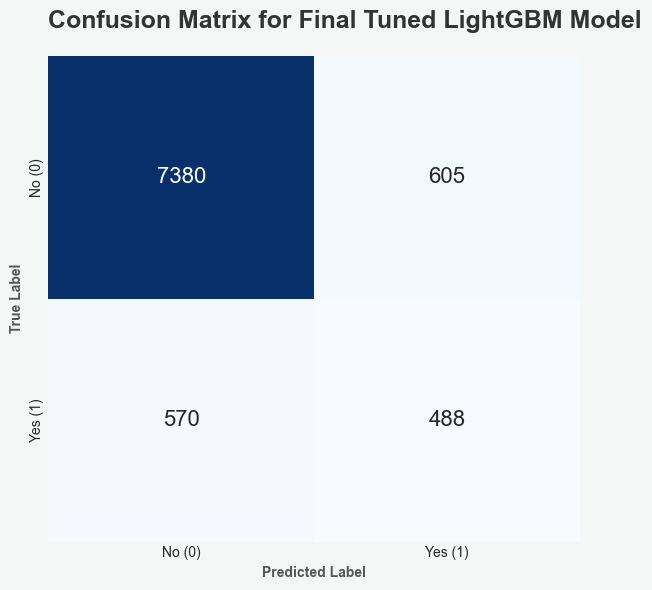


Final Model Performance:



,Precision,Recall,F1-Score,ROC AUC,Training Time (s)
Final Tuned LightGBM Model,0.45,0.46,0.45,0.79,6.37


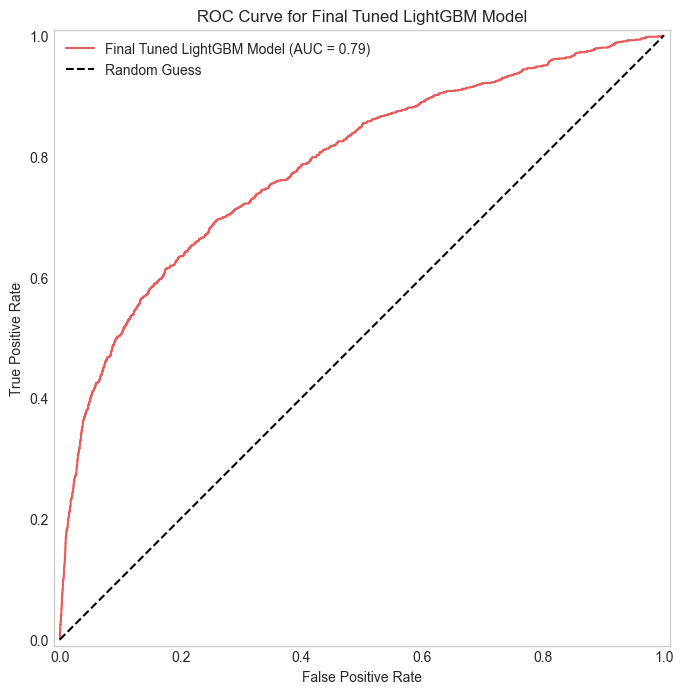

In [71]:
# Retrieving the best set of hyperparameters
best_lgbm_params = study_lgbm.best_params

final_lgbm_model = LGBMClassifier(**best_lgbm_params, random_state=seed, n_jobs=-1, verbose=-1)

# Creating the final pipeline with the best LightGBM model
final_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor_engineered),
    ('smote', SMOTE(random_state=seed)),
    ('classifier', final_lgbm_model)
])

# Training the final model
print("\n--- Training Final LightGBM Model with Optimized Hyperparameters ---\n")
start_time = time.time()
final_pipeline.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Final LightGBM model trained in {training_time:.2f} seconds.")
y_pred_final = final_pipeline.predict(X_test)
y_proba_final = final_pipeline.predict_proba(X_test)[:, 1]

# Evaluating the final model
print("\n--- Final Model Evaluation ---\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred_final, target_names=['no', 'yes']))
plot_confusion_matrix(y_test, y_pred_final, "Final Tuned LightGBM Model")

final_metrics = {
    'Precision': precision_score(y_test, y_pred_final),
    'Recall': recall_score(y_test, y_pred_final),
    'F1-Score': f1_score(y_test, y_pred_final),
    'ROC AUC': roc_auc_score(y_test, y_proba_final),
    'Training Time (s)': training_time
}
final_resutls_df = pd.DataFrame([final_metrics], index=['Final Tuned LightGBM Model'])
print("\nFinal Model Performance:\n")
display(final_resutls_df.style.format({'Precision': '{:.2f}', 'Recall': '{:.2f}', 'F1-Score': '{:.2f}',
                                       'ROC AUC': '{:.2f}', 'Training Time (s)': '{:.2f}'}))
# Plotting ROC Curve for the final model
fig, ax = plt.subplots(figsize=(8, 8))
RocCurveDisplay.from_predictions(y_test, y_proba_final, name="Final Tuned LightGBM Model", color='#E85B5B', ax=ax)
ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')
ax.set_title('ROC Curve for Final Tuned LightGBM Model')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.grid()
plt.show()
    

The fine-tuned LightGBM model achieved a strong performance on the hold-out test set, with an F1-Score of `0.45` and a ROC AUC of `0.79`. When compared to our best untuned model, the `GradientBoostingClassifier`, the results are very competitive. The untuned Gradient Boosting model also achieved an F1-Score of 0.45 but with a different performance profile.<br><br>
The confusion matrices reveal that:<br><br>
* Our fine-tuned LightGBM is more **precise** (0.45 vs. 0.42), making fewer false positive errors.<br><br>
* The Gradient Boosting model, on the other hand, had a slightly higher **Recall**, identifying more potential subscribers but at the cost of more wasted calls.<br><br>

Given that the fine-tuned LightGBM models achieves a top-tier F1-score, has better precision, a superior ROC AUC for ranking leads, and is significantly more **computationally efficient**, we select it as our final model. It gives us the best combination of predictive power and practical usability for this business problem.

### Feature Importance
Now that we have a final model, the last step is to check its behavior. In this section, we will visualize feature importances from our fined-tuned LGBM model. The goal is to understand which data points are most influentional in its decision-making. 

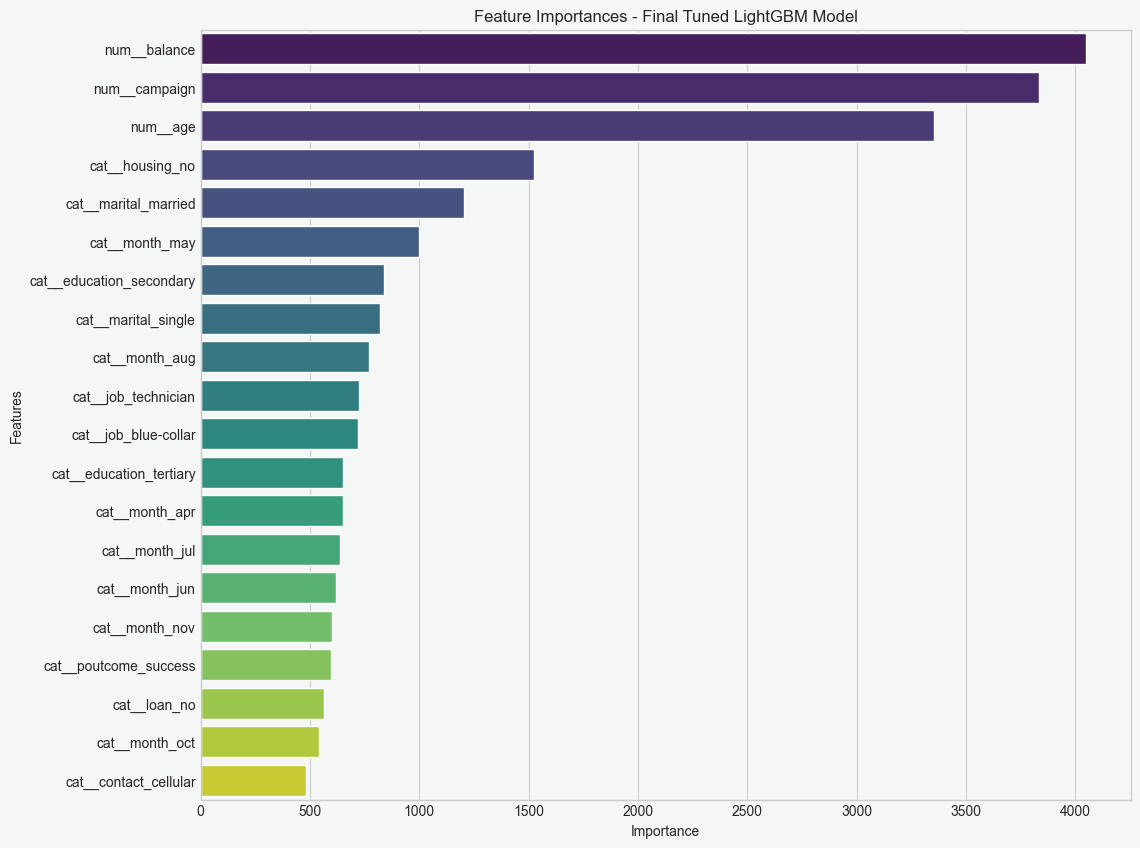

In [ ]:
# Computing Feature Importance
importances = final_pipeline.named_steps['classifier'].feature_importances_
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

# Plotting Feature Importances
plt.style.use('seaborn-v0_8-whitegrid')
fig,ax = plt.subplots(figsize=(12,10))
fig.set_facecolor('#f5f7f6')
ax.set_facecolor('#f5f7f6')

sns.barplot(x=feature_importances, y=feature_importances.index, ax=ax, palette='viridis')
ax.set_title('Feature Importances - Final Tuned LightGBM Model')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
plt.show()

- **Client Financial Profile**
    - The client's financial profile appears to be the most dominant factor in the model's predictions. `balance` is the top feature. We can also see that the model is also considering whether the client has an existing `housing` or `personal loan`. This strongly supports our hypothesis that clients with fewer existing financial liabilities are the primary target audience.

- **Campaign Strategy & Timing**
    - The `campaign` itself, specifically the number of contacts, is the second most important predictor, reinforcing that an optimized contact strategy is crucial. The **timing** of the campaign is also highly influential, with `month_may` (our least successful month) being a top predictor, alongside several other months. The outcome of a previous campaign (`poutcome_success`) also remains a key indicator.

- **Client Demographics** 
    - `Age` is the third most powerful feature overall. Other demographic details like `marital` status, `education` level, and `job` type also contribute significantly to the model's predictions, allowing it to build a profile of likely subscribers.

### Saving Model
The final step is to save our trained model so it can be used in other applications. We'll use the joblib library to serialize our entire `final_pipeline` object to a file. Saving the complete pipeline is crucial, as it ensures the exact same preprocessing steps are applied to new data during prediction, guaranteeing consistent results. This file can then be loaded to make live predictions without needing to retrain the model.

In [ ]:
# Displaying final pipeline
final_pipeline

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [74]:
# Saving model
model_dir = '../models'
file_name = 'final_lgbm_pipeline.joblib'
file_path = os.path.join(model_dir, file_name)

os.makedirs(model_dir, exist_ok=True)
joblib.dump(final_pipeline, file_path)

print(f"\nModel saved to {file_path}")


Model saved to ../models/final_lgbm_pipeline.joblib


---

---

## Conclusion
We have successfully developed a machine learning model to improve the efficiency of a bank's telemarketing campaigns. We followed a Data Science workflow, beginning with an Exploratory Data Analysis, then moving on to Data Pipeline & Preprocessing, and finally Model Selection and Fine-Tuning.<br><br>
Our final model, a fine-tuned LightGBM Classifier, achieved a F1-Score of 0.45 and a ROC AUC of 0.79 on the hold-out test set. This represents an improvement over our baseline and provides the bank with a tool to identify and prioritize high-potential clients. <br><br>
Our analysis confirmed the critical importance of campaign timing, client demographic (age, job), and financial profile (balance, existing loans). With these patterns, the final model can help the bank focus its resources more effectively, reducing costs associated with contacting uninterested clients, and ultimately increase its term deposit subscription rate. The saved pipeline is now ready for deployment in a production environment or an interactive application. 

---

---